In [1]:
pip install kneed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Reading in the data

df_tmb = pd.read_parquet('/content/final_summary_20251017.parquet')
df_tmb.head()

cartridgeSerialNumber  error_first  \
0                     0           81   
1             137051097            0   
2             137051110            0   
3             137051120            0   
4             137051166            0   

   rawTestDetail.testResultsInfo.errorCode_first   warnings_first  \
0                                           81.0  [4, 74, 72, 80]   
1                                            0.0              [6]   
2                                            0.0               []   
3                                            0.0               []   
4                                            0.0               []   

                 readerFirmwareVersion_first  readerHardwareVersion_first  \
0               1.5.0-beta.10-mux-leak-check                           15   
1               1.5.0-beta.4-6-gab63b390-mux                           15   
2               1.5.0-beta.4-6-gab63b390-mux                           15   
3               1.5.0-beta.4-6-gab63b390-mux                           15   
4  1.5.0-beta.5-17-gc522bbff-mux-record-mask                           15   

   readerSerialNumber_first  cartType_first  \
0            12102010125415               0   
1            22102010204918              19   
2            12202010076543              19   
3            22102010205235              19   
4            22102010205235              19   

                      procedureId_first  \
0  FB00602C-F296-432B-AF27-9F1E2542A7A9   
1  FB00602C-F296-432B-AF27-9F1E2542A7A9   
2  FB00602C-F296-432B-AF27-9F1E2542A7A9   
3  FB00602C-F296-432B-AF27-9F1E2542A7A9   
4  FB00602C-F296-432B-AF27-9F1E2542A7A9   

                                 procedureName_first  ...  we5_step93_max  \
0  745 MUX (666 Flu+CoV PID, modified RV flow check)  ...             NaN   
1  745 MUX (666 Flu+CoV PID, modified RV flow check)  ...             NaN   
2  745 MUX (666 Flu+CoV PID, modified RV flow check)  ...             NaN   
3  745 MUX (666 Flu+CoV PID, modified RV flow check)  ...             NaN   
4  745 MUX (666 Flu+CoV PID, modified RV flow check)  ...             NaN   

  we6_step93_mean  we6_step93_min  we6_step93_max  we1_step66_tailmean  \
0             NaN             NaN             NaN           -12.540335   
1             NaN             NaN             NaN           -53.839251   
2             NaN             NaN             NaN           -27.299443   
3             NaN             NaN             NaN           -84.461012   
4             NaN             NaN             NaN           -60.751939   

   we2_step66_tailmean  we3_step66_tailmean  we4_step66_tailmean  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   we5_step66_tailmean  we6_step66_tailmean  
0                  0.0                  0.0  
1                  0.0                  0.0  
2                  0.0                  0.0  
3                  0.0                  0.0  
4                  0.0                  0.0  

[5 rows x 133 columns]

In [4]:
# Reading in the testing sheet data and joining them together

df_siro = pd.read_csv('/content/SIRO Testing Sheet - FABC Testing.csv', header=[1])

df_archive = pd.read_csv('/content/Siro Test Data Archive - FABC Data.csv')

# Joining df_siro and df_archive

df_siro = pd.concat([df_siro, df_archive])
df_siro.shape

(146332, 40)

In [5]:
# Checking for overlap between dataframes

common = set(df_siro["Cartridge SN"]) & set(df_tmb["cartridgeSerialNumber"])
print("Overlap count:", len(common))
print("df_siro count:", df_siro["Cartridge SN"].nunique())
print("df count:", df_tmb["cartridgeSerialNumber"].nunique())



# concatenating df_tmb with df_siro by cartridgeSerialNumber by bringing over selected columns

# Ensure consistent types
df_siro["Cartridge SN"] = df_siro["Cartridge SN"].astype(str).str.strip()
df_tmb["cartridgeSerialNumber"] = df_tmb["cartridgeSerialNumber"].astype(str).str.strip()
df_siro["Cartridge SN"] = df_siro["Cartridge SN"].str.replace(r"\.0$", "", regex=True)
df_tmb["cartridgeSerialNumber"] = df_tmb["cartridgeSerialNumber"].str.replace(r"\.0$", "", regex=True)


# Merge on cartridge serial number
merged_df = pd.merge(
    df_siro,
    df_tmb,
    left_on="Cartridge SN",
    right_on="cartridgeSerialNumber",
    how="inner"   # or "inner" if you only want matching rows
)

# Optional: sanity check
print("Merged shape:", merged_df.shape)

Overlap count: 40667
df_siro count: 129538
df count: 52493
Merged shape: (64888, 173)


In [6]:
merged_df['cartridgeSerialNumber'].nunique()

43236

In [7]:
# making a copy of our df

merged_df_copy = merged_df.copy()

In [8]:
# Checking for NaN's

merged_df.isna().sum()


Study Label                0
Pellet                  1579
Variable A              2201
Variable B             30813
Variable C             62419
                       ...  
we2_step66_tailmean        0
we3_step66_tailmean        0
we4_step66_tailmean        0
we5_step66_tailmean        0
we6_step66_tailmean        0
Length: 173, dtype: int64

In [9]:
# dropping decimal from 'Reader SN'

# merged_df['Reader SN'] = merged_df['Reader SN'].astype(str).str.replace('.0', '', regex=False)

In [10]:
# Formatting 'Date Tested'

merged_df['Date Tested'] = pd.to_datetime(
    merged_df['Date Tested'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)
merged_df['Date Tested'] = merged_df['Date Tested'].dt.strftime('%d-%b-%Y')





In [11]:
# Formatting 'Mfg Date'

merged_df['Mfg Date'] = pd.to_datetime(
    merged_df['Mfg Date'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
    )
merged_df['Mfg Date'] = merged_df['Mfg Date'].dt.strftime('%d-%b-%Y')

In [12]:
# Formatting 'Reader SN' to int

merged_df['Reader SN'] = pd.to_numeric(
    merged_df['Reader SN'],
    errors='coerce'  # invalid strings become NaN
).astype('Int64')     # nullable integer type (keeps NaN)


In [13]:

# Formatting 'rawTestDetail.testResultsInfo.errorCode_first' to int

merged_df['rawTestDetail.testResultsInfo.errorCode_first'] = pd.to_numeric(
    merged_df['rawTestDetail.testResultsInfo.errorCode_first'],
    errors='coerce'  # invalid strings become NaN
).astype('Int64')


In [14]:
# cols_to_int = ['Warnings', 'Errors', 'warnings_first']

# for col in cols_to_int:
#     merged_df[col] = pd.to_numeric(
#         merged_df[col], errors='coerce'  # invalid values become NaN
#     ).astype('Int64')  # nullable integer type


In [15]:
merged_df['Warnings'].unique()

array([nan, '[6]', '[20, 93, 80]', '[20, 93]', '[83]', '[80]', '[6, 20]',
       '[20]', '[24]', '[68, 74, 72]', '[14, 93, 30]', '[72]', '[6, 83]',
       '[6, 80]', '[6, 93]', '[10, 20, 93, 80]', '[93, 30]',
       '[6, 20, 93, 80]', '[93, 80]', '[93]', '[74]', '[29]', '[95]',
       '83', '6', '[95, 80]', '[95, 6]', '[95, 96, 80]', '[95, 20]',
       '[29, 6]', '[74, 6, 80]', '[6, 20, 93]', '[10, 20, 80]',
       '[6, 93, 30]', '[95, 6, 80]', '[95, 96, 6, 20, 93, 80]',
       '[95, 96, 20, 93, 80]', '[95, 96]', '[96, 20, 93, 80]',
       '[95, 96, 20, 93]', '6, 20, 93, 80', '[13, 80]', '[88, 6, 28]',
       '[7, 74, 72]', '[6, 20, 80]', '[88]', '[7, 74, 72, 6]', '[84]',
       '[83, 6]', '80', '20, 93, 80', '6, 80', '20', '[68, 74, 80]',
       '93, 80', '[96, 83, 80]', '29, 6', '7, 74, 72', '[4, 74, 72, 6]',
       '[20, 80]', '[96, 93, 80]', '[96, 80]', '[96, 20, 93]',
       '[96, 6, 20, 93, 80]', '[96, 6, 80]', '[14, 93]',
       '[7, 74, 96, 72, 20, 93, 80]', '[7, 74, 96, 72]', 

In [16]:
merged_df.columns.to_list()

['Study Label',
 'Pellet',
 'Variable A',
 'Variable B',
 'Variable C',
 'Variable D',
 'Procedure',
 'Test Sample',
 'RP Type',
 'RP Cell Count',
 'RP Lot',
 'Flu A Strain',
 'Flu A Copies',
 'Flu A Lot',
 'Flu B Strain',
 'Flu B Copies',
 'Flu B Lot',
 'CoV Strain',
 'CoV Copies',
 'CoV Lot',
 'Handling Timepoint',
 'Notes',
 'Operator Initial',
 'Bag',
 'Cartridge SN',
 'Copies',
 'Lot Number',
 'Reader SN',
 'Mfg Date',
 'Date Tested',
 'WE1',
 'WE2',
 'WE3',
 'WE4',
 'WE5',
 'WE6',
 'Warnings',
 'Errors',
 'Excluded because',
 'Testing Verification',
 'cartridgeSerialNumber',
 'error_first',
 'rawTestDetail.testResultsInfo.errorCode_first',
 'warnings_first',
 'readerFirmwareVersion_first',
 'readerHardwareVersion_first',
 'readerSerialNumber_first',
 'cartType_first',
 'procedureId_first',
 'procedureName_first',
 'rawTestDetail.testResults.weValues_first',
 'rawTestDetail.testResults.assayResults_first',
 'we1_result_first',
 'we2_result_first',
 'we3_result_first',
 'we4_result

In [17]:
# Handling our NaN values

# Filling NaN with 0
cols_to_clean=['Flu A Copies','Flu B Copies','CoV Copies', 'Copies']
merged_df[cols_to_clean] = merged_df[cols_to_clean].fillna(0)

# Remove commas and convert to numeric, coercing errors
for col in cols_to_clean:
    # Convert to string first to handle potential non-string types before replacing
    merged_df[col] = merged_df[col].astype(str).str.replace(',', '', regex=False)
    # Convert to numeric, coercing errors to NaN
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Fill any NaNs created by coercion with 0 before converting to int
merged_df[cols_to_clean] = merged_df[cols_to_clean].fillna(0)

# Converting to int
merged_df[cols_to_clean] = merged_df[cols_to_clean].astype(int)


# Filling NaN values in WE1, WE2, WE3, WE4, WE5, and WE6 with 0

cols_to_fill = ['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']
merged_df[cols_to_fill] = merged_df[cols_to_fill].fillna(0)


# Ensuring WE_ columns are integers

merged_df['WE1'] = merged_df['WE1'].astype(int)
merged_df['WE2'] = merged_df['WE2'].astype(int)
merged_df['WE3'] = merged_df['WE3'].astype(int)
merged_df['WE4'] = merged_df['WE4'].astype(int)
merged_df['WE5'] = merged_df['WE5'].astype(int)
merged_df['WE6'] = merged_df['WE6'].astype(int)


In [18]:
# Filtering Dataset to Mfg Date after 11-Aug-2025

# print(f'Before filtering:',merged_df.shape)
# merged_df = merged_df[merged_df['Mfg Date'] > '11-Aug-2025']

# print(f'After filtering:',merged_df.shape)


In [19]:
# Checking our "Flu A Copies", "Flu B Copies", and 'CoV Copies'

print(merged_df['Flu A Copies'].value_counts())
print(merged_df['Flu B Copies'].value_counts())
print(merged_df['CoV Copies'].value_counts())

Flu A Copies
0         52716
150        3512
600        2887
200        1950
60         1181
300         847
50          615
1000        345
100         193
440          95
220          70
20           60
2290         54
330          44
200000       40
10000        40
3000         40
400          32
15000        20
10400        20
2200         15
1320         15
5000         12
30           12
125          12
153          10
612          10
306          10
75           10
51           10
1             9
720           2
Name: count, dtype: int64
Flu B Copies
0         53773
600        5397
200        3101
60         1078
300         766
100         338
30          130
400          96
50           46
150          40
200000       40
1000         12
146          10
1200         10
219          10
120          10
36           10
215           7
1             6
5             6
636           2
Name: count, dtype: int64
CoV Copies
0        55490
150       3445
600       1891
200       1469
60 

In [20]:
# Creating target-specific dataframes

# # Group data by 'Test Sample' including 'Donor'
# df_fluA = merged_df[(merged_df['Test Sample'] == 'FluA') | (merged_df['Test Sample'] == 'Donor')]
# df_fluB = merged_df[(merged_df['Test Sample'] == 'FluB') | (merged_df['Test Sample'] == 'Donor')]
# df_cov = merged_df[(merged_df['Test Sample'] == 'CoV') | (merged_df['Test Sample'] == 'Donor')]

# Group data by 'Test Sample' excluding 'Donor'
df_fluA = merged_df[merged_df['Test Sample'] == 'FluA']
df_fluB = merged_df[merged_df['Test Sample'] == 'FluB']
df_cov = merged_df[merged_df['Test Sample'] == 'CoV']
df_ntc = merged_df[merged_df['Test Sample'] == 'NTC']


# Dropping columns from df_fluA, df_fluB, and df_cov

# FluA drops
cols_to_drop_A=['Flu B Strain',
 'Flu B Copies',
 'Flu B Lot',
 'CoV Strain',
 'CoV Copies',
 'CoV Lot'
    ]

df_fluA = df_fluA.drop(columns=cols_to_drop_A)

# FluB drops
cols_to_drop_B=['Flu A Strain',
 'Flu A Copies',
 'Flu A Lot',
 'CoV Strain',
 'CoV Copies',
 'CoV Lot'
    ]

df_fluB = df_fluB.drop(columns=cols_to_drop_B)

# CoV drops
cols_to_drop_C=['Flu B Strain',
 'Flu B Copies',
 'Flu B Lot',
 'Flu A Strain',
 'Flu A Copies',
 'Flu A Lot'
    ]

df_cov = df_cov.drop(columns=cols_to_drop_C)


# Renaming _Strain, _Copies, and _Lot in df_fluA, df_fluB, and df_cov

df_fluA.rename(columns={
    'Flu A Strain': 'Virus_Strain',
    'Flu A Copies': 'Virus_Copies',
    'Flu A Lot': 'Virus_Lot'
}, inplace=True)

df_fluB.rename(columns={
    'Flu B Strain': 'Virus_Strain',
    'Flu B Copies': 'Virus_Copies',
    'Flu B Lot': 'Virus_Lot'
}, inplace=True)

df_cov.rename(columns={
    'CoV Strain': 'Virus_Strain',
    'CoV Copies': 'Virus_Copies',
    'CoV Lot': 'Virus_Lot'
}, inplace=True)

In [21]:
# Checking our "Flu A Copies", "Flu B Copies", and 'CoV Copies'

print(f'FluA Copies:', df_fluA['Virus_Copies'].value_counts())
print(f'FluB Copies:',df_fluB['Virus_Copies'].value_counts())
print(f'CoV Copies:',df_cov['Virus_Copies'].value_counts())

FluA Copies: Virus_Copies
150      3303
600      2809
200      1910
60       1181
300       847
50        595
1000      345
0         228
100       189
440        95
220        70
20         60
330        44
10000      40
3000       40
400        32
10400      20
1320       15
2200       15
30         12
5000       12
125        12
612        10
306        10
153        10
75         10
51         10
1           9
720         2
Name: count, dtype: int64
FluB Copies: Virus_Copies
600     5108
200     2943
60      1078
300      766
0        537
100      338
30       130
400       96
50        46
1000      12
146       10
1200      10
219       10
120       10
36        10
5          6
1          6
215        3
636        2
Name: count, dtype: int64
CoV Copies: Virus_Copies
150    3182
600    1831
200    1429
60     1028
0      1023
50      666
100     527
300     223
20       23
30       12
75        5
10        3
3         3
1         3
Name: count, dtype: int64


In [22]:
# Creating the FN and FP columns for the target-specific dataframes

# fluA
# Create binary columns based on threshold logic
df_fluA["FN"] = (df_fluA["WE3"] > -3000).astype(int)

df_fluA["WE2_FP"] = (df_fluA["WE2"] <= -3000).astype(int)

df_fluA["WE5_FP"] = (df_fluA["WE5"] <= -3000).astype(int)


# FluB
df_fluB["FN"] = (df_fluB["WE2"] > -3000).astype(int)

df_fluB["WE3_FP"] = (df_fluB["WE3"] <= -3000).astype(int)

df_fluB["WE5_FP"] = (df_fluB["WE5"] <= -3000).astype(int)

# Cov
df_cov["FN"] = (df_cov["WE5"] > -3000).astype(int)

df_cov["WE3_FP"] = (df_cov["WE3"] <= -3000).astype(int)

df_cov["WE2_FP"] = (df_cov["WE2"] <= -3000).astype(int)

# NTC
df_ntc["WE2_FP"] = (df_ntc["WE2"] <= -3000).astype(int)
df_ntc['WE3_FP'] = (df_ntc['WE3'] <= -3000).astype(int)
df_ntc['WE5_FP'] = (df_ntc['WE5'] <= -3000).astype(int)



In [23]:
merged_df['we1_step66_tailmean'].unique()

array([-29.91069133, -39.97587943, -31.55024073, ...,  -3.0575374 ,
       -24.0171778 , -18.78834653])

In [24]:
# Looking for instances in the merged_df where 'we1_step66_mean' is less than -1000 and WE4 is less than -3000

merged_df[(merged_df['we1_step66_tailmean'] < -1000) & (merged_df['WE4'] < -3000)]


Study Label                                  Pellet  \
6591    FABC-0324         FABC-Tetra-20250917-MT-HF-T6K-A   
10741   FABC-0314         FABC-Tetra-20250908-MT-HF-T2K-A   
15443   FABC-0296         FABC-Tetra-20250828-MT-HF-T6K-A   
17220   FABC-0267   Wax82-FABC-Tetra-20250730-MG-HF-T6K-A   
27166   FABC-0314         FABC-Tetra-20250908-MT-HF-T2K-A   
28689   FABC-0324         FABC-Tetra-20250917-MT-HF-T6K-A   
31830   FABC-0296         FABC-Tetra-20250828-MT-HF-T6K-A   
39152   FABC-0267   Wax82-FABC-Tetra-20250730-MG-HF-T6K-A   
50776   FABC-0232  Wax108-FABC-Tetra-20250609-MG-HF-T6K-A   
50866   FABC-0232  Wax108-FABC-Tetra-20250609-MG-HF-T6K-A   

                                Variable A         Variable B Variable C  \
6591                     LoB day 2, 58037H  VVP-1128_NTC_SM_2        NaN   
10741                Tecan 160.02, build 2         t=2wk, 30C        NaN   
15443                     Tecan 155 (T142)         40C 1 week        NaN   
17220  1X PDDNM + Virus (PTC, 200 cp/wand)                NaN        NaN   
27166                Tecan 160.02, build 2         t=2wk, 30C        NaN   
28689                    LoB day 2, 58037H  VVP-1128_NTC_SM_2        NaN   
31830                     Tecan 155 (T142)         40C 1 week        NaN   
39152  1X PDDNM + Virus (PTC, 200 cp/wand)                NaN        NaN   
50776                            Wash Leak           T=2; 40C        NaN   
50866                             TMB Leak           T=2; 40C        NaN   

      Variable D                                          Procedure  \
6591         NaN                                         FABC-1.0.0   
10741        NaN                                         FABC-1.0.0   
15443        NaN                                   FABC-005-13Aug25   
17220        NaN  745 MUX (666 Flu+CoV PID, modified RV flow check)   
27166        NaN                                         FABC-1.0.0   
28689        NaN                                         FABC-1.0.0   
31830        NaN                                   FABC-005-13Aug25   
39152        NaN  745 MUX (666 Flu+CoV PID, modified RV flow check)   
50776        NaN  745 MUX (666 Flu+CoV PID, modified RV flow check)   
50866        NaN  745 MUX (666 Flu+CoV PID, modified RV flow check)   

      Test Sample     RP Type RP Cell Count  ... we5_step93_max  \
6591          NTC         SCM             -  ...            0.0   
10741         NTC         SCM           NaN  ...            0.0   
15443         CoV         SCM             -  ...            0.0   
17220        FluB       PDDNM           NaN  ...            NaN   
27166         NTC         SCM           NaN  ...            0.0   
28689         NTC         SCM             -  ...            0.0   
31830         CoV         SCM             -  ...            0.0   
39152        FluB       PDDNM           NaN  ...            NaN   
50776         NTC  A549 Cells             -  ...            NaN   
50866         NTC  A549 Cells             -  ...            NaN   

      we6_step93_mean  we6_step93_min we6_step93_max we1_step66_tailmean  \
6591         0.000000          0.0000            0.0       -15661.002850   
10741     -566.723064      -2623.4622            0.0       -10620.319193   
15443    -5802.806436      -8847.3590            0.0        -1223.299247   
17220             NaN             NaN            NaN       -14786.362714   
27166     -566.723064      -2623.4622            0.0       -10620.319193   
28689        0.000000          0.0000            0.0       -15661.002850   
31830    -5802.806436      -8847.3590            0.0        -1223.299247   
39152             NaN             NaN            NaN       -14786.362714   
50776             NaN             NaN            NaN        -3793.752833   
50866             NaN             NaN            NaN        -2676.759767   

       we2_step66_tailmean we3_step66_tailmean we4_step66_tailmean  \
6591                   0.0                 0.0                 0.0   


In [25]:
# Checking 'Procedure Name' values within the dataset

merged_df['Procedure'].value_counts()

Procedure
745 MUX (666 Flu+CoV PID, modified RV flow check)     34148
FABC-1.0.0                                            28862
FABC-005-13Aug25                                       1630
Custom Needed                                           240
FABC-003-R&D-16Apr25-PID-15MinMT-FeEDTA-Concurrent        8
Name: count, dtype: int64

In [26]:
# Keeping only 745 MUX (666 Flu+CoV PID, modified RV flow check), FABC-1.0.0, and FABC-005-13Aug25

merged_df = merged_df[merged_df['Procedure'].isin(['745 MUX (666 Flu+CoV PID, modified RV flow check)', 'FABC-1.0.0', 'FABC-005-13Aug25'])]
merged_df.shape

(64640, 173)

## WE1 PreCheck Binning Analysis

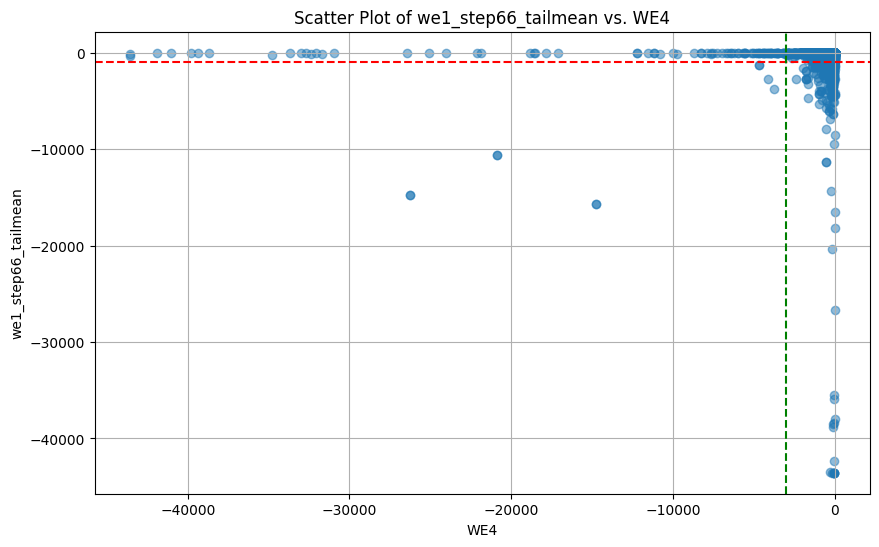

In [27]:
# Visualizing 'we1_step66_tailmean values as a function of WE4 values

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['WE4'], merged_df['we1_step66_tailmean'], alpha=0.5)
plt.xlabel('WE4')
plt.ylabel('we1_step66_tailmean')
plt.title('Scatter Plot of we1_step66_tailmean vs. WE4')
# horizontal line at -1000
plt.axhline(y=-1000, color='r', linestyle='--')
# vertical line at -3000
plt.axvline(x=-3000, color='g', linestyle='--')
plt.grid(True)
plt.show()

In [28]:
# Getting a count of values in each bin in the histplot

merged_df['we1_step66_tailmean'].value_counts()


we1_step66_tailmean
 0.000000     189
-4.652774      52
-4.652774      49
-7.311503      47
-6.646821      45
             ... 
-11.299594      1
-11.919965      1
-33.376532      1
-31.284368      1
-11.166658      1
Name: count, Length: 26763, dtype: int64

In [29]:
# Standardizing 'Date Tested' format

merged_df['Date Tested'] = pd.to_datetime(merged_df['Date Tested'], format='mixed')

# Standardizing "Reader SN" strings

merged_df['Reader SN'] = merged_df['Reader SN'].astype(str)
merged_df['Reader SN'] = merged_df['Reader SN'].str.strip()
merged_df['Reader SN'] = merged_df['Reader SN'].str.replace(r'\.0$', '', regex=True)

In [30]:
# drop duplicated

merged_df = merged_df.drop_duplicates()

In [31]:
# Binning the WE1 precheck data

col = "we1_step66_tailmean"
data = merged_df[col].dropna()

# Define your bins and labels
bins = [float("-inf"), -1000, -500, -300, -150, -70, 0, float("inf")]
labels = [
    "< -1000",
    "-1000 to -501",
    "-500 to -301",
    "-300 to -151",
    "-150 to -71",
    "-70 to 0",
    "> 0"
]

# Apply binning
binned = pd.cut(data, bins=bins, labels=labels, include_lowest=True)
summary = binned.value_counts().sort_index().reset_index()
summary.columns = ["bin_range", "count"]

# Add percentages
summary["percent"] = (summary["count"] / summary["count"].sum() * 100).round(2)

print(summary)


       bin_range  count  percent
0        < -1000    249     0.48
1  -1000 to -501    138     0.26
2   -500 to -301    109     0.21
3   -300 to -151    678     1.30
4    -150 to -71   6774    12.94
5       -70 to 0  44386    84.81
6            > 0      0     0.00


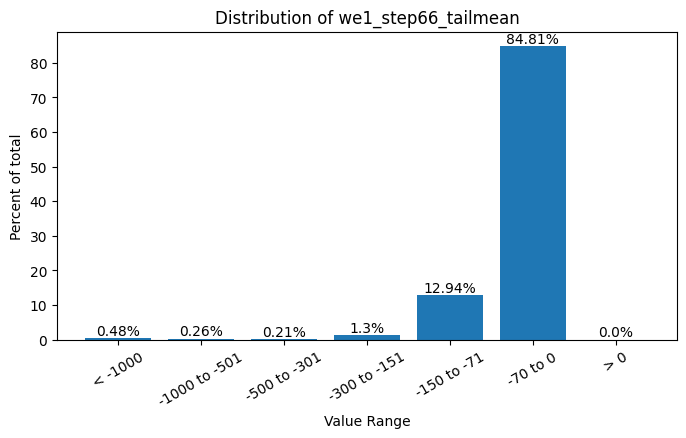

In [32]:
# Visualizing the bins

plt.figure(figsize=(8,4))
plt.bar(summary["bin_range"], summary["percent"])
plt.title(f"Distribution of {col}")
plt.xlabel("Value Range")
plt.ylabel("Percent of total")
plt.xticks(rotation=30)
# Annotating percentage above each bar
for i, v in enumerate(summary["percent"]):
    plt.text(i, v, f"{v}%", ha="center", va="bottom")
plt.show()


In [33]:
# Looking at WE1, WE2, WE3, WE4, WE5, and WE6 values of my individual bins

# Add the binned data as a new column to merged_df
merged_df['we1_bins'] = binned

# Group by the created bins and describe the WE columns
we_analysis = merged_df.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].describe()
display(we_analysis)

WE1                                                 \
                 count          mean           std      min       25%   
we1_bins                                                                
< -1000          249.0 -15978.345382  10692.977494 -43561.0 -23145.00   
-1000 to -501    138.0 -13230.224638   9847.550151 -31245.0 -20889.00   
-500 to -301     109.0 -10666.247706   9395.899591 -30884.0 -18216.00   
-300 to -151     678.0 -12499.346608   7285.822723 -31324.0 -16851.00   
-150 to -71     6774.0 -12888.855920   7711.826035 -33257.0 -18173.75   
-70 to 0       44386.0 -14523.415762   8569.709100 -36065.0 -21003.00   
> 0                0.0           NaN           NaN      NaN       NaN   

                                          WE2               ...     WE5       \
                   50%      75%  max    count         mean  ...     75%  max   
we1_bins                                                    ...                
< -1000       -15623.0 -8034.00  0.0    249.0 -5670.518072  ...  -66.00  0.0   
-1000 to -501 -14310.0  -973.00  0.0    138.0 -2700.333333  ...  -74.25  0.0   
-500 to -301  -11188.0  -422.00  0.0    109.0 -1949.018349  ...  -69.00  0.0   
-300 to -151  -13814.0 -8557.75  0.0    678.0 -1920.556047  ... -100.00  0.0   
-150 to -71   -14050.5 -8147.00  0.0   6774.0 -2447.797756  ...  -92.00  0.0   
-70 to 0      -15958.5 -8722.25  0.0  44386.0 -2773.260848  ...  -78.00  0.0   
> 0                NaN      NaN  NaN      0.0          NaN  ...     NaN  NaN   

                   WE6                                                         \
                 count          mean          std      min       25%      50%   
we1_bins                                                                        
< -1000          249.0 -15881.923695  5484.392109 -33526.0 -19200.00 -15273.0   
-1000 to -501    138.0 -13380.681159  6045.181911 -23341.0 -17537.50 -14309.0   
-500 to -301     109.0 -12866.000000  5921.610329 -27830.0 -15895.00 -13696.0   
-300 to -151     678.0 -15342.626844  4768.705834 -30446.0 -18414.00 -15799.5   
-150 to -71     6774.0 -16157.456156  3610.766955 -30605.0 -18418.50 -16219.5   
-70 to 0       44386.0 -15508.747601  3831.769741 -33932.0 -17953.75 -15432.0   
> 0                0.0           NaN          NaN      NaN       NaN      NaN   

                                
                    75%    max  
we1_bins                        
< -1000       -13232.00 -120.0  
-1000 to -501 -11273.00  -91.0  
-500 to -301   -9591.00 -166.0  
-300 to -151  -12659.25    0.0  
-150 to -71   -14153.25    0.0  
-70 to 0      -13182.00    0.0  
> 0                 NaN    NaN  

[7 rows x 48 columns]

WE1          WE2          WE3         WE4  \
we1_bins                                                            
< -1000       -15978.345382 -5670.518072 -3971.329317 -629.281124   
-1000 to -501 -13230.224638 -2700.333333 -1571.891304 -303.630435   
-500 to -301  -10666.247706 -1949.018349 -3278.009174 -674.651376   
-300 to -151  -12499.346608 -1920.556047 -4687.379056 -368.998525   
-150 to -71   -12888.855920 -2447.797756 -4718.284027 -199.943313   
-70 to 0      -14523.415762 -2773.260848 -4218.323007 -183.461204   
> 0                     NaN          NaN          NaN         NaN   

                       WE5           WE6  
we1_bins                                  
< -1000       -2961.257028 -15881.923695  
-1000 to -501 -1974.449275 -13380.681159  
-500 to -301  -2386.935780 -12866.000000  
-300 to -151  -3671.064897 -15342.626844  
-150 to -71   -3228.346619 -16157.456156  
-70 to 0      -2742.110936 -15508.747601  
> 0                    NaN           NaN

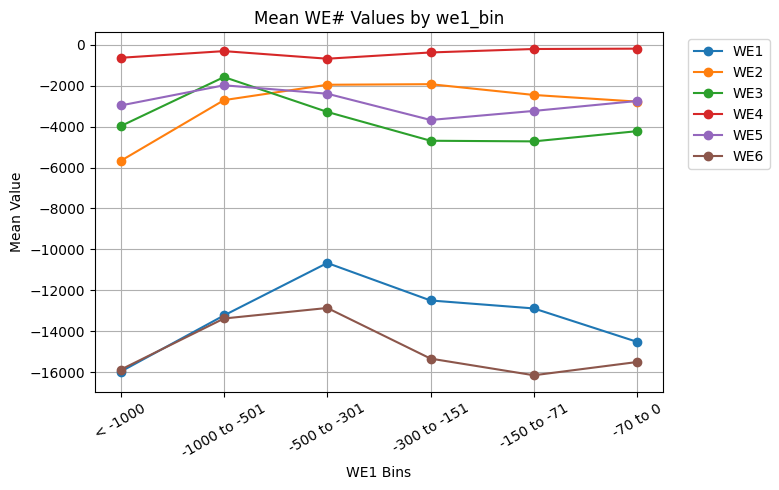

In [34]:
import matplotlib.pyplot as plt

# Extract just the mean rows for each WE column per bin
we_means = merged_df.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].mean()

# Optional: ensure bins appear in logical order (based on your label order)
we_means = we_means.reindex(labels)

# Display table of mean values
display(we_means)

# --- Plot setup ---
plt.figure(figsize=(8,5))
for col in we_means.columns:
    plt.plot(we_means.index, we_means[col], marker='o', label=col)

plt.title("Mean WE# Values by we1_bin")
plt.xlabel("WE1 Bins")
plt.ylabel("Mean Value")
plt.legend(title="WE#")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right'),
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()


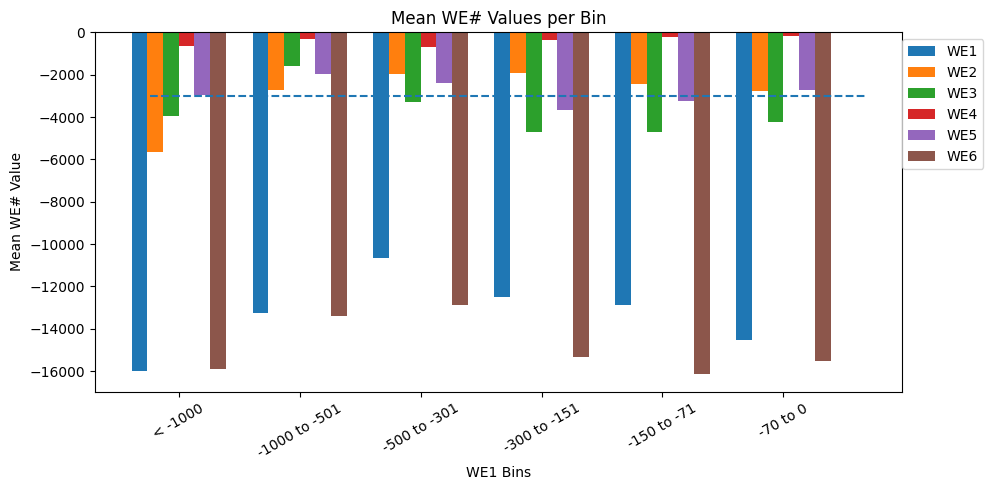

In [35]:
import matplotlib.pyplot as plt
import numpy as np

we_means = merged_df.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].mean()
we_means = we_means.reindex(labels)  # ensure correct bin order

bins = we_means.index
we_cols = we_means.columns
x = np.arange(len(bins))  # the label locations
width = 0.13  # width of each bar

plt.figure(figsize=(10,5))
for i, col in enumerate(we_cols):
    plt.bar(x + i*width, we_means[col], width=width, label=col)

plt.xticks(x + width*2.5, bins, rotation=30)
plt.ylabel("Mean WE# Value")
plt.xlabel("WE1 Bins")
plt.title("Mean WE# Values per Bin")
plt.legend(title="WE#")
plt.legend(bbox_to_anchor=(1.11, 1), loc='upper right')
plt.hlines(y=-3000, xmin=x.min(), xmax=x.max(), linestyles='dashed')
plt.tight_layout()
plt.show()


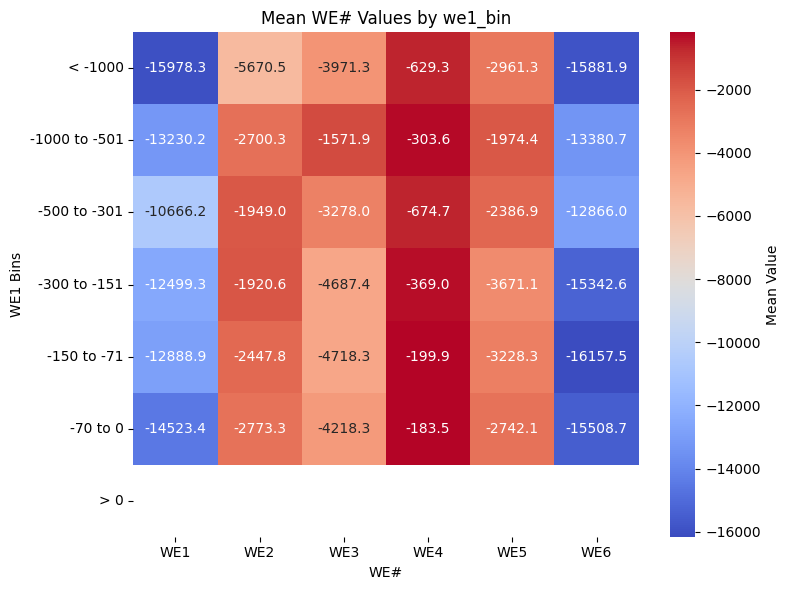

In [36]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(we_means, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Mean Value'})
plt.title("Mean WE# Values by we1_bin")
plt.ylabel("WE1 Bins")
plt.xlabel("WE#")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [37]:
import pandas as pd

# 1️⃣ Compute mean WE values per bin
we_means = merged_df.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].mean()

# Ensure bins are in the correct order
we_means = we_means.reindex(labels)

# 2️⃣ Count samples per bin
bin_counts = merged_df['we1_bins'].value_counts().reindex(labels)
bin_counts.name = "count"

# 3️⃣ Identify the control bin
control_bin = "-70 to 0"
control_values = we_means.loc[control_bin]

# 4️⃣ Compute Delta_WE# relative to control
delta_cols = {col: f"Delta_{col}" for col in we_means.columns}
delta_values = we_means - control_values
delta_values.rename(columns=delta_cols, inplace=True)

# 5️⃣ Combine counts, means, and deltas into one summary DataFrame
summary_df = pd.concat([bin_counts, we_means, delta_values], axis=1).reset_index()
summary_df.rename(columns={"we1_bins": "bin_range"}, inplace=True)

# 6️⃣ Format numeric columns to 1 decimal place
we_cols = ['WE1','WE2','WE3','WE4','WE5','WE6']
delta_cols = [f"Delta_{col}" for col in we_cols]
summary_df[we_cols + delta_cols] = summary_df[we_cols + delta_cols].round(1)

# 7️⃣ Display the table
display(summary_df)


bin_range  count      WE1     WE2     WE3    WE4     WE5      WE6  \
0        < -1000    249 -15978.3 -5670.5 -3971.3 -629.3 -2961.3 -15881.9   
1  -1000 to -501    138 -13230.2 -2700.3 -1571.9 -303.6 -1974.4 -13380.7   
2   -500 to -301    109 -10666.2 -1949.0 -3278.0 -674.7 -2386.9 -12866.0   
3   -300 to -151    678 -12499.3 -1920.6 -4687.4 -369.0 -3671.1 -15342.6   
4    -150 to -71   6774 -12888.9 -2447.8 -4718.3 -199.9 -3228.3 -16157.5   
5       -70 to 0  44386 -14523.4 -2773.3 -4218.3 -183.5 -2742.1 -15508.7   
6            > 0      0      NaN     NaN     NaN    NaN     NaN      NaN   

   Delta_WE1  Delta_WE2  Delta_WE3  Delta_WE4  Delta_WE5  Delta_WE6  
0    -1454.9    -2897.3      247.0     -445.8     -219.1     -373.2  
1     1293.2       72.9     2646.4     -120.2      767.7     2128.1  
2     3857.2      824.2      940.3     -491.2      355.2     2642.7  
3     2024.1      852.7     -469.1     -185.5     -929.0      166.1  
4     1634.6      325.5     -500.0      -16.5     -486.2     -648.7  
5        0.0        0.0        0.0        0.0        0.0        0.0  
6        NaN        NaN        NaN        NaN        NaN        NaN

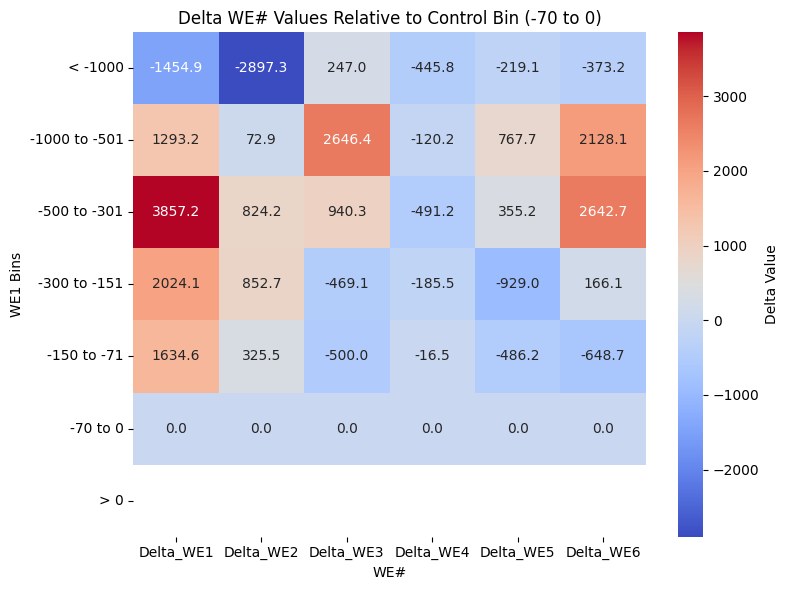

In [38]:
# Plot the Delta WE's

delta_only = summary_df.set_index('bin_range')[delta_cols]

plt.figure(figsize=(8,6))
sns.heatmap(delta_only, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Delta Value'})
plt.title("Delta WE# Values Relative to Control Bin (-70 to 0)")
plt.ylabel("WE1 Bins")
plt.xlabel("WE#")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [39]:
# Extracting cartridge information for cartridges where we1_step66_tailmean is between -500 and -301

cartridge_serial_numbers = merged_df[(merged_df['we1_step66_tailmean'] > -500) & (merged_df['we1_step66_tailmean'] < -301)]
print(f'Unique cartridges are:', cartridge_serial_numbers['cartridgeSerialNumber'].head(15))

Unique cartridges are: 4271     137212809
12290    137119509
16741    137168719
16765    137166595
16986    137167116
17126    137162146
17648    137165768
19512    137159790
19723    137151850
20809    137160522
21668    137155036
21819    137155417
21869    137155281
22254    137142537
22323    137142464
Name: cartridgeSerialNumber, dtype: object


In [40]:
# Looking at the runtime details of the cartridge_serial_numbers (-301 to -501 WE1 precheck bin)

cols_to_keep=[
    'cartridgeSerialNumber',
    'Pellet',
    'Procedure',
    'we1_step66_tailmean',
    'Lot Number',
 'Reader SN',
 'Mfg Date',
 'Date Tested',
    'Warnings',
 'Errors',
    'WE1',
    'WE2',
    'WE3',
    'WE4',
    'WE5',
    'WE6'
]

cartridge_serial_numbers_filtered = cartridge_serial_numbers[cols_to_keep]
cartridge_serial_numbers_filtered.head(18)

cartridgeSerialNumber                                  Pellet  \
4271              137212809          FABC-Tetra-20251001-MT-HF-HD-G   
12290             137119509                                     NaN   
16741             137168719   Wax82-FABC-Tetra-20250806-MT-HF-T6K-A   
16765             137166595   Wax82-FABC-Tetra-20250805-MG-HF-T6K-A   
16986             137167116   Wax82-FABC-Tetra-20250805-MT-HF-T6K-B   
17126             137162146   Wax82-FABC-Tetra-20250730-MG-HF-T6K-A   
17648             137165768   Wax82-FABC-Tetra-20250804-MG-HF-T6K-A   
19512             137159790          FABC-Tetra-20250711-MT-HF-HD-B   
19723             137151850                                     NaN   
20809             137160522   Wax82-FABC-Tetra-20250721-MG-HF-T6K-A   
21668             137155036   Wax82-FABC-Tetra-20250718-MG-HF-T6K-A   
21819             137155417   Wax82-FABC-Tetra-20250718-MG-HF-T6K-A   
21869             137155281   Wax82-FABC-Tetra-20250718-MG-HF-T6K-A   
22254             137142537  Wax108-FABC-Tetra-20250630-MG-HF-T6K-A   
22323             137142464  Wax108-FABC-Tetra-20250630-MG-HF-T6K-A   
22361             137142977  Wax108-FABC-Tetra-20250630-MG-HF-T6K-A   
27350             137142464  Wax108-FABC-Tetra-20250630-MG-HF-T6K-A   
27384             137142977  Wax108-FABC-Tetra-20250630-MG-HF-T6K-A   

                                               Procedure  we1_step66_tailmean  \
4271                                          FABC-1.0.0          -356.940495   
12290                                         FABC-1.0.0          -328.445716   
16741  745 MUX (666 Flu+CoV PID, modified RV flow check)          -408.975601   
16765  745 MUX (666 Flu+CoV PID, modified RV flow check)          -424.605121   
16986  745 MUX (666 Flu+CoV PID, modified RV flow check)          -311.407692   
17126  745 MUX (666 Flu+CoV PID, modified RV flow check)          -473.070538   
17648  745 MUX (666 Flu+CoV PID, modified RV flow check)          -375.108464   
19512  745 MUX (666 Flu+CoV PID, modified RV flow check)          -447.292945   
19723  745 MUX (666 Flu+CoV PID, modified RV flow check)          -387.990639   
20809  745 MUX (666 Flu+CoV PID, modified RV flow check)          -451.458281   
21668  745 MUX (666 Flu+CoV PID, modified RV flow check)          -477.391277   
21819  745 MUX (666 Flu+CoV PID, modified RV flow check)          -464.707606   
21869  745 MUX (666 Flu+CoV PID, modified RV flow check)          -334.244725   
22254  745 MUX (666 Flu+CoV PID, modified RV flow check)          -393.308098   
22323                                         FABC-1.0.0          -334.295049   
22361                                         FABC-1.0.0          -331.902057   
27350                                         FABC-1.0.0          -334.295049   
27384                                         FABC-1.0.0          -331.902057   

      Lot Number       Reader SN     Mfg Date Date Tested Warnings Errors  \
4271     R58052H  12202010090368  03-Oct-2025  2025-10-06      NaN    NaN   
12290    R57584I  12102010131018  06-Jun-2025  2025-09-16      NaN    NaN   
16741    R57910H  12202010082982  08-Aug-2025  2025-08-08      NaN    NaN   
16765    R57906H  12002010004205  07-Aug-2025  2025-08-07      NaN    NaN   
16986    R57908H  12202010013132  07-Aug-2025  2025-08-08      NaN    NaN   
17126    R57902H  12102010081782  04-Aug-2025  2025-08-08      NaN    NaN   
17648    R57904H  12102010161207  06-Aug-2025  2025-08-06      NaN    NaN   
19512    R57839H  12102010138374  31-Jul-2025  2025-08-05      NaN    NaN   
19723    R57853H  12102010133232  22-Jul-2025  2025-08-05      NaN    NaN   
20809    R57901H  12102010089679  01-Aug-2025  2025-08-11     [80]    NaN   
21668    R57872H  12202010047848  25-Jul-2025  2025-08-13      NaN    NaN   
21819    R57873H  12102010129228  25-Jul-2025  2025-08-11      NaN    NaN   
21869    R57873H  12202010047850  25-Jul-2025  2025-08-13      NaN    NaN   
22254    R57776H  12102010123927  08-J

In [41]:
# Extracting cartridge information for cartridges where we1_step66_tailmean is between -1000 and -501

cartridge_serial_numbers_1000 = merged_df[(merged_df['we1_step66_tailmean'] > -1000) & (merged_df['we1_step66_tailmean'] < -501)]
print(f'Unique cartridges are:', cartridge_serial_numbers_1000['cartridgeSerialNumber'].head(15))

Unique cartridges are: 1619     137222417
9726     137199665
14659    153480814
15269    153480497
16662    137167715
16911    137166548
17231    137163128
17322    137168912
17663    137165913
17685    137165820
17850    137165882
17866    137165016
17868    137165642
19597    137159320
19994    137163278
Name: cartridgeSerialNumber, dtype: object


In [42]:
# Looking at the runtime details of the cartridge_serial_numbers (-501 to -1000 WE1 precheck bin)

cols_to_keep=[
    'cartridgeSerialNumber',
    'Pellet',
    'Procedure',
    'we1_step66_tailmean',
    'Lot Number',
 'Reader SN',
 'Mfg Date',
 'Date Tested',
    'Warnings',
 'Errors',
    'WE1',
    'WE2',
    'WE3',
    'WE4',
    'WE5',
    'WE6'
]

cartridge_serial_numbers_1000_filtered = cartridge_serial_numbers_1000[cols_to_keep]
cartridge_serial_numbers_1000_filtered.head(18)

cartridgeSerialNumber                                 Pellet  \
1619              137222417        FABC-Tetra-20251007-KS-HF-T2K-A   
9726              137199665        FABC-Tetra-20250916-MT-HF-T6K-A   
14659             153480814                                    NaN   
15269             153480497        FABC-Tetra-20250827-MT-HF-T6K-A   
16662             137167715  Wax82-FABC-Tetra-20250806-MG-HF-T6K-A   
16911             137166548  Wax82-FABC-Tetra-20250805-MT-HF-T6K-A   
17231             137163128  Wax82-FABC-Tetra-20250730-MG-HF-T6K-A   
17322             137168912        FABC-Tetra-20250723-MG-HF-T2K-C   
17663             137165913  Wax82-FABC-Tetra-20250804-MG-HF-T6K-A   
17685             137165820  Wax82-FABC-Tetra-20250804-MG-HF-T6K-A   
17850             137165882  Wax82-FABC-Tetra-20250804-MG-HF-T6K-A   
17866             137165016  Wax82-FABC-Tetra-20250804-MG-HF-T6K-A   
17868             137165642  Wax82-FABC-Tetra-20250804-MG-HF-T6K-A   
19597             137159320         FABC-Tetra-20250711-MT-HF-HD-D   
19994             137163278  Wax82-FABC-Tetra-20250730-MG-HF-T6K-A   
20315             137163240  Wax82-FABC-Tetra-20250730-MG-HF-T6K-A   
20615             137160781  Wax82-FABC-Tetra-20250721-MG-HF-T6K-A   
20627             137160526  Wax82-FABC-Tetra-20250721-MG-HF-T6K-A   

                                               Procedure  we1_step66_tailmean  \
1619                                          FABC-1.0.0          -552.093228   
9726                                          FABC-1.0.0          -660.526828   
14659                                   FABC-005-13Aug25          -677.587269   
15269                                   FABC-005-13Aug25          -984.940964   
16662  745 MUX (666 Flu+CoV PID, modified RV flow check)          -814.336594   
16911  745 MUX (666 Flu+CoV PID, modified RV flow check)          -679.404063   
17231  745 MUX (666 Flu+CoV PID, modified RV flow check)          -530.424595   
17322  745 MUX (666 Flu+CoV PID, modified RV flow check)          -806.449043   
17663  745 MUX (666 Flu+CoV PID, modified RV flow check)          -629.863083   
17685  745 MUX (666 Flu+CoV PID, modified RV flow check)          -517.700674   
17850  745 MUX (666 Flu+CoV PID, modified RV flow check)          -869.993207   
17866  745 MUX (666 Flu+CoV PID, modified RV flow check)          -678.119021   
17868  745 MUX (666 Flu+CoV PID, modified RV flow check)          -700.015542   
19597  745 MUX (666 Flu+CoV PID, modified RV flow check)          -999.076676   
19994  745 MUX (666 Flu+CoV PID, modified RV flow check)          -555.726811   
20315  745 MUX (666 Flu+CoV PID, modified RV flow check)          -795.990810   
20615  745 MUX (666 Flu+CoV PID, modified RV flow check)          -593.901726   
20627  745 MUX (666 Flu+CoV PID, modified RV flow check)          -928.309345   

      Lot Number       Reader SN     Mfg Date Date Tested  \
1619     R58113H  12202010089460  10-Oct-2025  2025-10-14   
9726     R58036H  12102010082289  18-Sep-2025  2025-09-19   
14659    R58022I  12102010011645  10-Sep-2025  2025-09-18   
15269    R58016I  12102010082269  08-Sep-2025  2025-09-16   
16662    R57909H  12202010164283  08-Aug-2025  2025-08-08   
16911    R57907H  12102010080974  07-Aug-2025  2025-08-11   
17231    R57902H  12102010080870  04-Aug-2025  2025-08-11   
17322    R57911H  12102010081373  08-Aug-2025  2025-08-11   
17663    R57904H  12102010039201  06-Aug-2025  2025-08-06   
17685    R57904H  12102010058164  06-Aug-2025  2025-08-07   
17850    R57904H  12002010004072  06-Aug-2025  2025-08-07   
17866    R57904H  12102010086647  06-Aug-2025  2025-08-07   
17868    R57904H  12102010044975  06-Aug-2025  2025-08-07   
19597    R57841H  12102010131220  31-Jul-2025  2025-08-05   
19994    R57902H  12102010074667  04-Aug-2025  2025-08-05   
20315    R57902H  12102010129816  04-Aug-2025  2025-08-06   
20615    R57901H  12102010125231  01-Aug-2025  2025-08-01   
20627    R57901H  12202010055315  01-

## FluA WE1 Precheck Binning Analysis

In [43]:
merged_df.shape

(52334, 174)

In [44]:
df_fluA.shape

(11935, 170)

In [45]:
# Standardizing 'Date Tested' format

df_fluA['Date Tested'] = pd.to_datetime(df_fluA['Date Tested'], format='mixed')

# Standardizing "Reader SN" strings

df_fluA['Reader SN'] = df_fluA['Reader SN'].astype(str)
df_fluA['Reader SN'] = df_fluA['Reader SN'].str.strip()
df_fluA['Reader SN'] = df_fluA['Reader SN'].str.replace(r'\.0$', '', regex=True)

# Keeping only 745 MUX (666 Flu+CoV PID, modified RV flow check), FABC-1.0.0, and FABC-005-13Aug25

df_fluA = df_fluA[df_fluA['Procedure'].isin(['745 MUX', 'FABC-1.0.0', 'FABC-005-13Aug25'])]

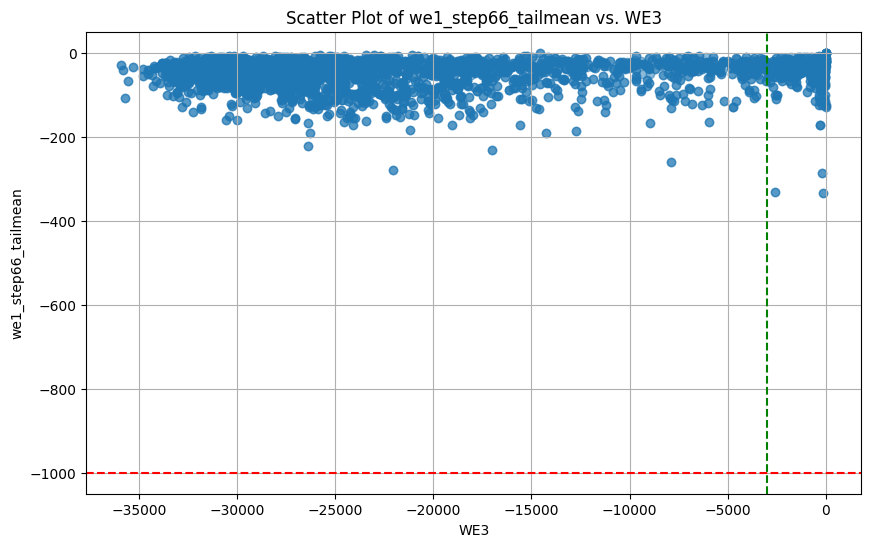

In [46]:
# Visualizing 'we1_step66_tailmean values as a function of WE4 values

plt.figure(figsize=(10, 6))
plt.scatter(df_fluA['WE3'], df_fluA['we1_step66_tailmean'], alpha=0.5)
plt.xlabel('WE3')
plt.ylabel('we1_step66_tailmean')
plt.title('Scatter Plot of we1_step66_tailmean vs. WE3')
# horizontal line at -1000
plt.axhline(y=-1000, color='r', linestyle='--')
# vertical line at -3000
plt.axvline(x=-3000, color='g', linestyle='--')
plt.grid(True)
plt.show()

In [47]:
# drop duplicated

df_fluA_filtered = df_fluA.drop_duplicates()

df_fluA_filtered.shape

(4981, 170)

In [48]:
# Building df_analysis forlater analysis work

# Use a clean copy of the data
df_analysis = df_fluA.copy()  # or df_cov_filtered, depending on the dataset

# Ensure the column exists and drop NA only for the analysis
df_analysis = df_analysis[df_analysis['we1_step66_tailmean'].notna()]




In [49]:
# Binning the WE1 precheck data

col = "we1_step66_tailmean"
data = df_fluA_filtered[col].dropna()

# Define your bins and labels
bins = [float("-inf"), -1000, -500, -300, -150, -70, 0, float("inf")]
labels = [
    "< -1000",
    "-1000 to -501",
    "-500 to -301",
    "-300 to -151",
    "-150 to -71",
    "-70 to 0",
    "> 0"
]

# Apply binning
binned = pd.cut(data, bins=bins, labels=labels, include_lowest=True)
summary = binned.value_counts().sort_index().reset_index()
summary.columns = ["bin_range", "count"]

# Add percentages
summary["percent"] = (summary["count"] / summary["count"].sum() * 100).round(2)

print(summary)


       bin_range  count  percent
0        < -1000      0     0.00
1  -1000 to -501      0     0.00
2   -500 to -301      4     0.08
3   -300 to -151     68     1.37
4    -150 to -71    943    18.93
5       -70 to 0   3966    79.62
6            > 0      0     0.00


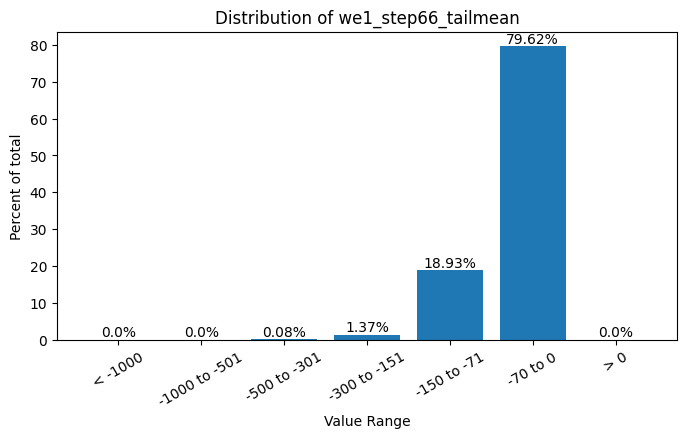

In [50]:
# Visualizing the bins

plt.figure(figsize=(8,4))
plt.bar(summary["bin_range"], summary["percent"])
plt.title(f"Distribution of {col}")
plt.xlabel("Value Range")
plt.ylabel("Percent of total")
plt.xticks(rotation=30)
# Annotating percentage above each bar
for i, v in enumerate(summary["percent"]):
    plt.text(i, v, f"{v}%", ha="center", va="bottom")
plt.show()


In [51]:
# Looking at WE1, WE2, WE3, WE4, WE5, and WE6 values of my individual bins

# Add the binned data as a new column to df_fluA_filtered
df_fluA_filtered['we1_bins'] = binned

# Group by the created bins and describe the WE columns
we_analysis = df_fluA_filtered.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].describe()
display(we_analysis)

WE1                                                        \
                count          mean          std      min      25%      50%   
we1_bins                                                                      
< -1000           0.0           NaN          NaN      NaN      NaN      NaN   
-1000 to -501     0.0           NaN          NaN      NaN      NaN      NaN   
-500 to -301      4.0  -8240.000000  7790.764532 -14987.0 -14987.0  -8240.0   
-300 to -151     68.0 -13055.264706  5814.235625 -30589.0 -16620.0 -13099.5   
-150 to -71     943.0 -14960.757158  5202.243776 -33081.0 -17976.0 -14981.0   
-70 to 0       3966.0 -17345.751891  6159.848349 -33082.0 -21557.5 -17633.0   
> 0               0.0           NaN          NaN      NaN      NaN      NaN   

                                   WE2              ...    WE5            WE6  \
                   75%     max   count        mean  ...    75%    max   count   
we1_bins                                            ...                         
< -1000            NaN     NaN     0.0         NaN  ...    NaN    NaN     0.0   
-1000 to -501      NaN     NaN     0.0         NaN  ...    NaN    NaN     0.0   
-500 to -301   -1493.0 -1493.0     4.0 -179.500000  ... -130.0 -130.0     4.0   
-300 to -151   -9780.0  -375.0    68.0 -145.705882  ... -109.0  -54.0    68.0   
-150 to -71   -12004.0     0.0   943.0 -199.527041  ...  -86.0    0.0   943.0   
-70 to 0      -13711.0     0.0  3966.0 -225.593797  ...  -70.0    0.0  3966.0   
> 0                NaN     NaN     0.0         NaN  ...    NaN    NaN     0.0   

                                                                              \
                       mean          std      min      25%      50%      75%   
we1_bins                                                                       
< -1000                 NaN          NaN      NaN      NaN      NaN      NaN   
-1000 to -501           NaN          NaN      NaN      NaN      NaN      NaN   
-500 to -301  -17318.500000  1643.716216 -18742.0 -18742.0 -17318.5 -15895.0   
-300 to -151  -15078.676471  3961.713362 -21566.0 -18226.0 -14991.5 -11788.0   
-150 to -71   -16236.235419  3379.337008 -26357.0 -18452.0 -16537.0 -14566.5   
-70 to 0      -15290.284670  3517.765340 -24972.0 -17573.5 -15401.5 -13218.0   
> 0                     NaN          NaN      NaN      NaN      NaN      NaN   

                        
                   max  
we1_bins                
< -1000            NaN  
-1000 to -501      NaN  
-500 to -301  -15895.0  
-300 to -151   -5682.0  
-150 to -71        0.0  
-70 to 0           0.0  
> 0                NaN  

[7 rows x 48 columns]

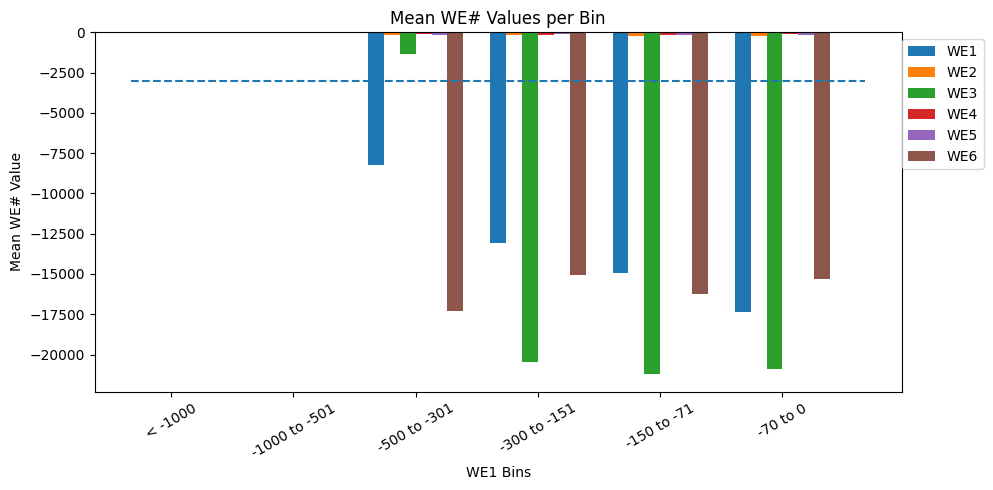

In [52]:
import matplotlib.pyplot as plt
import numpy as np

we_means = df_fluA_filtered.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].mean()
we_means = we_means.reindex(labels)  # ensure correct bin order

bins = we_means.index
we_cols = we_means.columns
x = np.arange(len(bins))  # the label locations
width = 0.13  # width of each bar

plt.figure(figsize=(10,5))
for i, col in enumerate(we_cols):
    plt.bar(x + i*width, we_means[col], width=width, label=col)

plt.xticks(x + width*2.5, bins, rotation=30)
plt.ylabel("Mean WE# Value")
plt.xlabel("WE1 Bins")
plt.title("Mean WE# Values per Bin")
plt.legend(title="WE#")
plt.legend(bbox_to_anchor=(1.11, 1), loc='upper right')
plt.hlines(y=-3000, xmin=x.min(), xmax=x.max(), linestyles='dashed')
plt.tight_layout()
plt.show()


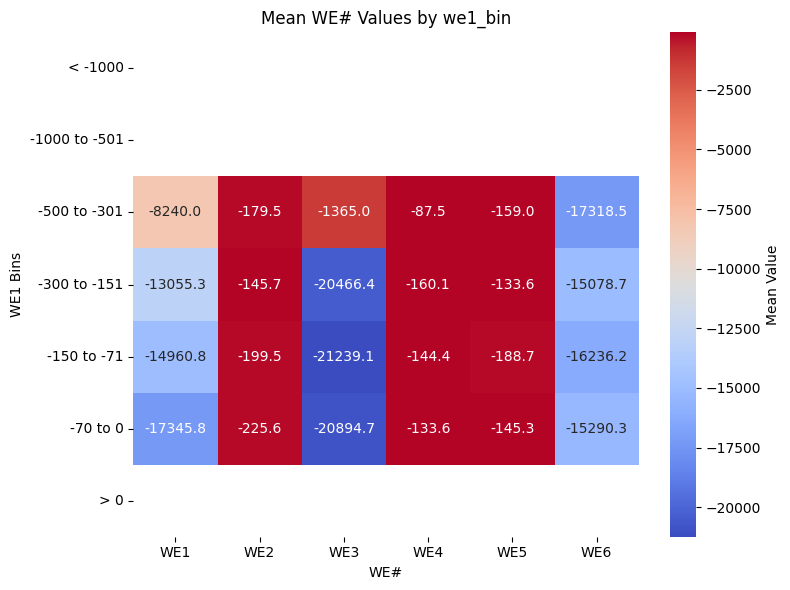

In [53]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(we_means, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Mean Value'})
plt.title("Mean WE# Values by we1_bin")
plt.ylabel("WE1 Bins")
plt.xlabel("WE#")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [54]:
import pandas as pd

# 1️⃣ Compute mean WE values per bin
we_means = df_fluA_filtered.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].mean()

# Ensure bins are in the correct order
we_means = we_means.reindex(labels)

# 2️⃣ Count samples per bin
bin_counts = df_fluA_filtered['we1_bins'].value_counts().reindex(labels)
bin_counts.name = "count"

# 3️⃣ Identify the control bin
control_bin = "-70 to 0"
control_values = we_means.loc[control_bin]

# 4️⃣ Compute Delta_WE# relative to control
delta_cols = {col: f"Delta_{col}" for col in we_means.columns}
delta_values = we_means - control_values
delta_values.rename(columns=delta_cols, inplace=True)

# 5️⃣ Combine counts, means, and deltas into one summary DataFrame
summary_df = pd.concat([bin_counts, we_means, delta_values], axis=1).reset_index()
summary_df.rename(columns={"we1_bins": "bin_range"}, inplace=True)

# 6️⃣ Format numeric columns to 1 decimal place
we_cols = ['WE1','WE2','WE3','WE4','WE5','WE6']
delta_cols = [f"Delta_{col}" for col in we_cols]
summary_df[we_cols + delta_cols] = summary_df[we_cols + delta_cols].round(1)

# 7️⃣ Display the table
display(summary_df)


bin_range  count      WE1    WE2      WE3    WE4    WE5      WE6  \
0        < -1000      0      NaN    NaN      NaN    NaN    NaN      NaN   
1  -1000 to -501      0      NaN    NaN      NaN    NaN    NaN      NaN   
2   -500 to -301      4  -8240.0 -179.5  -1365.0  -87.5 -159.0 -17318.5   
3   -300 to -151     68 -13055.3 -145.7 -20466.4 -160.1 -133.6 -15078.7   
4    -150 to -71    943 -14960.8 -199.5 -21239.1 -144.4 -188.7 -16236.2   
5       -70 to 0   3966 -17345.8 -225.6 -20894.7 -133.6 -145.3 -15290.3   
6            > 0      0      NaN    NaN      NaN    NaN    NaN      NaN   

   Delta_WE1  Delta_WE2  Delta_WE3  Delta_WE4  Delta_WE5  Delta_WE6  
0        NaN        NaN        NaN        NaN        NaN        NaN  
1        NaN        NaN        NaN        NaN        NaN        NaN  
2     9105.8       46.1    19529.7       46.1      -13.7    -2028.2  
3     4290.5       79.9      428.2      -26.5       11.7      211.6  
4     2385.0       26.1     -344.4      -10.8      -43.4     -946.0  
5        0.0        0.0        0.0        0.0        0.0        0.0  
6        NaN        NaN        NaN        NaN        NaN        NaN

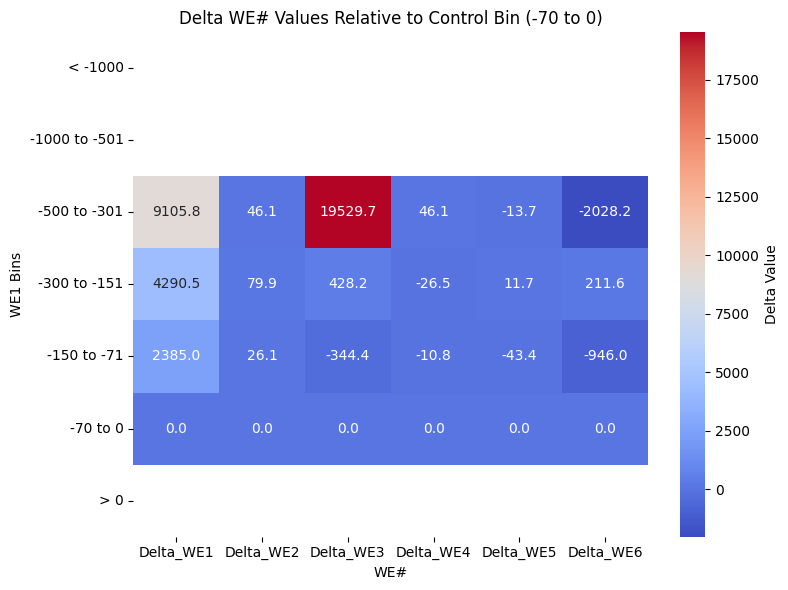

In [55]:
# Plot the Delta WE's

delta_only = summary_df.set_index('bin_range')[delta_cols]

plt.figure(figsize=(8,6))
sns.heatmap(delta_only, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Delta Value'})
plt.title("Delta WE# Values Relative to Control Bin (-70 to 0)")
plt.ylabel("WE1 Bins")
plt.xlabel("WE#")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [56]:
import pandas as pd
import numpy as np

# --- 1️⃣ Compute mean WE values per bin ---
we_means = df_fluA_filtered.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].mean()
we_means = we_means.reindex(labels)

# --- 2️⃣ Count samples per bin ---
bin_counts = df_fluA_filtered['we1_bins'].value_counts().reindex(labels)
bin_counts.name = "count"

# --- 3️⃣ Identify control bin ---
control_bin = "-70 to 0"
control_values = we_means.loc[control_bin]

# --- 4️⃣ Compute ΔWE relative to control ---
delta_cols = {col: f"Delta_{col}" for col in we_means.columns}
delta_values = we_means - control_values
delta_values.rename(columns=delta_cols, inplace=True)

# --- 5️⃣ Cartridge-level status determination ---
def classify_status(row):
    """Return Valid/Invalid based on warnings/errors presence."""
    has_issue = False
    for col in ['Warnings', 'Errors']:
        if col in row and pd.notna(row[col]) and str(row[col]).strip():
            has_issue = True
            break
    return "Invalid" if has_issue else "Valid"

df_fluA_filtered['status'] = df_fluA_filtered.apply(classify_status, axis=1)

# --- 6️⃣ Define helper flags (FN, WE2_FP, WE5_FP) ---
# Assuming these flags are boolean or identifiable by name in columns:
for flag in ['FN', 'WE2_FP', 'WE5_FP']:
    if flag not in df_fluA_filtered.columns:
        df_fluA_filtered[flag] = False  # ensure column exists

# --- 7️⃣ Compute percentages per bin ---
def compute_percentages(group):
    n = len(group)
    valid = (group['status'] == 'Valid').sum()
    invalid = (group['status'] == 'Invalid').sum()
    fn = group['FN'].sum()
    we2_fp = group['WE2_FP'].sum()
    we5_fp = group['WE5_FP'].sum()
    return pd.Series({
        '% Valid': 100 * valid / n if n else np.nan,
        '% Invalid': 100 * invalid / n if n else np.nan,
        '% FN': 100 * fn / n if n else np.nan,
        '% WE2 FP': 100 * we2_fp / n if n else np.nan,
        '% WE5 FP': 100 * we5_fp / n if n else np.nan
    })

percentages = df_fluA_filtered.groupby('we1_bins').apply(compute_percentages).reindex(labels)

# --- 8️⃣ Combine all results into one summary table ---
summary_df = pd.concat([bin_counts, we_means, delta_values, percentages], axis=1).reset_index()
summary_df.rename(columns={"we1_bins": "bin_range"}, inplace=True)

# --- 9️⃣ Format numeric columns to 1 decimal place ---
we_cols = ['WE1','WE2','WE3','WE4','WE5','WE6']
delta_cols = [f"Delta_{col}" for col in we_cols]
summary_df[we_cols + delta_cols] = summary_df[we_cols + delta_cols].round(1)
summary_df[['% Valid', '% Invalid', '% FN', '% WE2 FP', '% WE5 FP']] = \
    summary_df[['% Valid', '% Invalid', '% FN', '% WE2 FP', '% WE5 FP']].round(1)

# --- 🔟 Display the final summary ---
display(summary_df)


bin_range  count      WE1    WE2      WE3    WE4    WE5      WE6  \
0        < -1000      0      NaN    NaN      NaN    NaN    NaN      NaN   
1  -1000 to -501      0      NaN    NaN      NaN    NaN    NaN      NaN   
2   -500 to -301      4  -8240.0 -179.5  -1365.0  -87.5 -159.0 -17318.5   
3   -300 to -151     68 -13055.3 -145.7 -20466.4 -160.1 -133.6 -15078.7   
4    -150 to -71    943 -14960.8 -199.5 -21239.1 -144.4 -188.7 -16236.2   
5       -70 to 0   3966 -17345.8 -225.6 -20894.7 -133.6 -145.3 -15290.3   
6            > 0      0      NaN    NaN      NaN    NaN    NaN      NaN   

   Delta_WE1  Delta_WE2  Delta_WE3  Delta_WE4  Delta_WE5  Delta_WE6  % Valid  \
0        NaN        NaN        NaN        NaN        NaN        NaN      NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN      NaN   
2     9105.8       46.1    19529.7       46.1      -13.7    -2028.2    100.0   
3     4290.5       79.9      428.2      -26.5       11.7      211.6     94.1   
4     2385.0       26.1     -344.4      -10.8      -43.4     -946.0     92.2   
5        0.0        0.0        0.0        0.0        0.0        0.0     92.3   
6        NaN        NaN        NaN        NaN        NaN        NaN      NaN   

   % Invalid   % FN  % WE2 FP  % WE5 FP  
0        NaN    NaN       NaN       NaN  
1        NaN    NaN       NaN       NaN  
2        0.0  100.0       0.0       0.0  
3        5.9    5.9       0.0       0.0  
4        7.8    7.7       0.2       0.6  
5        7.7   13.6       0.7       0.4  
6        NaN    NaN       NaN       NaN

In [57]:
# --- 11️⃣ Deep dive: failure modes among Invalid samples ---

def compute_invalid_overlap(group):
    invalid_group = group[group['status'] == 'Invalid']
    n_invalid = len(invalid_group)
    if n_invalid == 0:
        return pd.Series({
            'Invalid_with_FN': 0,
            'Invalid_with_WE2_FP': 0,
            'Invalid_with_WE5_FP': 0,
            '% Invalid_with_FN': np.nan,
            '% Invalid_with_WE2_FP': np.nan,
            '% Invalid_with_WE5_FP': np.nan
        })
    return pd.Series({
        'Invalid_with_FN': invalid_group['FN'].sum(),
        'Invalid_with_WE2_FP': invalid_group['WE2_FP'].sum(),
        'Invalid_with_WE5_FP': invalid_group['WE5_FP'].sum(),
        '% Invalid_with_FN': 100 * invalid_group['FN'].sum() / n_invalid,
        '% Invalid_with_WE2_FP': 100 * invalid_group['WE2_FP'].sum() / n_invalid,
        '% Invalid_with_WE5_FP': 100 * invalid_group['WE5_FP'].sum() / n_invalid
    })

invalid_overlap = (
    df_fluA_filtered.groupby('we1_bins')
    .apply(compute_invalid_overlap)
    .reindex(labels)
)

# --- 12️⃣ Combine with main summary ---
summary_df_detailed = pd.concat([summary_df.set_index('bin_range'), invalid_overlap], axis=1).reset_index()

# --- 13️⃣ Round numeric values ---
cols_to_round = [
    '% Invalid_with_FN', '% Invalid_with_WE2_FP', '% Invalid_with_WE5_FP'
]
summary_df_detailed[cols_to_round] = summary_df_detailed[cols_to_round].round(1)

#--------Columns to keep-------------
summary_df_detailed_filtered = summary_df_detailed[['index',
 'count',
 '% Valid',
 '% Invalid',
 '% FN',
 '% WE2 FP',
 '% WE5 FP',
 'Invalid_with_FN',
 'Invalid_with_WE2_FP',
 'Invalid_with_WE5_FP',
 '% Invalid_with_FN',
 '% Invalid_with_WE2_FP',
 '% Invalid_with_WE5_FP'
]]


# --- 14️⃣ Display the enhanced table ---
display(summary_df_detailed_filtered)


index  count  % Valid  % Invalid   % FN  % WE2 FP  % WE5 FP  \
0        < -1000      0      NaN        NaN    NaN       NaN       NaN   
1  -1000 to -501      0      NaN        NaN    NaN       NaN       NaN   
2   -500 to -301      4    100.0        0.0  100.0       0.0       0.0   
3   -300 to -151     68     94.1        5.9    5.9       0.0       0.0   
4    -150 to -71    943     92.2        7.8    7.7       0.2       0.6   
5       -70 to 0   3966     92.3        7.7   13.6       0.7       0.4   
6            > 0      0      NaN        NaN    NaN       NaN       NaN   

   Invalid_with_FN  Invalid_with_WE2_FP  Invalid_with_WE5_FP  \
0              0.0                  0.0                  0.0   
1              0.0                  0.0                  0.0   
2              0.0                  0.0                  0.0   
3              2.0                  0.0                  0.0   
4             18.0                  0.0                  0.0   
5            100.0                  6.0                  4.0   
6              0.0                  0.0                  0.0   

   % Invalid_with_FN  % Invalid_with_WE2_FP  % Invalid_with_WE5_FP  
0                NaN                    NaN                    NaN  
1                NaN                    NaN                    NaN  
2                NaN                    NaN                    NaN  
3               50.0                    0.0                    0.0  
4               24.3                    0.0                    0.0  
5               32.6                    2.0                    1.3  
6                NaN                    NaN                    NaN

In [58]:
# --- Deep dive: failure flags that are Invalid ---

def compute_flag_invalid_overlap(group):
    fn_total = group['FN'].sum()
    we2_total = group['WE2_FP'].sum()
    we5_total = group['WE5_FP'].sum()

    fn_invalid = group.loc[group['FN'] & (group['status'] == 'Invalid')].shape[0]
    we2_invalid = group.loc[group['WE2_FP'] & (group['status'] == 'Invalid')].shape[0]
    we5_invalid = group.loc[group['WE5_FP'] & (group['status'] == 'Invalid')].shape[0]

    return pd.Series({
        'FN_total': fn_total,
        'FN_invalid': fn_invalid,
        '% FN_invalid': 100 * fn_invalid / fn_total if fn_total else np.nan,
        'WE2_FP_total': we2_total,
        'WE2_FP_invalid': we2_invalid,
        '% WE2_FP_invalid': 100 * we2_invalid / we2_total if we2_total else np.nan,
        'WE5_FP_total': we5_total,
        'WE5_FP_invalid': we5_invalid,
        '% WE5_FP_invalid': 100 * we5_invalid / we5_total if we5_total else np.nan,
    })

flag_invalid_overlap = (
    df_fluA_filtered.groupby('we1_bins')
    .apply(compute_flag_invalid_overlap)
    .reindex(labels)
)

# --- Combine into your summary ---
summary_df_detailed = pd.concat([summary_df.set_index('bin_range'), flag_invalid_overlap], axis=1).reset_index()

# --- Round percentage columns ---
pct_cols = ['% FN_invalid', '% WE2_FP_invalid', '% WE5_FP_invalid']
summary_df_detailed[pct_cols] = summary_df_detailed[pct_cols].round(1)


#---------Filtering to desired columns------
summary_df_detailed_filtered = summary_df_detailed[['index',
 'count',
 '% Valid',
 '% Invalid',
 '% FN',
 '% WE2 FP',
 '% WE5 FP',
 '% FN_invalid', '% WE2_FP_invalid', '% WE5_FP_invalid'
]]

display(summary_df_detailed_filtered)


index  count  % Valid  % Invalid   % FN  % WE2 FP  % WE5 FP  \
0        < -1000      0      NaN        NaN    NaN       NaN       NaN   
1  -1000 to -501      0      NaN        NaN    NaN       NaN       NaN   
2   -500 to -301      4    100.0        0.0  100.0       0.0       0.0   
3   -300 to -151     68     94.1        5.9    5.9       0.0       0.0   
4    -150 to -71    943     92.2        7.8    7.7       0.2       0.6   
5       -70 to 0   3966     92.3        7.7   13.6       0.7       0.4   
6            > 0      0      NaN        NaN    NaN       NaN       NaN   

   % FN_invalid  % WE2_FP_invalid  % WE5_FP_invalid  
0           NaN               NaN               NaN  
1           NaN               NaN               NaN  
2           0.0               NaN               NaN  
3          50.0               NaN               NaN  
4          24.7               0.0               0.0  
5          18.6              23.1              28.6  
6           NaN               NaN               NaN

In [59]:
import pandas as pd
import numpy as np

# -------------------------------
# 1️⃣ Define continuous thresholds
# -------------------------------
thresholds = list(range(-50, -1025, -25))  # -50, -325, ..., -1000
thresholds.append(-999999)  # catch ≤ -1000
threshold_labels = [str(t) if t != -999999 else "≤ -1000" for t in thresholds]

# -------------------------------
# 2️⃣ Ensure status and FP/FN columns exist
# -------------------------------
def classify_status(row):
    """Return Valid/Invalid based on Warnings/Errors presence."""
    for col in ['Warnings', 'Errors']:
        if col in row and pd.notna(row[col]) and str(row[col]).strip():
            return "Invalid"
    return "Valid"

df_analysis['status'] = df_analysis.apply(classify_status, axis=1)

for flag in ['FN', 'WE2_FP', 'WE5_FP']:
    if flag not in df_analysis.columns:
        df_analysis[flag] = False

# -------------------------------
# 3️⃣ Loop through thresholds
# -------------------------------
results = []

for i, t in enumerate(thresholds):
    label = threshold_labels[i]

    # Subset for this threshold
    if t == -999999:
        subset = df_analysis[df_analysis['we1_step66_tailmean'] <= -1000]
    else:
        subset = df_analysis[df_analysis['we1_step66_tailmean'] <= t]

    if subset.empty:
        continue

    n = len(subset)

    # Valid / Invalid counts
    valid = (subset['status'] == 'Valid').sum()
    invalid = (subset['status'] == 'Invalid').sum()

    # FN / FP totals
    fn_total = subset['FN'].sum()
    we2_total = subset['WE2_FP'].sum()
    we5_total = subset['WE5_FP'].sum()

    # FN / FP also invalid
    fn_invalid = subset.loc[subset['FN'] & (subset['status'] == 'Invalid')].shape[0]
    we2_invalid = subset.loc[subset['WE2_FP'] & (subset['status'] == 'Invalid')].shape[0]
    we5_invalid = subset.loc[subset['WE5_FP'] & (subset['status'] == 'Invalid')].shape[0]

    # Append results
    results.append({
        'Threshold': label,
        'Count': n,
        '% Valid': 100 * valid / n,
        '% Invalid': 100 * invalid / n,
        '% FN': 100 * fn_total / n,
        '% WE2 FP': 100 * we2_total / n,
        '% WE5 FP': 100 * we5_total / n,
        'FN_total': fn_total,
        'FN_invalid': fn_invalid,
        '% FN_invalid': 100 * fn_invalid / fn_total if fn_total else np.nan,
        'WE2_FP_total': we2_total,
        'WE2_FP_invalid': we2_invalid,
        '% WE2_FP_invalid': 100 * we2_invalid / we2_total if we2_total else np.nan,
        'WE5_FP_total': we5_total,
        'WE5_FP_invalid': we5_invalid,
        '% WE5_FP_invalid': 100 * we5_invalid / we5_total if we5_total else np.nan
    })

# -------------------------------
# 4️⃣ Convert to DataFrame
# -------------------------------
threshold_summary_df = pd.DataFrame(results)

# Round percentages
pct_cols = [col for col in threshold_summary_df.columns if col.startswith('%')]
threshold_summary_df[pct_cols] = threshold_summary_df[pct_cols].round(1)

# -------------------------------
# 5️⃣ Optional: filter columns
# -------------------------------
threshold_summary_df_filtered_fluA = threshold_summary_df[[
    'Threshold', 'Count', '% Valid', '% Invalid', '% FN', '% WE2 FP', '% WE5 FP',
    'FN_total', 'FN_invalid', '% FN_invalid',
    'WE2_FP_total', 'WE2_FP_invalid', '% WE2_FP_invalid',
    'WE5_FP_total', 'WE5_FP_invalid', '% WE5_FP_invalid'
]]

# -------------------------------
# 6️⃣ Display
# -------------------------------
display(threshold_summary_df_filtered_fluA)


Threshold  Count  % Valid  % Invalid   % FN  % WE2 FP  % WE5 FP  FN_total  \
0        -50   1808     91.8        8.2    9.5       0.4       0.4       172   
1        -75    938     91.6        8.4    7.9       0.2       0.6        74   
2       -100    443     90.1        9.9    8.6       0.0       0.0        38   
3       -125    170     95.9        4.1    8.8       0.0       0.0        15   
4       -150     73     93.2        6.8   12.3       0.0       0.0         9   
5       -175     22    100.0        0.0   27.3       0.0       0.0         6   
6       -200     14    100.0        0.0   42.9       0.0       0.0         6   
7       -225     12    100.0        0.0   50.0       0.0       0.0         6   
8       -250     10    100.0        0.0   60.0       0.0       0.0         6   
9       -275      8    100.0        0.0   75.0       0.0       0.0         6   
10      -300      4    100.0        0.0  100.0       0.0       0.0         4   
11      -325      4    100.0        0.0  100.0       0.0       0.0         4   

    FN_invalid  % FN_invalid  WE2_FP_total  WE2_FP_invalid  % WE2_FP_invalid  \
0           41          23.8             8               0               0.0   
1           19          25.7             2               0               0.0   
2           11          28.9             0               0               NaN   
3            5          33.3             0               0               NaN   
4            3          33.3             0               0               NaN   
5            0           0.0             0               0               NaN   
6            0           0.0             0               0               NaN   
7            0           0.0             0               0               NaN   
8            0           0.0             0               0               NaN   
9            0           0.0             0               0               NaN   
10           0           0.0             0               0               NaN   
11           0           0.0             0               0               NaN   

    WE5_FP_total  WE5_FP_invalid  % WE5_FP_invalid  
0              8               0               0.0  
1              6               0               0.0  
2              0               0               NaN  
3              0               0               NaN  
4              0               0               NaN  
5              0               0               NaN  
6              0               0               NaN  
7              0               0               NaN  
8              0               0               NaN  
9              0               0               NaN  
10             0               0               NaN  
11             0               0               NaN

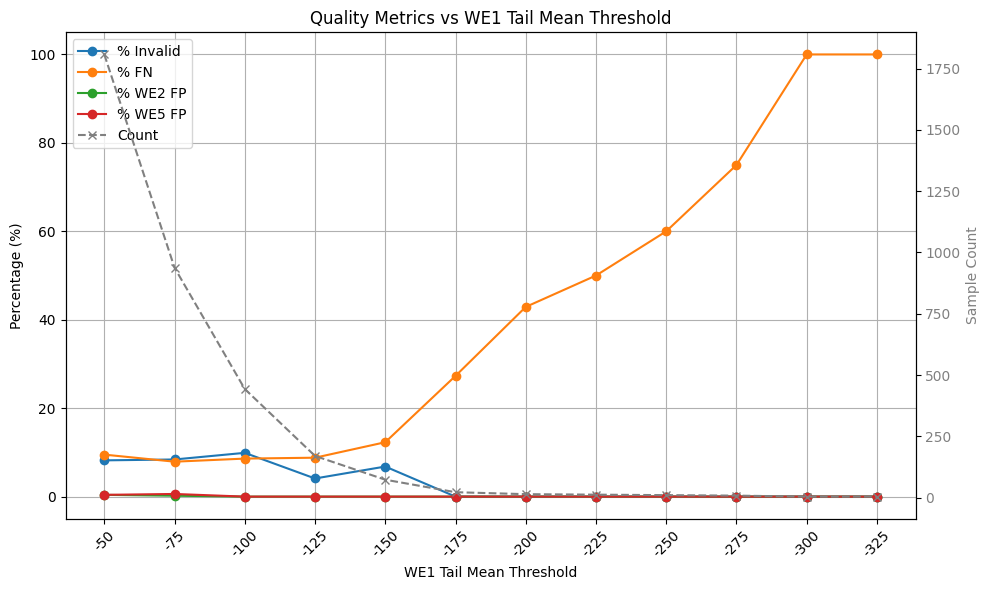

In [60]:
import matplotlib.pyplot as plt

# Create the figure and main axis
fig, ax1 = plt.subplots(figsize=(10,6))

# --- Primary y-axis: Percentages ---
ax1.plot(threshold_summary_df_filtered_fluA['Threshold'], threshold_summary_df_filtered_fluA['% Invalid'], marker='o', label='% Invalid')
ax1.plot(threshold_summary_df_filtered_fluA['Threshold'], threshold_summary_df_filtered_fluA['% FN'], marker='o', label='% FN')
ax1.plot(threshold_summary_df_filtered_fluA['Threshold'], threshold_summary_df_filtered_fluA['% WE2 FP'], marker='o', label='% WE2 FP')
ax1.plot(threshold_summary_df_filtered_fluA['Threshold'], threshold_summary_df_filtered_fluA['% WE5 FP'], marker='o', label='% WE5 FP')

ax1.set_xlabel('WE1 Tail Mean Threshold')
ax1.set_ylabel('Percentage (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(threshold_summary_df_filtered_fluA['Threshold'], rotation=45)
ax1.grid(True)

# --- Secondary y-axis: Count overlay ---
ax2 = ax1.twinx()
ax2.plot(threshold_summary_df_filtered_fluA['Threshold'], threshold_summary_df_filtered_fluA['Count'],
         color='gray', linestyle='--', marker='x', label='Count')
ax2.set_ylabel('Sample Count', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# --- Combine legends ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Title and layout
plt.title('Quality Metrics vs WE1 Tail Mean Threshold')
plt.tight_layout()
plt.show()


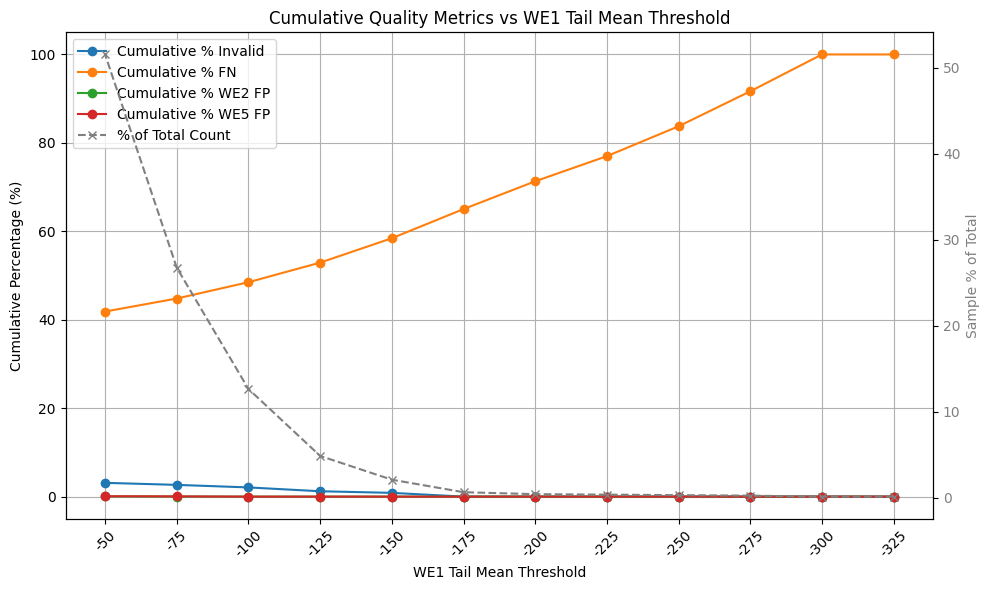

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Create a copy to avoid modifying the original ---
df = threshold_summary_df_filtered_fluA.copy()

# --- Extract numeric threshold values (e.g. from "≤ -300" → -300.0) ---
def parse_threshold(x):
    if isinstance(x, str):
        x = x.replace('≤', '').strip()
    try:
        return float(x)
    except:
        return np.nan

df['Threshold_num'] = df['Threshold'].apply(parse_threshold)

# --- Sort thresholds numerically (least → most negative) ---
df = df.sort_values(by='Threshold_num', ascending=True)

# --- Compute cumulative percentages ---
df['cum_% Invalid'] = df['% Invalid'].cumsum() / np.arange(1, len(df) + 1)
df['cum_% FN'] = df['% FN'].cumsum() / np.arange(1, len(df) + 1)
df['cum_% WE2 FP'] = df['% WE2 FP'].cumsum() / np.arange(1, len(df) + 1)
df['cum_% WE5 FP'] = df['% WE5 FP'].cumsum() / np.arange(1, len(df) + 1)

# --- Convert Count to % of total ---
df['% Count'] = 100 * df['Count'] / df['Count'].sum()

# --- Create the figure and main axis ---
fig, ax1 = plt.subplots(figsize=(10,6))

# --- Primary y-axis: Cumulative Percentages ---
ax1.plot(df['Threshold_num'], df['cum_% Invalid'], marker='o', label='Cumulative % Invalid')
ax1.plot(df['Threshold_num'], df['cum_% FN'], marker='o', label='Cumulative % FN')
ax1.plot(df['Threshold_num'], df['cum_% WE2 FP'], marker='o', label='Cumulative % WE2 FP')
ax1.plot(df['Threshold_num'], df['cum_% WE5 FP'], marker='o', label='Cumulative % WE5 FP')

ax1.set_xlabel('WE1 Tail Mean Threshold')
ax1.set_ylabel('Cumulative Percentage (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(df['Threshold_num'])
ax1.set_xticklabels(df['Threshold'], rotation=45)
ax1.grid(True)

# --- Reverse the X-axis so least negative (-50) → most negative (-1000) ---
ax1.invert_xaxis()

# --- Secondary y-axis: % Count overlay ---
ax2 = ax1.twinx()
ax2.plot(df['Threshold_num'], df['% Count'], color='gray', linestyle='--', marker='x', label='% of Total Count')
ax2.set_ylabel('Sample % of Total', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# --- Combine legends ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# --- Title and layout ---
plt.title('Cumulative Quality Metrics vs WE1 Tail Mean Threshold')
plt.tight_layout()
plt.show()


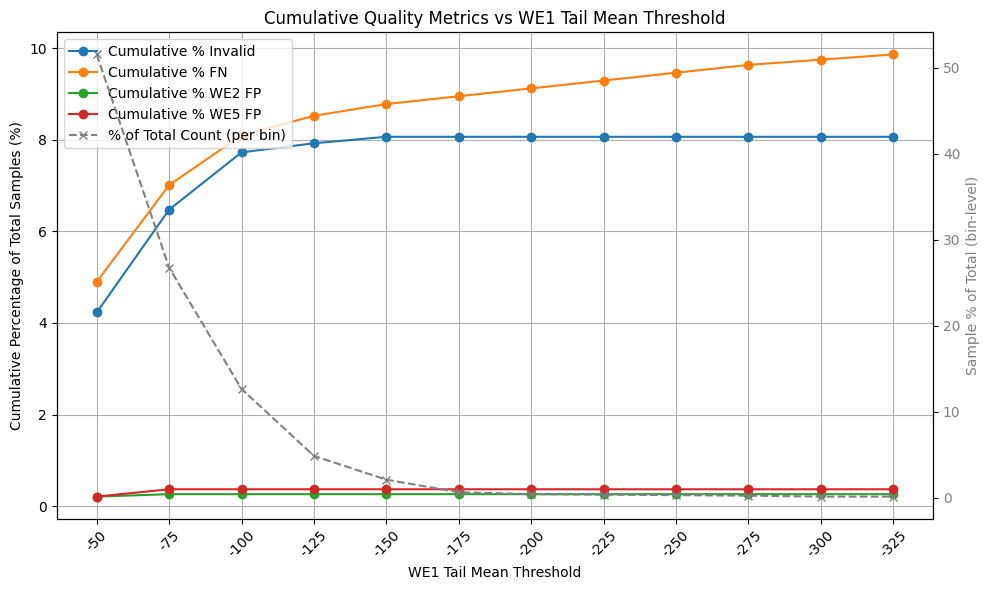

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Copy original ---
df = threshold_summary_df_filtered_fluA.copy()

# --- Parse numeric threshold values (handle labels like "≤ -1000") ---
def parse_threshold(x):
    if isinstance(x, str):
        x = x.replace('≤', '').strip()
    try:
        return float(x)
    except:
        return np.nan

df['Threshold_num'] = df['Threshold'].apply(parse_threshold)

# --- Sort thresholds numerically (least → most negative) ---
df = df.sort_values(by='Threshold_num', ascending=False)

# --- Convert Count to % of total ---
df['% Count'] = 100 * df['Count'] / df['Count'].sum()

# --- Compute cumulative sums ---
df['cum_Count'] = df['Count'].cumsum()
df['cum_Invalid'] = (df['% Invalid'] / 100 * df['Count']).cumsum()
df['cum_FN'] = (df['% FN'] / 100 * df['Count']).cumsum()
df['cum_WE2_FP'] = (df['% WE2 FP'] / 100 * df['Count']).cumsum()
df['cum_WE5_FP'] = (df['% WE5 FP'] / 100 * df['Count']).cumsum()

# --- Convert cumulative sums to percentages of total Count ---
total_count = df['Count'].sum()
df['cum_% Invalid'] = 100 * df['cum_Invalid'] / total_count
df['cum_% FN'] = 100 * df['cum_FN'] / total_count
df['cum_% WE2 FP'] = 100 * df['cum_WE2_FP'] / total_count
df['cum_% WE5 FP'] = 100 * df['cum_WE5_FP'] / total_count

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(10,6))

# --- Primary axis: cumulative metrics ---
ax1.plot(df['Threshold_num'], df['cum_% Invalid'], marker='o', label='Cumulative % Invalid')
ax1.plot(df['Threshold_num'], df['cum_% FN'], marker='o', label='Cumulative % FN')
ax1.plot(df['Threshold_num'], df['cum_% WE2 FP'], marker='o', label='Cumulative % WE2 FP')
ax1.plot(df['Threshold_num'], df['cum_% WE5 FP'], marker='o', label='Cumulative % WE5 FP')

ax1.set_xlabel('WE1 Tail Mean Threshold')
ax1.set_ylabel('Cumulative Percentage of Total Samples (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(df['Threshold_num'])
ax1.set_xticklabels(df['Threshold'], rotation=45)
ax1.grid(True)

# --- Reverse x-axis (least negative → most negative) ---
ax1.invert_xaxis()

# --- Secondary axis: % Count per threshold ---
ax2 = ax1.twinx()
ax2.plot(df['Threshold_num'], df['% Count'], color='gray', linestyle='--', marker='x', label='% of Total Count (per bin)')
ax2.set_ylabel('Sample % of Total (bin-level)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# --- Combine legends ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Cumulative Quality Metrics vs WE1 Tail Mean Threshold')
plt.tight_layout()
plt.show()


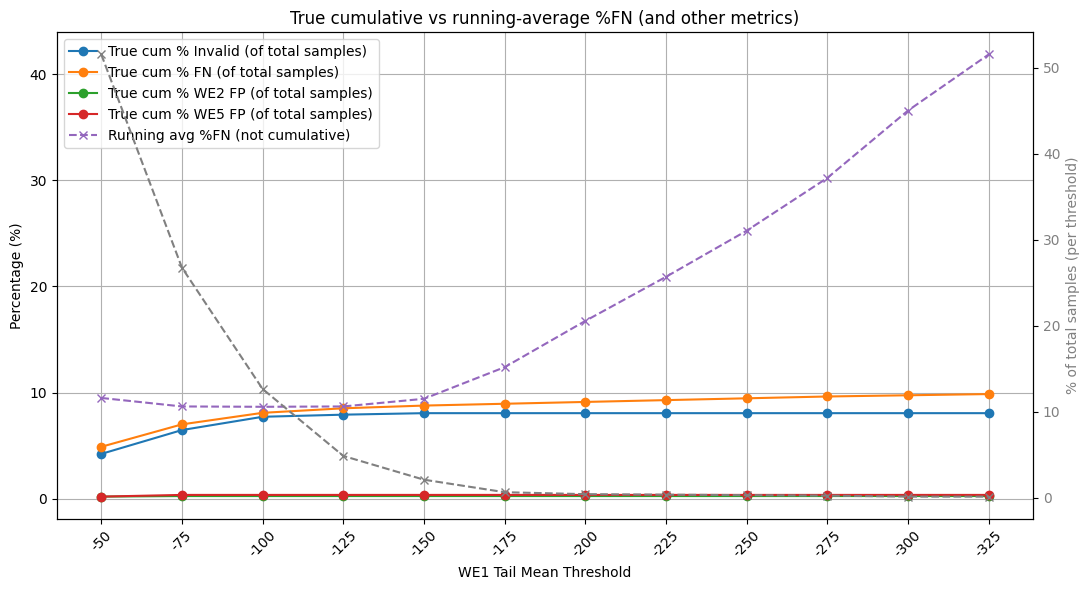

Threshold  Count   % Count  % FN  FN_count  cum_FN_count  cum_%FN_total Highlight_5pct
      -50   1808 51.568739   9.5   171.760       171.760       4.899030               
      -75    938 26.754136   7.9    74.102       245.862       7.012607               
     -100    443 12.635482   8.6    38.098       283.960       8.099258               
     -125    170  4.848831   8.8    14.960       298.920       8.525956     << 5% mark
     -150     73  2.082145  12.3     8.979       307.899       8.782059               
     -175     22  0.627496  27.3     6.006       313.905       8.953366               
     -200     14  0.399315  42.9     6.006       319.911       9.124672               
     -225     12  0.342270  50.0     6.000       325.911       9.295807               
     -250     10  0.285225  60.0     6.000       331.911       9.466942               
     -275      8  0.228180  75.0     6.000       337.911       9.638078               
     -300      4  0.114090 100.0     4.000 

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Copy source
df = threshold_summary_df_filtered_fluA.copy()

# Parse numeric thresholds (handle "≤ -1000" etc.)
def parse_threshold(x):
    if isinstance(x, str):
        x = x.replace('≤', '').strip()
    try:
        return float(x)
    except:
        return np.nan

df['Threshold_num'] = df['Threshold'].apply(parse_threshold)

# --- Ensure we only use rows with valid numeric threshold ---
df = df.dropna(subset=['Threshold_num']).copy()

# Sort in the natural accumulation order: least negative -> most negative
df = df.sort_values('Threshold_num', ascending=False).reset_index(drop=True)

# Ensure numeric columns
for col in ['Count', '% FN', '% Invalid', '% WE2 FP', '% WE5 FP']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Per-bin absolute counts of events (from percent and count)
df['FN_count']     = (df['% FN'] / 100.0) * df['Count']
df['Invalid_count']= (df['% Invalid'] / 100.0) * df['Count']
df['WE2FP_count']  = (df['% WE2 FP'] / 100.0) * df['Count']
df['WE5FP_count']  = (df['% WE5 FP'] / 100.0) * df['Count']

# Running-average style (not usually desired for accumulation)
df['running_avg_%FN'] = df['% FN'].cumsum() / np.arange(1, len(df) + 1)

# True cumulative totals (absolute) and convert to percent of total samples
total_samples = df['Count'].sum() if df['Count'].sum() else 1
df['cum_FN_count'] = df['FN_count'].cumsum()
df['cum_%FN_total'] = 100.0 * df['cum_FN_count'] / total_samples

# Also cum for Invalids / FPs
df['cum_Invalid_count'] = df['Invalid_count'].cumsum()
df['cum_%Invalid_total'] = 100.0 * df['cum_Invalid_count'] / total_samples
df['cum_WE2FP_count'] = df['WE2FP_count'].cumsum()
df['cum_%WE2FP_total'] = 100.0 * df['cum_WE2FP_count'] / total_samples
df['cum_WE5FP_count'] = df['WE5FP_count'].cumsum()
df['cum_%WE5FP_total'] = 100.0 * df['cum_WE5FP_count'] / total_samples

# Diagnostic: check monotonicity (should be non-decreasing)
def is_monotonic_nondec(series):
    return (np.diff(series) >= -1e-8).all()

monotonic_fn = is_monotonic_nondec(df['cum_%FN_total'].values)
if not monotonic_fn:
    print("WARNING: cum_%FN_total is not monotonic non-decreasing. Inspect 'FN_count' and ordering.")

# Add % Total Samples column (aka % Count)
df['% Count'] = 100.0 * df['Count'] / total_samples

# Add Highlight column for rows where % Count ~ 5% (±0.5%)
tolerance = 0.5
df['Highlight_5pct'] = df['% Count'].apply(lambda x: '<< 5% mark' if abs(x - 5.0) <= tolerance else '')

# --- Plot both versions for comparison ---
fig, ax = plt.subplots(figsize=(11,6))

# True cumulative proportions (preferred)
ax.plot(df['Threshold_num'], df['cum_%Invalid_total'], marker='o', label='True cum % Invalid (of total samples)')
ax.plot(df['Threshold_num'], df['cum_%FN_total'], marker='o', label='True cum % FN (of total samples)')
ax.plot(df['Threshold_num'], df['cum_%WE2FP_total'], marker='o', label='True cum % WE2 FP (of total samples)')
ax.plot(df['Threshold_num'], df['cum_%WE5FP_total'], marker='o', label='True cum % WE5 FP (of total samples)')

# Running-average lines (for reference)
ax.plot(df['Threshold_num'], df['running_avg_%FN'], marker='x', linestyle='--', label='Running avg %FN (not cumulative)')

# X axis labels
ax.set_xticks(df['Threshold_num'])
ax.set_xticklabels(df['Threshold'], rotation=45)
ax.invert_xaxis()  # show least negative -> most negative left->right
ax.set_xlabel('WE1 Tail Mean Threshold')
ax.set_ylabel('Percentage (%)')
ax.grid(True)
ax.legend(loc='upper left')

# Right axis: percent of samples per threshold (bin-level)
ax2 = ax.twinx()
ax2.plot(df['Threshold_num'], df['% Count'], color='gray', linestyle='--', marker='x', label='% of total (per threshold)')
ax2.set_ylabel('% of total samples (per threshold)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Show plot
plt.title('True cumulative vs running-average %FN (and other metrics)')
plt.tight_layout()
plt.show()

# Optional: print a small table for debugging with new columns
display_cols = ['Threshold', 'Count', '% Count', '% FN', 'FN_count', 'cum_FN_count', 'cum_%FN_total', 'Highlight_5pct']
print(df[display_cols].head(12).to_string(index=False))


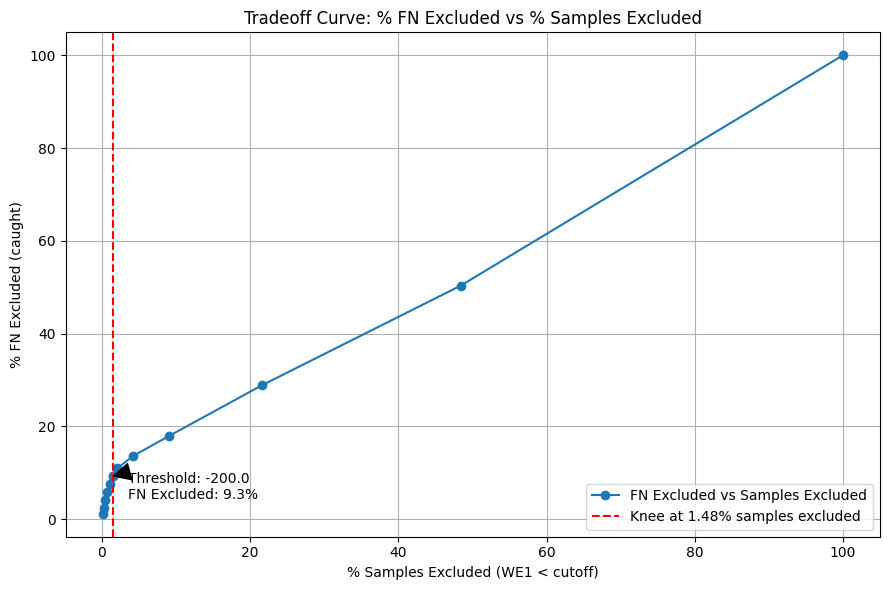

Recommended WE1 threshold cutoff: -200.0


Threshold  Count  % Valid  % Invalid  % FN  % WE2 FP  % WE5 FP  FN_total  \
0       -50   1808     91.8        8.2   9.5       0.4       0.4       172   
1       -75    938     91.6        8.4   7.9       0.2       0.6        74   
2      -100    443     90.1        9.9   8.6       0.0       0.0        38   
3      -125    170     95.9        4.1   8.8       0.0       0.0        15   
4      -150     73     93.2        6.8  12.3       0.0       0.0         9   
5      -175     22    100.0        0.0  27.3       0.0       0.0         6   
6      -200     14    100.0        0.0  42.9       0.0       0.0         6   
7      -225     12    100.0        0.0  50.0       0.0       0.0         6   
8      -250     10    100.0        0.0  60.0       0.0       0.0         6   
9      -275      8    100.0        0.0  75.0       0.0       0.0         6   

   FN_invalid  % FN_invalid  ...  % WE2_FP_invalid  WE5_FP_total  \
0          41          23.8  ...               0.0             8   
1          19          25.7  ...               0.0             6   
2          11          28.9  ...               NaN             0   
3           5          33.3  ...               NaN             0   
4           3          33.3  ...               NaN             0   
5           0           0.0  ...               NaN             0   
6           0           0.0  ...               NaN             0   
7           0           0.0  ...               NaN             0   
8           0           0.0  ...               NaN             0   
9           0           0.0  ...               NaN             0   

   WE5_FP_invalid  % WE5_FP_invalid  Threshold_num  FN_count  \
0               0               0.0          -50.0   171.760   
1               0               0.0          -75.0    74.102   
2               0               NaN         -100.0    38.098   
3               0               NaN         -125.0    14.960   
4               0               NaN         -150.0     8.979   
5               0               NaN         -175.0     6.006   
6               0               NaN         -200.0     6.006   
7               0               NaN         -225.0     6.000   
8               0               NaN         -250.0     6.000   
9               0               NaN         -275.0     6.000   

   samples_excluded  fn_excluded  % samples_excluded  % fn_excluded  
0              3506      345.911          100.000000     100.000000  
1              1698      174.151           48.431261      50.345609  
2               760      100.049           21.677125      28.923336  
3               317       61.951            9.041643      17.909520  
4               147       46.991            4.192812      13.584708  
5                74       38.012            2.110667      10.988954  
6                52       32.006            1.483172       9.252669  
7                38       26.000            1.083856       7.516384  
8                26       20.000            0.741586       5.781834  
9                16       14.000            0.456361       4.047284  

[10 rows x 22 columns]

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kneed import KneeLocator  # You'll need to install this package via pip

def analyze_we1_cutoff_tradeoff(threshold_df, threshold_col='Threshold', count_col='Count', fn_percent_col='% FN'):
    """
    Analyze tradeoff between sample exclusion and FN exclusion by WE1 threshold.
    Detect knee point to recommend cutoff.

    Parameters:
    - threshold_df: pd.DataFrame with threshold summary
    - threshold_col: column name with threshold labels
    - count_col: column with sample counts per threshold bin
    - fn_percent_col: column with % FN per threshold bin

    Returns:
    - recommended_cutoff: numeric threshold value at knee point
    - plot figure with annotated tradeoff curve
    - augmented DataFrame with cumulative stats and knee point info
    """
    df = threshold_summary_df_filtered_fluA.copy()

    # Parse numeric threshold (handle "≤ -1000" etc.)
    def parse_threshold(x):
        if isinstance(x, str):
            x = x.replace('≤', '').strip()
        try:
            return float(x)
        except:
            return np.nan

    df['Threshold_num'] = df[threshold_col].apply(parse_threshold)
    df = df.dropna(subset=['Threshold_num']).copy()

    # Sort descending (least negative -> most negative)
    df = df.sort_values('Threshold_num', ascending=False).reset_index(drop=True)

    # Ensure numeric columns
    for col in [count_col, fn_percent_col]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    total_samples = df[count_col].sum()
    total_fn = ((df[fn_percent_col] / 100) * df[count_col]).sum()

    # Calculate FN counts and cumulative sums (reversed for exclusion)
    df['FN_count'] = (df[fn_percent_col] / 100) * df[count_col]

    # Reverse cumulative sums (samples excluded and FN excluded if cutoff at each threshold)
    df['samples_excluded'] = df[count_col][::-1].cumsum()[::-1]
    df['fn_excluded'] = df['FN_count'][::-1].cumsum()[::-1]

    # Percents of totals
    df['% samples_excluded'] = 100 * df['samples_excluded'] / total_samples
    df['% fn_excluded'] = 100 * df['fn_excluded'] / total_fn

    # Detect knee/elbow point
    knee = KneeLocator(
        df['% samples_excluded'], df['% fn_excluded'],
        curve='convex', direction='increasing', S=2
    )
    knee_point = knee.knee

    # Get threshold value at knee if found
    if knee_point is not None:
        recommended_cutoff = df.loc[(df['% samples_excluded'] - knee_point).abs().idxmin(), 'Threshold_num']
    else:
        recommended_cutoff = None

    # Plot tradeoff curve with knee point annotated
    plt.figure(figsize=(9,6))
    plt.plot(df['% samples_excluded'], df['% fn_excluded'], marker='o', label='FN Excluded vs Samples Excluded')
    if knee_point is not None:
        plt.axvline(knee_point, color='red', linestyle='--', label=f'Knee at {knee_point:.2f}% samples excluded')
        knee_y = df.loc[(df['% samples_excluded'] - knee_point).abs().idxmin(), '% fn_excluded']
        plt.scatter(knee_point, knee_y, color='red')
        plt.annotate(f"Threshold: {recommended_cutoff}\nFN Excluded: {knee_y:.1f}%",
                     xy=(knee_point, knee_y), xytext=(knee_point+2, knee_y-5),
                     arrowprops=dict(facecolor='black', shrink=0.05))
    plt.xlabel('% Samples Excluded (WE1 < cutoff)')
    plt.ylabel('% FN Excluded (caught)')
    plt.title('Tradeoff Curve: % FN Excluded vs % Samples Excluded')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return recommended_cutoff, df


recommended_cutoff, augmented_df = analyze_we1_cutoff_tradeoff(threshold_summary_df_filtered_fluA)
print(f"Recommended WE1 threshold cutoff: {recommended_cutoff}")
display(augmented_df.head(10))


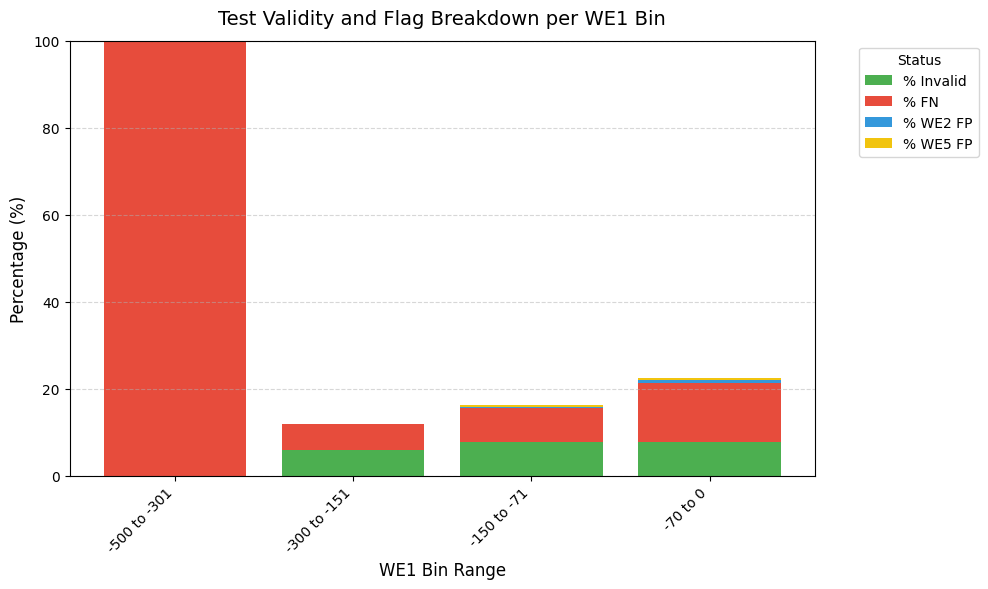

In [65]:
import matplotlib.pyplot as plt

# --- Plot: Stacked bar of outcome percentages per bin ---
fig, ax = plt.subplots(figsize=(10, 6))

# Define category columns to plot
plot_cols = ['% Invalid', '% FN', '% WE2 FP', '% WE5 FP']
colors = ['#4CAF50', '#E74C3C', '#3498DB', '#F1C40F', '#9B59B6']  # nice clean palette

bottom = np.zeros(len(summary_df))
for col, color in zip(plot_cols, colors):
    ax.bar(summary_df['bin_range'], summary_df[col], bottom=bottom, label=col, color=color)
    bottom += summary_df[col].values

# Aesthetics
ax.set_title("Test Validity and Flag Breakdown per WE1 Bin", fontsize=14, pad=12)
ax.set_xlabel("WE1 Bin Range", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_ylim(0, 100)
ax.legend(title="Status", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Raw summary:
Total rows in df_raw: 4981
Column 'we1_step66_tailmean' present? True
Non-null values in 'we1_step66_tailmean': 4981
FN total from raw data (sum of `FN`): 619

Counts per bin (including NaN):
                  count
_tmp_bin               
-50 to 0_or_more   3248
-75 to -51          839
-100 to -76         471
-125 to -101        256
-150 to -126         95
-175 to -151         50
-200 to -176          8
<-325                 4
-300 to -276          4
-275 to -251          2
-250 to -226          2
-225 to -201          2
-325 to -301          0

Number of rows with NaN bin (not placed into any bin): 0

Total FN in raw data: 619
Total FN in binned (non-NaN) data: 619
Total rows in raw: 4981, total rows placed in bins: 4981

Binned summary (sorted least negative → most negative):
        _tmp_bin  Count   % Count       % FN  FN_count  cum_FN_count  cum_%FN_total
-50 to 0_or_more   3248 65.207790  13.885468       451           451       9.054407
      -75 to -51    839 16.84

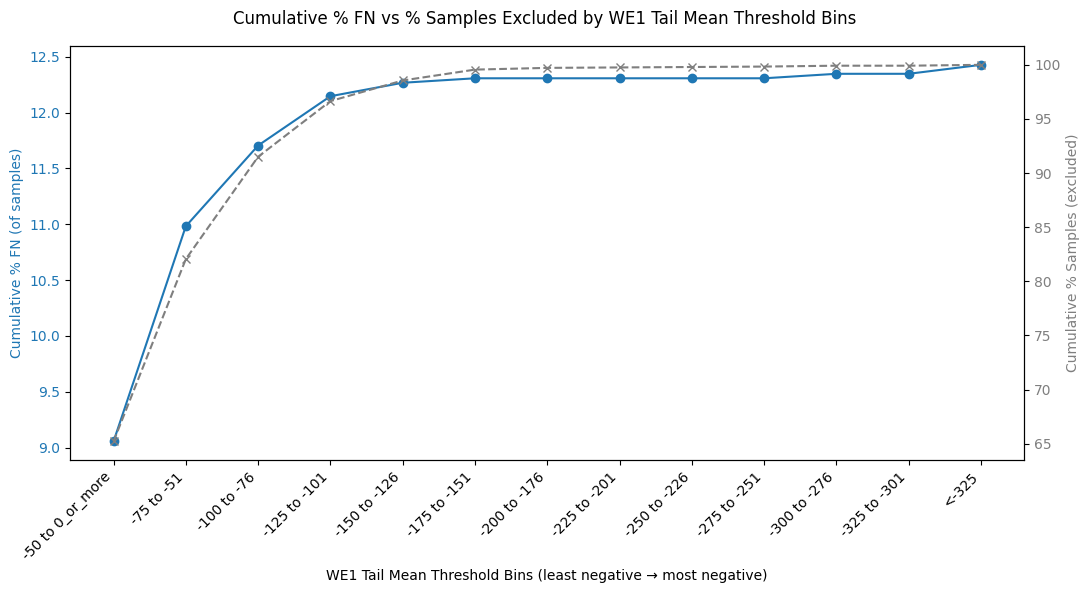


All rows were placed into bins successfully (no NaNs).


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG: use the actual raw dataframe and correct WE1 column name ---
df_raw = df_fluA_filtered.copy()   # your raw FluA dataframe
value_col = 'we1_step66_tailmean'  # correct column used elsewhere in our convo
fn_col = 'FN'                      # binary 0/1 column indicating False Negative

# --- define bin edges you used before (adjust if you want different cut points) ---
bin_edges = [-np.inf, -325, -300, -275, -250, -225, -200, -175, -150, -125, -100, -75, -50, np.inf]
# Make readable labels (we'll display the left-inclusive upper edge representation)
bin_labels = ['<-325', '-325 to -301', '-300 to -276', '-275 to -251', '-250 to -226',
              '-225 to -201', '-200 to -176', '-175 to -151', '-150 to -126', '-125 to -101',
              '-100 to -76', '-75 to -51', '-50 to 0_or_more']

# --- Quick diagnostics: existence & nulls in the WE1 column ---
print("Raw summary:")
print(f"Total rows in df_raw: {len(df_raw)}")
print(f"Column '{value_col}' present? {value_col in df_raw.columns}")
print(f"Non-null values in '{value_col}': {df_raw[value_col].notna().sum()}")
print(f"FN total from raw data (sum of `{fn_col}`): {df_raw[fn_col].sum()}\n")

# --- BINNING (defensive) ---
df_raw['_tmp_bin'] = pd.cut(df_raw[value_col], bins=bin_edges, labels=bin_labels, right=True)

# Show how many rows ended up in bins vs how many were dropped (NaN)
bin_counts_with_nan = df_raw['_tmp_bin'].value_counts(dropna=False).to_frame(name='count')
print("Counts per bin (including NaN):")
print(bin_counts_with_nan)
print("\nNumber of rows with NaN bin (not placed into any bin):", df_raw['_tmp_bin'].isna().sum())

# --- AGGREGATE BY BIN (only non-NaN bins) ---
df_summary = (
    df_raw.dropna(subset=['_tmp_bin'])
    .groupby('_tmp_bin', observed=True)
    .agg(
        Count=('FN', 'size'),
        FN_count=(fn_col, 'sum')
    )
    .reset_index()
)

# Reindex to ensure all bins present in order
df_summary = df_summary.set_index('_tmp_bin').reindex(bin_labels).reset_index()

# --- Compute percentages & cumulative ---
df_summary['% FN'] = 100.0 * df_summary['FN_count'] / df_summary['Count']
df_summary['% FN'] = df_summary['% FN'].fillna(0)  # avoid NaN when Count=0
df_summary['Count'] = df_summary['Count'].fillna(0).astype(int)
df_summary['FN_count'] = df_summary['FN_count'].fillna(0).astype(int)

# --- SORT bins from least negative to most negative ---
df_summary_sorted = df_summary.iloc[::-1].reset_index(drop=True)

# Recalculate cumulative columns in forward order
df_summary_sorted['cum_FN_count'] = df_summary_sorted['FN_count'].cumsum()
total_samples_in_bins = df_summary_sorted['Count'].sum()
df_summary_sorted['cum_%FN_total'] = 100.0 * df_summary_sorted['cum_FN_count'] / total_samples_in_bins if total_samples_in_bins else 0.0
df_summary_sorted['% Count'] = 100.0 * df_summary_sorted['Count'] / total_samples_in_bins if total_samples_in_bins else 0.0
df_summary_sorted['cum_%Samples'] = df_summary_sorted['% Count'].cumsum()

# --- Diagnostics: compare sums to raw data ---
total_fn_raw = int(df_raw[fn_col].sum())
total_fn_binned = int(df_summary['FN_count'].sum())
print(f"\nTotal FN in raw data: {total_fn_raw}")
print(f"Total FN in binned (non-NaN) data: {total_fn_binned}")
print(f"Total rows in raw: {len(df_raw)}, total rows placed in bins: {int(df_raw['_tmp_bin'].notna().sum())}")

# --- Display sorted summary table ---
display_cols = ['_tmp_bin', 'Count', '% Count', '% FN', 'FN_count', 'cum_FN_count', 'cum_%FN_total']
print("\nBinned summary (sorted least negative → most negative):")
print(df_summary_sorted[display_cols].to_string(index=False))

# --- Plot cumulative FN and samples excluded ---
fig, ax1 = plt.subplots(figsize=(11,6))

color_fn = 'tab:blue'
color_sample = 'tab:gray'

ax1.set_xlabel('WE1 Tail Mean Threshold Bins (least negative → most negative)')
ax1.set_ylabel('Cumulative % FN (of samples)', color=color_fn)
ax1.plot(df_summary_sorted['_tmp_bin'], df_summary_sorted['cum_%FN_total'], marker='o', color=color_fn, label='Cumulative % FN')
ax1.tick_params(axis='y', labelcolor=color_fn)
ax1.set_xticklabels(df_summary_sorted['_tmp_bin'], rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative % Samples (excluded)', color=color_sample)
ax2.plot(df_summary_sorted['_tmp_bin'], df_summary_sorted['cum_%Samples'], marker='x', linestyle='--', color=color_sample, label='Cumulative % Samples')
ax2.tick_params(axis='y', labelcolor=color_sample)

fig.suptitle('Cumulative % FN vs % Samples Excluded by WE1 Tail Mean Threshold Bins')
fig.tight_layout()
plt.show()

# --- Optional: print examples for any NaN bins ---
nan_mask = df_raw['_tmp_bin'].isna()
if nan_mask.any():
    print("\nExamples (first 10) of rows where bin is NaN (shows WE1 value):")
    print(df_raw.loc[nan_mask, [value_col, fn_col]].head(10).to_string(index=False))
else:
    print("\nAll rows were placed into bins successfully (no NaNs).")

# --- Clean up temporary column ---
df_raw.drop(columns=['_tmp_bin'], inplace=True)


In [67]:
print(df_fluA_filtered.shape)
print(df_fluA_filtered['FN'].value_counts())

(4981, 172)
FN
0    4362
1     619
Name: count, dtype: int64


# FluB WE1 PreCheck Analysis

In [68]:
df_fluB.shape

(11121, 170)

In [69]:
# Standardizing 'Date Tested' format

df_fluB['Date Tested'] = pd.to_datetime(df_fluB['Date Tested'], format='mixed')

# Standardizing "Reader SN" strings

df_fluB['Reader SN'] = df_fluB['Reader SN'].astype(str)
df_fluB['Reader SN'] = df_fluB['Reader SN'].str.strip()
df_fluB['Reader SN'] = df_fluB['Reader SN'].str.replace(r'\.0$', '', regex=True)

# Keeping only 745 MUX (666 Flu+CoV PID, modified RV flow check), FABC-1.0.0, and FABC-005-13Aug25

df_fluB = df_fluB[df_fluB['Procedure'].isin(['745 MUX', 'FABC-1.0.0', 'FABC-005-13Aug25'])]

In [70]:
# drop duplicated

df_fluB_filtered = df_fluB.drop_duplicates()

df_fluB_filtered.shape

(3436, 170)

In [71]:
# Building df_analysis_fluB forlater analysis work

# Use a clean copy of the data
df_analysis_fluB = df_fluB.copy()  # or df_cov_filtered, depending on the dataset

# Ensure the column exists and drop NA only for the analysis
df_analysis_fluB = df_analysis_fluB[df_analysis_fluB['we1_step66_tailmean'].notna()]


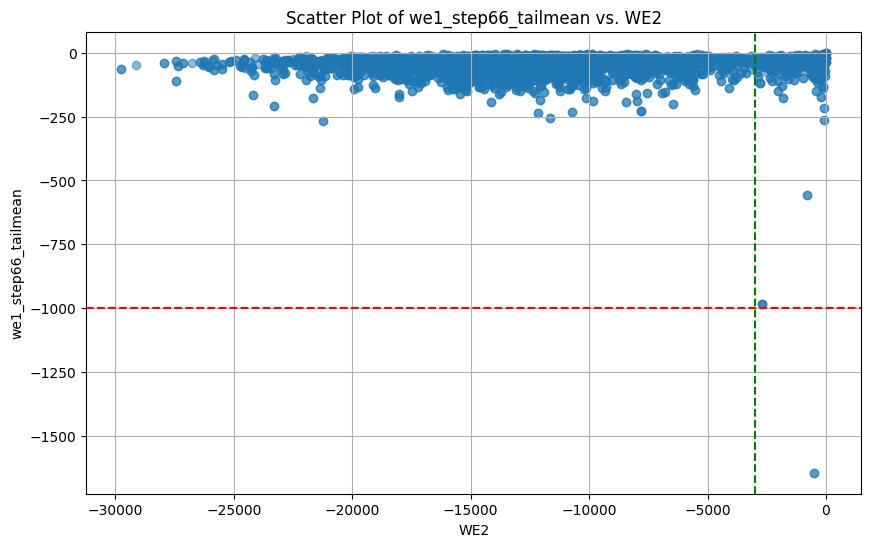

In [72]:
# Visualizing 'we1_step66_tailmean values as a function of WE4 values

plt.figure(figsize=(10, 6))
plt.scatter(df_fluB['WE2'], df_fluB['we1_step66_tailmean'], alpha=0.5)
plt.xlabel('WE2')
plt.ylabel('we1_step66_tailmean')
plt.title('Scatter Plot of we1_step66_tailmean vs. WE2')
# horizontal line at -1000
plt.axhline(y=-1000, color='r', linestyle='--')
# vertical line at -3000
plt.axvline(x=-3000, color='g', linestyle='--')
plt.grid(True)
plt.show()

In [73]:
# Binning the WE1 precheck data

col = "we1_step66_tailmean"
data = df_fluB_filtered[col].dropna()

# Define your bins and labels
bins = [float("-inf"), -1000, -500, -300, -150, -70, 0, float("inf")]
labels = [
    "< -1000",
    "-1000 to -501",
    "-500 to -301",
    "-300 to -151",
    "-150 to -71",
    "-70 to 0",
    "> 0"
]

# Apply binning
binned = pd.cut(data, bins=bins, labels=labels, include_lowest=True)
summary = binned.value_counts().sort_index().reset_index()
summary.columns = ["bin_range", "count"]

# Add percentages
summary["percent"] = (summary["count"] / summary["count"].sum() * 100).round(2)

print(summary)


       bin_range  count  percent
0        < -1000      1     0.03
1  -1000 to -501      2     0.06
2   -500 to -301      0     0.00
3   -300 to -151     39     1.14
4    -150 to -71    657    19.12
5       -70 to 0   2737    79.66
6            > 0      0     0.00


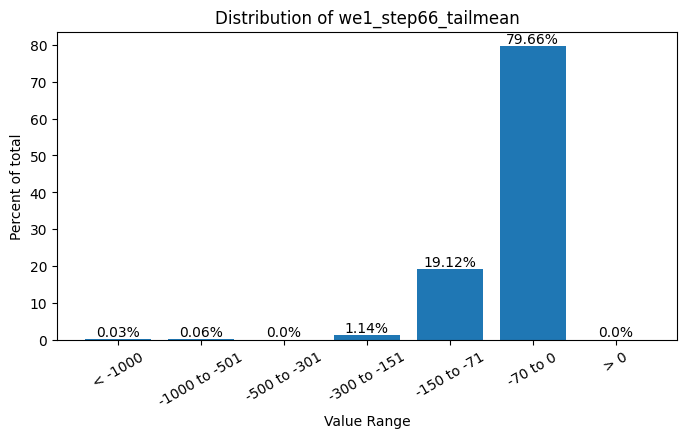

In [74]:
# Visualizing the bins

plt.figure(figsize=(8,4))
plt.bar(summary["bin_range"], summary["percent"])
plt.title(f"Distribution of {col}")
plt.xlabel("Value Range")
plt.ylabel("Percent of total")
plt.xticks(rotation=30)
# Annotating percentage above each bar
for i, v in enumerate(summary["percent"]):
    plt.text(i, v, f"{v}%", ha="center", va="bottom")
plt.show()


In [75]:
# Looking at WE1, WE2, WE3, WE4, WE5, and WE6 values of my individual bins

# Add the binned data as a new column to df_fluB_filtered
df_fluB_filtered['we1_bins'] = binned

# Group by the created bins and describe the WE columns
we_analysis = df_fluB_filtered.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].describe()
display(we_analysis)

WE1                                                          \
                count          mean           std      min       25%      50%   
we1_bins                                                                        
< -1000           1.0  -1541.000000           NaN  -1541.0  -1541.00  -1541.0   
-1000 to -501     2.0 -11806.500000  15329.367909 -22646.0 -17226.25 -11806.5   
-500 to -301      0.0           NaN           NaN      NaN       NaN      NaN   
-300 to -151     39.0 -14690.000000   7422.432666 -31324.0 -18279.00 -14192.0   
-150 to -71     657.0 -15167.610350   4435.737040 -28921.0 -17781.00 -14921.0   
-70 to 0       2737.0 -17739.273292   5504.144611 -34711.0 -21224.00 -18138.0   
> 0               0.0           NaN           NaN      NaN       NaN      NaN   

                                    WE2                ...    WE5         \
                    75%     max   count          mean  ...    75%    max   
we1_bins                                               ...                 
< -1000        -1541.00 -1541.0     1.0   -509.000000  ...  -19.0  -19.0   
-1000 to -501  -6386.75  -967.0     2.0  -1748.000000  ... -192.0 -168.0   
-500 to -301        NaN     NaN     0.0           NaN  ...    NaN    NaN   
-300 to -151  -10514.00  -212.0    39.0 -10804.128205  ...  -96.0  -63.0   
-150 to -71   -12690.00   -81.0   657.0 -11433.709285  ...  -88.0  -27.0   
-70 to 0      -14937.00     0.0  2737.0 -11519.077822  ...  -73.0    0.0   
> 0                 NaN     NaN     0.0           NaN  ...    NaN    NaN   

                  WE6                                                         \
                count          mean          std      min       25%      50%   
we1_bins                                                                       
< -1000           1.0 -10964.000000          NaN -10964.0 -10964.00 -10964.0   
-1000 to -501     2.0  -6113.500000  8080.109189 -11827.0  -8970.25  -6113.5   
-500 to -301      0.0           NaN          NaN      NaN       NaN      NaN   
-300 to -151     39.0 -15217.717949  4089.536359 -21757.0 -18572.00 -15328.0   
-150 to -71     657.0 -16030.412481  3621.157492 -28912.0 -18295.00 -16401.0   
-70 to 0       2737.0 -15529.258677  3418.808676 -26828.0 -17948.00 -15576.0   
> 0               0.0           NaN          NaN      NaN       NaN      NaN   

                                  
                    75%      max  
we1_bins                          
< -1000       -10964.00 -10964.0  
-1000 to -501  -3256.75   -400.0  
-500 to -301        NaN      NaN  
-300 to -151  -12270.50  -3626.0  
-150 to -71   -14149.00      0.0  
-70 to 0      -13302.00      0.0  
> 0                 NaN      NaN  

[7 rows x 48 columns]

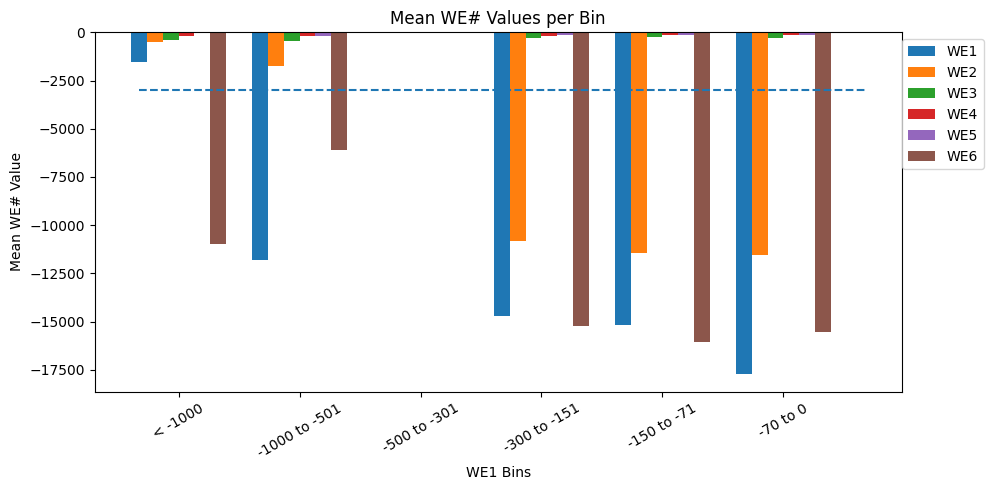

In [76]:
import matplotlib.pyplot as plt
import numpy as np

we_means = df_fluB_filtered.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].mean()
we_means = we_means.reindex(labels)  # ensure correct bin order

bins = we_means.index
we_cols = we_means.columns
x = np.arange(len(bins))  # the label locations
width = 0.13  # width of each bar

plt.figure(figsize=(10,5))
for i, col in enumerate(we_cols):
    plt.bar(x + i*width, we_means[col], width=width, label=col)

plt.xticks(x + width*2.5, bins, rotation=30)
plt.ylabel("Mean WE# Value")
plt.xlabel("WE1 Bins")
plt.title("Mean WE# Values per Bin")
plt.legend(title="WE#")
plt.legend(bbox_to_anchor=(1.11, 1), loc='upper right')
plt.hlines(y=-3000, xmin=x.min(), xmax=x.max(), linestyles='dashed')
plt.tight_layout()
plt.show()


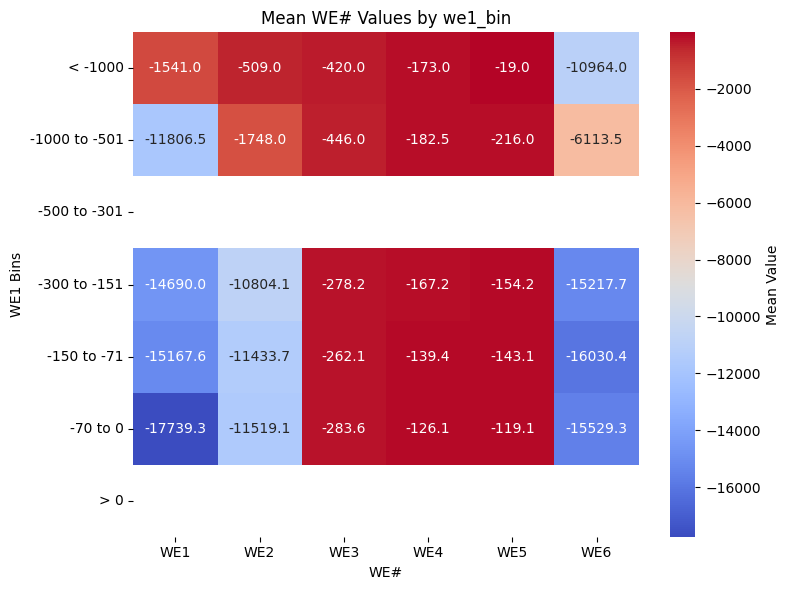

In [77]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(we_means, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Mean Value'})
plt.title("Mean WE# Values by we1_bin")
plt.ylabel("WE1 Bins")
plt.xlabel("WE#")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [78]:
import pandas as pd

# 1️⃣ Compute mean WE values per bin
we_means = df_fluB_filtered.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].mean()

# Ensure bins are in the correct order
we_means = we_means.reindex(labels)

# 2️⃣ Count samples per bin
bin_counts = df_fluB_filtered['we1_bins'].value_counts().reindex(labels)
bin_counts.name = "count"

# 3️⃣ Identify the control bin
control_bin = "-70 to 0"
control_values = we_means.loc[control_bin]

# 4️⃣ Compute Delta_WE# relative to control
delta_cols = {col: f"Delta_{col}" for col in we_means.columns}
delta_values = we_means - control_values
delta_values.rename(columns=delta_cols, inplace=True)

# 5️⃣ Combine counts, means, and deltas into one summary DataFrame
summary_df = pd.concat([bin_counts, we_means, delta_values], axis=1).reset_index()
summary_df.rename(columns={"we1_bins": "bin_range"}, inplace=True)

# 6️⃣ Format numeric columns to 1 decimal place
we_cols = ['WE1','WE2','WE3','WE4','WE5','WE6']
delta_cols = [f"Delta_{col}" for col in we_cols]
summary_df[we_cols + delta_cols] = summary_df[we_cols + delta_cols].round(1)

# 7️⃣ Display the table
display(summary_df)


bin_range  count      WE1      WE2    WE3    WE4    WE5      WE6  \
0        < -1000      1  -1541.0   -509.0 -420.0 -173.0  -19.0 -10964.0   
1  -1000 to -501      2 -11806.5  -1748.0 -446.0 -182.5 -216.0  -6113.5   
2   -500 to -301      0      NaN      NaN    NaN    NaN    NaN      NaN   
3   -300 to -151     39 -14690.0 -10804.1 -278.2 -167.2 -154.2 -15217.7   
4    -150 to -71    657 -15167.6 -11433.7 -262.1 -139.4 -143.1 -16030.4   
5       -70 to 0   2737 -17739.3 -11519.1 -283.6 -126.1 -119.1 -15529.3   
6            > 0      0      NaN      NaN    NaN    NaN    NaN      NaN   

   Delta_WE1  Delta_WE2  Delta_WE3  Delta_WE4  Delta_WE5  Delta_WE6  
0    16198.3    11010.1     -136.4      -46.9      100.1     4565.3  
1     5932.8     9771.1     -162.4      -56.4      -96.9     9415.8  
2        NaN        NaN        NaN        NaN        NaN        NaN  
3     3049.3      714.9        5.3      -41.1      -35.1      311.5  
4     2571.7       85.4       21.5      -13.4      -24.1     -501.2  
5        0.0        0.0        0.0        0.0        0.0        0.0  
6        NaN        NaN        NaN        NaN        NaN        NaN

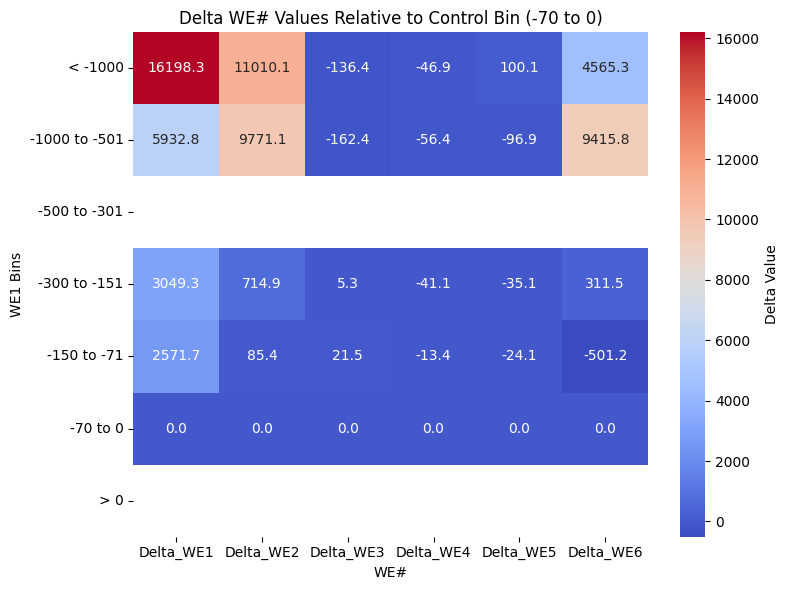

In [79]:
# Plot the Delta WE's

delta_only = summary_df.set_index('bin_range')[delta_cols]

plt.figure(figsize=(8,6))
sns.heatmap(delta_only, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Delta Value'})
plt.title("Delta WE# Values Relative to Control Bin (-70 to 0)")
plt.ylabel("WE1 Bins")
plt.xlabel("WE#")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [80]:
import pandas as pd
import numpy as np

# --- 1️⃣ Compute mean WE values per bin ---
we_means = df_fluB_filtered.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].mean()
we_means = we_means.reindex(labels)

# --- 2️⃣ Count samples per bin ---
bin_counts = df_fluB_filtered['we1_bins'].value_counts().reindex(labels)
bin_counts.name = "count"

# --- 3️⃣ Identify control bin ---
control_bin = "-70 to 0"
control_values = we_means.loc[control_bin]

# --- 4️⃣ Compute ΔWE relative to control ---
delta_cols = {col: f"Delta_{col}" for col in we_means.columns}
delta_values = we_means - control_values
delta_values.rename(columns=delta_cols, inplace=True)

# --- 5️⃣ Cartridge-level status determination ---
def classify_status(row):
    """Return Valid/Invalid based on warnings/errors presence."""
    has_issue = False
    for col in ['Warnings', 'Errors']:
        if col in row and pd.notna(row[col]) and str(row[col]).strip():
            has_issue = True
            break
    return "Invalid" if has_issue else "Valid"

df_fluB_filtered['status'] = df_fluB_filtered.apply(classify_status, axis=1)

# --- 6️⃣ Define helper flags (FN, WE3_FP, WE5_FP) ---
# Assuming these flags are boolean or identifiable by name in columns:
for flag in ['FN', 'WE3_FP', 'WE5_FP']:
    if flag not in df_fluB_filtered.columns:
        df_fluB_filtered[flag] = False  # ensure column exists

# --- 7️⃣ Compute percentages per bin ---
def compute_percentages(group):
    n = len(group)
    valid = (group['status'] == 'Valid').sum()
    invalid = (group['status'] == 'Invalid').sum()
    fn = group['FN'].sum()
    we3_fp = group['WE3_FP'].sum()
    we5_fp = group['WE5_FP'].sum()
    return pd.Series({
        '% Valid': 100 * valid / n if n else np.nan,
        '% Invalid': 100 * invalid / n if n else np.nan,
        '% FN': 100 * fn / n if n else np.nan,
        '% WE3 FP': 100 * we3_fp / n if n else np.nan,
        '% WE5 FP': 100 * we5_fp / n if n else np.nan
    })

percentages = df_fluB_filtered.groupby('we1_bins').apply(compute_percentages).reindex(labels)

# --- 8️⃣ Combine all results into one summary table ---
summary_df = pd.concat([bin_counts, we_means, delta_values, percentages], axis=1).reset_index()
summary_df.rename(columns={"we1_bins": "bin_range"}, inplace=True)

# --- 9️⃣ Format numeric columns to 1 decimal place ---
we_cols = ['WE1','WE2','WE3','WE4','WE5','WE6']
delta_cols = [f"Delta_{col}" for col in we_cols]
summary_df[we_cols + delta_cols] = summary_df[we_cols + delta_cols].round(1)
summary_df[['% Valid', '% Invalid', '% FN', '% WE3 FP', '% WE5 FP']] = \
    summary_df[['% Valid', '% Invalid', '% FN', '% WE3 FP', '% WE5 FP']].round(1)

# --- 🔟 Display the final summary ---
display(summary_df)


bin_range  count      WE1      WE2    WE3    WE4    WE5      WE6  \
0        < -1000      1  -1541.0   -509.0 -420.0 -173.0  -19.0 -10964.0   
1  -1000 to -501      2 -11806.5  -1748.0 -446.0 -182.5 -216.0  -6113.5   
2   -500 to -301      0      NaN      NaN    NaN    NaN    NaN      NaN   
3   -300 to -151     39 -14690.0 -10804.1 -278.2 -167.2 -154.2 -15217.7   
4    -150 to -71    657 -15167.6 -11433.7 -262.1 -139.4 -143.1 -16030.4   
5       -70 to 0   2737 -17739.3 -11519.1 -283.6 -126.1 -119.1 -15529.3   
6            > 0      0      NaN      NaN    NaN    NaN    NaN      NaN   

   Delta_WE1  Delta_WE2  Delta_WE3  Delta_WE4  Delta_WE5  Delta_WE6  % Valid  \
0    16198.3    11010.1     -136.4      -46.9      100.1     4565.3      0.0   
1     5932.8     9771.1     -162.4      -56.4      -96.9     9415.8     50.0   
2        NaN        NaN        NaN        NaN        NaN        NaN      NaN   
3     3049.3      714.9        5.3      -41.1      -35.1      311.5     84.6   
4     2571.7       85.4       21.5      -13.4      -24.1     -501.2     93.5   
5        0.0        0.0        0.0        0.0        0.0        0.0     94.2   
6        NaN        NaN        NaN        NaN        NaN        NaN      NaN   

   % Invalid   % FN  % WE3 FP  % WE5 FP  
0      100.0  100.0       0.0       0.0  
1       50.0  100.0       0.0       0.0  
2        NaN    NaN       NaN       NaN  
3       15.4   15.4       0.0       0.0  
4        6.5   13.1       0.0       0.2  
5        5.8   17.4       0.1       0.2  
6        NaN    NaN       NaN       NaN

In [81]:
# --- 11️⃣ Deep dive: failure modes among Invalid samples ---

def compute_invalid_overlap(group):
    invalid_group = group[group['status'] == 'Invalid']
    n_invalid = len(invalid_group)
    if n_invalid == 0:
        return pd.Series({
            'Invalid_with_FN': 0,
            'Invalid_with_WE3_FP': 0,
            'Invalid_with_WE5_FP': 0,
            '% Invalid_with_FN': np.nan,
            '% Invalid_with_WE3_FP': np.nan,
            '% Invalid_with_WE5_FP': np.nan
        })
    return pd.Series({
        'Invalid_with_FN': invalid_group['FN'].sum(),
        'Invalid_with_WE3_FP': invalid_group['WE3_FP'].sum(),
        'Invalid_with_WE5_FP': invalid_group['WE5_FP'].sum(),
        '% Invalid_with_FN': 100 * invalid_group['FN'].sum() / n_invalid,
        '% Invalid_with_WE3_FP': 100 * invalid_group['WE3_FP'].sum() / n_invalid,
        '% Invalid_with_WE5_FP': 100 * invalid_group['WE5_FP'].sum() / n_invalid
    })

invalid_overlap = (
    df_fluB_filtered.groupby('we1_bins')
    .apply(compute_invalid_overlap)
    .reindex(labels)
)

# --- 12️⃣ Combine with main summary ---
summary_df_detailed = pd.concat([summary_df.set_index('bin_range'), invalid_overlap], axis=1).reset_index()

# --- 13️⃣ Round numeric values ---
cols_to_round = [
    '% Invalid_with_FN', '% Invalid_with_WE3_FP', '% Invalid_with_WE5_FP'
]
summary_df_detailed[cols_to_round] = summary_df_detailed[cols_to_round].round(1)


#--------Columns to keep-------------
summary_df_detailed_filtered = summary_df_detailed[['index',
 'count',
 '% Valid',
 '% Invalid',
 '% FN',
 '% WE3 FP',
 '% WE5 FP',
 'Invalid_with_FN',
 'Invalid_with_WE3_FP',
 'Invalid_with_WE5_FP',
 '% Invalid_with_FN',
 '% Invalid_with_WE3_FP',
 '% Invalid_with_WE5_FP'
]]


# --- 14️⃣ Display the enhanced table ---
display(summary_df_detailed_filtered)


index  count  % Valid  % Invalid   % FN  % WE3 FP  % WE5 FP  \
0        < -1000      1      0.0      100.0  100.0       0.0       0.0   
1  -1000 to -501      2     50.0       50.0  100.0       0.0       0.0   
2   -500 to -301      0      NaN        NaN    NaN       NaN       NaN   
3   -300 to -151     39     84.6       15.4   15.4       0.0       0.0   
4    -150 to -71    657     93.5        6.5   13.1       0.0       0.2   
5       -70 to 0   2737     94.2        5.8   17.4       0.1       0.2   
6            > 0      0      NaN        NaN    NaN       NaN       NaN   

   Invalid_with_FN  Invalid_with_WE3_FP  Invalid_with_WE5_FP  \
0              1.0                  0.0                  0.0   
1              1.0                  0.0                  0.0   
2              0.0                  0.0                  0.0   
3              2.0                  0.0                  0.0   
4              6.0                  0.0                  0.0   
5             50.0                  3.0                  1.0   
6              0.0                  0.0                  0.0   

   % Invalid_with_FN  % Invalid_with_WE3_FP  % Invalid_with_WE5_FP  
0              100.0                    0.0                    0.0  
1              100.0                    0.0                    0.0  
2                NaN                    NaN                    NaN  
3               33.3                    0.0                    0.0  
4               14.0                    0.0                    0.0  
5               31.2                    1.9                    0.6  
6                NaN                    NaN                    NaN

In [82]:
# --- Deep dive: failure flags that are Invalid ---

def compute_flag_invalid_overlap(group):
    fn_total = group['FN'].sum()
    we3_total = group['WE3_FP'].sum()
    we5_total = group['WE5_FP'].sum()

    fn_invalid = group.loc[group['FN'] & (group['status'] == 'Invalid')].shape[0]
    we3_invalid = group.loc[group['WE3_FP'] & (group['status'] == 'Invalid')].shape[0]
    we5_invalid = group.loc[group['WE5_FP'] & (group['status'] == 'Invalid')].shape[0]

    return pd.Series({
        'FN_total': fn_total,
        'FN_invalid': fn_invalid,
        '% FN_invalid': 100 * fn_invalid / fn_total if fn_total else np.nan,
        'WE3_FP_total': we3_total,
        'WE3_FP_invalid': we3_invalid,
        '% WE3_FP_invalid': 100 * we3_invalid / we3_total if we3_total else np.nan,
        'WE5_FP_total': we5_total,
        'WE5_FP_invalid': we5_invalid,
        '% WE5_FP_invalid': 100 * we5_invalid / we5_total if we5_total else np.nan,
    })

flag_invalid_overlap = (
    df_fluB_filtered.groupby('we1_bins')
    .apply(compute_flag_invalid_overlap)
    .reindex(labels)
)

# --- Combine into your summary ---
summary_df_detailed = pd.concat([summary_df.set_index('bin_range'), flag_invalid_overlap], axis=1).reset_index()

# --- Round percentage columns ---
pct_cols = ['% FN_invalid', '% WE3_FP_invalid', '% WE5_FP_invalid']
summary_df_detailed[pct_cols] = summary_df_detailed[pct_cols].round(1)


#--------Filtering to Desired Columns
summary_df_detailed_filtered = summary_df_detailed[['index',
 'count',
 '% Valid',
 '% Invalid',
 '% FN',
 '% WE5 FP',
 '% WE3 FP',
'% FN_invalid', '% WE3_FP_invalid', '% WE5_FP_invalid'
]]

display(summary_df_detailed_filtered)


index  count  % Valid  % Invalid   % FN  % WE5 FP  % WE3 FP  \
0        < -1000      1      0.0      100.0  100.0       0.0       0.0   
1  -1000 to -501      2     50.0       50.0  100.0       0.0       0.0   
2   -500 to -301      0      NaN        NaN    NaN       NaN       NaN   
3   -300 to -151     39     84.6       15.4   15.4       0.0       0.0   
4    -150 to -71    657     93.5        6.5   13.1       0.2       0.0   
5       -70 to 0   2737     94.2        5.8   17.4       0.2       0.1   
6            > 0      0      NaN        NaN    NaN       NaN       NaN   

   % FN_invalid  % WE3_FP_invalid  % WE5_FP_invalid  
0         100.0               NaN               NaN  
1          50.0               NaN               NaN  
2           NaN               NaN               NaN  
3          33.3               NaN               NaN  
4           7.0               NaN               0.0  
5          10.5              75.0              20.0  
6           NaN               NaN               NaN

In [83]:
import pandas as pd
import numpy as np

# -------------------------------
# 1️⃣ Define continuous thresholds
# -------------------------------
thresholds = list(range(-50, -1025, -25))  # -50, -325, ..., -1000
thresholds.append(-999999)  # catch ≤ -1000
threshold_labels = [str(t) if t != -999999 else "≤ -1000" for t in thresholds]

# -------------------------------
# 2️⃣ Ensure status and FP/FN columns exist
# -------------------------------
def classify_status(row):
    """Return Valid/Invalid based on Warnings/Errors presence."""
    for col in ['Warnings', 'Errors']:
        if col in row and pd.notna(row[col]) and str(row[col]).strip():
            return "Invalid"
    return "Valid"

df_analysis_fluB['status'] = df_analysis_fluB.apply(classify_status, axis=1)

for flag in ['FN', 'WE3_FP', 'WE5_FP']:
    if flag not in df_analysis_fluB.columns:
        df_analysis_fluB[flag] = False

# -------------------------------
# 3️⃣ Loop through thresholds
# -------------------------------
results = []

for i, t in enumerate(thresholds):
    label = threshold_labels[i]

    # Subset for this threshold
    if t == -999999:
        subset = df_analysis_fluB[df_analysis_fluB['we1_step66_tailmean'] <= -1000]
    else:
        subset = df_analysis_fluB[df_analysis_fluB['we1_step66_tailmean'] <= t]

    if subset.empty:
        continue

    n = len(subset)

    # Valid / Invalid counts
    valid = (subset['status'] == 'Valid').sum()
    invalid = (subset['status'] == 'Invalid').sum()

    # FN / FP totals
    fn_total = subset['FN'].sum()
    we3_total = subset['WE3_FP'].sum()
    we5_total = subset['WE5_FP'].sum()

    # FN / FP also invalid
    fn_invalid = subset.loc[subset['FN'] & (subset['status'] == 'Invalid')].shape[0]
    we3_invalid = subset.loc[subset['WE3_FP'] & (subset['status'] == 'Invalid')].shape[0]
    we5_invalid = subset.loc[subset['WE5_FP'] & (subset['status'] == 'Invalid')].shape[0]

    # Append results
    results.append({
        'Threshold': label,
        'Count': n,
        '% Valid': 100 * valid / n,
        '% Invalid': 100 * invalid / n,
        '% FN': 100 * fn_total / n,
        '% WE3 FP': 100 * we3_total / n,
        '% WE5 FP': 100 * we5_total / n,
        'FN_total': fn_total,
        'FN_invalid': fn_invalid,
        '% FN_invalid': 100 * fn_invalid / fn_total if fn_total else np.nan,
        'WE3_FP_total': we3_total,
        'WE3_FP_invalid': we3_invalid,
        '% WE3_FP_invalid': 100 * we3_invalid / we3_total if we3_total else np.nan,
        'WE5_FP_total': we5_total,
        'WE5_FP_invalid': we5_invalid,
        '% WE5_FP_invalid': 100 * we5_invalid / we5_total if we5_total else np.nan
    })

# -------------------------------
# 4️⃣ Convert to DataFrame
# -------------------------------
threshold_summary_df = pd.DataFrame(results)

# Round percentages
pct_cols = [col for col in threshold_summary_df.columns if col.startswith('%')]
threshold_summary_df[pct_cols] = threshold_summary_df[pct_cols].round(1)

# -------------------------------
# 5️⃣ Optional: filter columns
# -------------------------------
threshold_summary_df_filtered_fluB = threshold_summary_df[[
    'Threshold', 'Count', '% Valid', '% Invalid', '% FN', '% WE3 FP', '% WE5 FP',
    'FN_total', 'FN_invalid', '% FN_invalid',
    'WE3_FP_total', 'WE3_FP_invalid', '% WE3_FP_invalid',
    'WE5_FP_total', 'WE5_FP_invalid', '% WE5_FP_invalid'
]]

# -------------------------------
# 6️⃣ Display
# -------------------------------
display(threshold_summary_df_filtered_fluB)


Threshold  Count  % Valid  % Invalid   % FN  % WE3 FP  % WE5 FP  FN_total  \
0        -50   1896     93.4        6.6   11.4       0.0       0.2       217   
1        -75    913     91.7        8.3   12.3       0.0       0.0       112   
2       -100    432     90.7        9.3   10.0       0.0       0.0        43   
3       -125    182     89.6       10.4   13.7       0.0       0.0        25   
4       -150     74     79.7       20.3   25.7       0.0       0.0        19   
5       -175     42     83.3       16.7   31.0       0.0       0.0        13   
6       -200     26     73.1       26.9   42.3       0.0       0.0        11   
7       -225     20     65.0       35.0   45.0       0.0       0.0         9   
8       -250     13     46.2       53.8   69.2       0.0       0.0         9   
9       -275      7     28.6       71.4  100.0       0.0       0.0         7   
10      -300      7     28.6       71.4  100.0       0.0       0.0         7   
11      -325      7     28.6       71.4  100.0       0.0       0.0         7   
12      -350      7     28.6       71.4  100.0       0.0       0.0         7   
13      -375      7     28.6       71.4  100.0       0.0       0.0         7   
14      -400      7     28.6       71.4  100.0       0.0       0.0         7   
15      -425      7     28.6       71.4  100.0       0.0       0.0         7   
16      -450      7     28.6       71.4  100.0       0.0       0.0         7   
17      -475      7     28.6       71.4  100.0       0.0       0.0         7   
18      -500      7     28.6       71.4  100.0       0.0       0.0         7   
19      -525      7     28.6       71.4  100.0       0.0       0.0         7   
20      -550      7     28.6       71.4  100.0       0.0       0.0         7   
21      -575      5      0.0      100.0  100.0       0.0       0.0         5   
22      -600      5      0.0      100.0  100.0       0.0       0.0         5   
23      -625      5      0.0      100.0  100.0       0.0       0.0         5   
24      -650      5      0.0      100.0  100.0       0.0       0.0         5   
25      -675      5      0.0      100.0  100.0       0.0       0.0         5   
26      -700      5      0.0      100.0  100.0       0.0       0.0         5   
27      -725      5      0.0      100.0  100.0       0.0       0.0         5   
28      -750      5      0.0      100.0  100.0       0.0       0.0         5   
29      -775      5      0.0      100.0  100.0       0.0       0.0         5   
30      -800      5      0.0      100.0  100.0       0.0       0.0         5   
31      -825      5      0.0      100.0  100.0       0.0       0.0         5   
32      -850      5      0.0      100.0  100.0       0.0       0.0         5   
33      -875      5      0.0      100.0  100.0       0.0       0.0         5   
34      -900      5      0.0      100.0  100.0       0.0       0.0         5   
35      -925      5      0.0      100.0  100.0       0.0       0.0         5   
36      -950      5      0.0      100.0  100.0       0.0       0.0         5   
37      -975      5      0.0      100.0  100.0       0.0       0.0         5   
38     -1000      2      0.0      100.0  100.0       0.0       0.0         2   
39   ≤ -1000      2      0.0      100.0  100.0       0.0       0.0         2   

    FN_invalid  % FN_invalid  WE3_FP_total  WE3_FP_invalid  % WE3_FP_invalid  \
0           24          11.1             0               0               NaN   
1           20          17.9             0               0               NaN   
2           16          37.2             0               0               NaN   
3           13          52.0             0               0               NaN   
4            9          47.4             0               0               NaN   
5            7          53.8             0               0               NaN   
6            7          63.6             0               0               NaN   
7            7          77.8             0               0               NaN   
8 

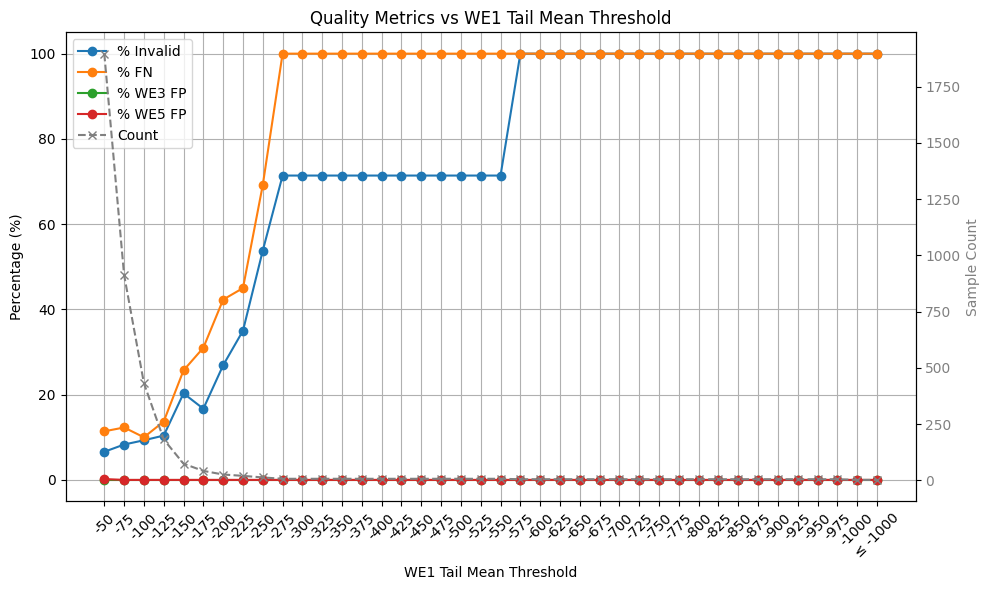

In [84]:
import matplotlib.pyplot as plt

# Create the figure and main axis
fig, ax1 = plt.subplots(figsize=(10,6))

# --- Primary y-axis: Percentages ---
ax1.plot(threshold_summary_df_filtered_fluB['Threshold'], threshold_summary_df_filtered_fluB['% Invalid'], marker='o', label='% Invalid')
ax1.plot(threshold_summary_df_filtered_fluB['Threshold'], threshold_summary_df_filtered_fluB['% FN'], marker='o', label='% FN')
ax1.plot(threshold_summary_df_filtered_fluB['Threshold'], threshold_summary_df_filtered_fluB['% WE3 FP'], marker='o', label='% WE3 FP')
ax1.plot(threshold_summary_df_filtered_fluB['Threshold'], threshold_summary_df_filtered_fluB['% WE5 FP'], marker='o', label='% WE5 FP')

ax1.set_xlabel('WE1 Tail Mean Threshold')
ax1.set_ylabel('Percentage (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(threshold_summary_df_filtered_fluB['Threshold'], rotation=45)
ax1.grid(True)

# --- Secondary y-axis: Count overlay ---
ax2 = ax1.twinx()
ax2.plot(threshold_summary_df_filtered_fluB['Threshold'], threshold_summary_df_filtered_fluB['Count'],
         color='gray', linestyle='--', marker='x', label='Count')
ax2.set_ylabel('Sample Count', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# --- Combine legends ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Title and layout
plt.title('Quality Metrics vs WE1 Tail Mean Threshold')
plt.tight_layout()
plt.show()


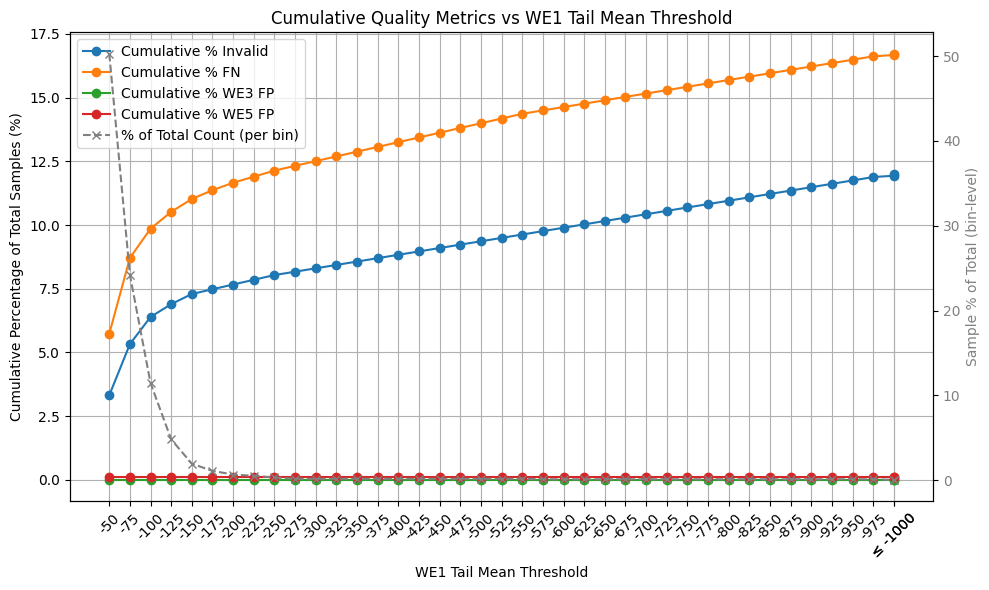

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Copy original ---
df = threshold_summary_df_filtered_fluB.copy()

# --- Parse numeric threshold values (handle labels like "≤ -1000") ---
def parse_threshold(x):
    if isinstance(x, str):
        x = x.replace('≤', '').strip()
    try:
        return float(x)
    except:
        return np.nan

df['Threshold_num'] = df['Threshold'].apply(parse_threshold)

# --- Sort thresholds numerically (least → most negative) ---
df = df.sort_values(by='Threshold_num', ascending=False)

# --- Convert Count to % of total ---
df['% Count'] = 100 * df['Count'] / df['Count'].sum()

# --- Compute cumulative sums ---
df['cum_Count'] = df['Count'].cumsum()
df['cum_Invalid'] = (df['% Invalid'] / 100 * df['Count']).cumsum()
df['cum_FN'] = (df['% FN'] / 100 * df['Count']).cumsum()
df['cum_WE3_FP'] = (df['% WE3 FP'] / 100 * df['Count']).cumsum()
df['cum_WE5_FP'] = (df['% WE5 FP'] / 100 * df['Count']).cumsum()

# --- Convert cumulative sums to percentages of total Count ---
total_count = df['Count'].sum()
df['cum_% Invalid'] = 100 * df['cum_Invalid'] / total_count
df['cum_% FN'] = 100 * df['cum_FN'] / total_count
df['cum_% WE3 FP'] = 100 * df['cum_WE3_FP'] / total_count
df['cum_% WE5 FP'] = 100 * df['cum_WE5_FP'] / total_count

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(10,6))

# --- Primary axis: cumulative metrics ---
ax1.plot(df['Threshold_num'], df['cum_% Invalid'], marker='o', label='Cumulative % Invalid')
ax1.plot(df['Threshold_num'], df['cum_% FN'], marker='o', label='Cumulative % FN')
ax1.plot(df['Threshold_num'], df['cum_% WE3 FP'], marker='o', label='Cumulative % WE3 FP')
ax1.plot(df['Threshold_num'], df['cum_% WE5 FP'], marker='o', label='Cumulative % WE5 FP')

ax1.set_xlabel('WE1 Tail Mean Threshold')
ax1.set_ylabel('Cumulative Percentage of Total Samples (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(df['Threshold_num'])
ax1.set_xticklabels(df['Threshold'], rotation=45)
ax1.grid(True)

# --- Reverse x-axis (least negative → most negative) ---
ax1.invert_xaxis()

# --- Secondary axis: % Count per threshold ---
ax2 = ax1.twinx()
ax2.plot(df['Threshold_num'], df['% Count'], color='gray', linestyle='--', marker='x', label='% of Total Count (per bin)')
ax2.set_ylabel('Sample % of Total (bin-level)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# --- Combine legends ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Cumulative Quality Metrics vs WE1 Tail Mean Threshold')
plt.tight_layout()
plt.show()


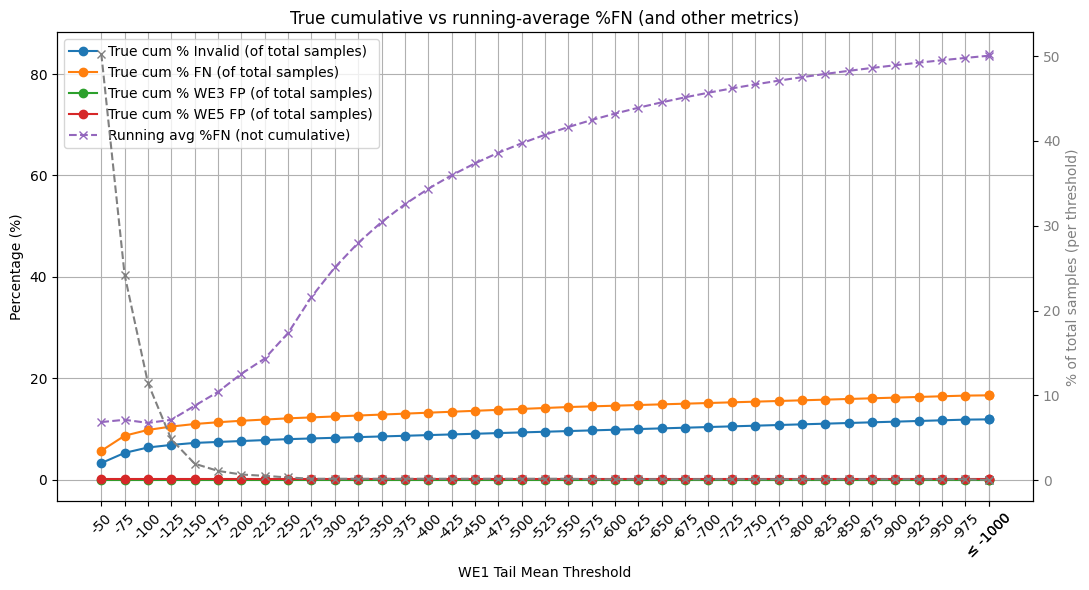

Threshold  Count   % Count  % FN  FN_count  cum_FN_count  cum_%FN_total Highlight_5pct
      -50   1896 50.278441  11.4   216.144       216.144       5.731742               
      -75    913 24.211085  12.3   112.299       328.443       8.709706               
     -100    432 11.455847  10.0    43.200       371.643       9.855290               
     -125    182  4.826306  13.7    24.934       396.577      10.516494     << 5% mark
     -150     74  1.962344  25.7    19.018       415.595      11.020817               
     -175     42  1.113763  31.0    13.020       428.615      11.366083               
     -200     26  0.689472  42.3    10.998       439.613      11.657730               
     -225     20  0.530363  45.0     9.000       448.613      11.896394               
     -250     13  0.344736  69.2     8.996       457.609      12.134951               
     -275      7  0.185627 100.0     7.000       464.609      12.320578               
     -300      7  0.185627 100.0     7.000 

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Copy source
df = threshold_summary_df_filtered_fluB.copy()

# Parse numeric thresholds (handle "≤ -1000" etc.)
def parse_threshold(x):
    if isinstance(x, str):
        x = x.replace('≤', '').strip()
    try:
        return float(x)
    except:
        return np.nan

df['Threshold_num'] = df['Threshold'].apply(parse_threshold)

# --- Ensure we only use rows with valid numeric threshold ---
df = df.dropna(subset=['Threshold_num']).copy()

# Sort in the natural accumulation order: least negative -> most negative
df = df.sort_values('Threshold_num', ascending=False).reset_index(drop=True)

# Ensure numeric columns
for col in ['Count', '% FN', '% Invalid', '% WE3 FP', '% WE5 FP']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Per-bin absolute counts of events (from percent and count)
df['FN_count']     = (df['% FN'] / 100.0) * df['Count']
df['Invalid_count']= (df['% Invalid'] / 100.0) * df['Count']
df['WE3FP_count']  = (df['% WE3 FP'] / 100.0) * df['Count']
df['WE5FP_count']  = (df['% WE5 FP'] / 100.0) * df['Count']

# Running-average style (not usually desired for accumulation)
df['running_avg_%FN'] = df['% FN'].cumsum() / np.arange(1, len(df) + 1)

# True cumulative totals (absolute) and convert to percent of total samples
total_samples = df['Count'].sum() if df['Count'].sum() else 1
df['cum_FN_count'] = df['FN_count'].cumsum()
df['cum_%FN_total'] = 100.0 * df['cum_FN_count'] / total_samples

# Also cum for Invalids / FPs
df['cum_Invalid_count'] = df['Invalid_count'].cumsum()
df['cum_%Invalid_total'] = 100.0 * df['cum_Invalid_count'] / total_samples
df['cum_WE3FP_count'] = df['WE3FP_count'].cumsum()
df['cum_%WE3FP_total'] = 100.0 * df['cum_WE3FP_count'] / total_samples
df['cum_WE5FP_count'] = df['WE5FP_count'].cumsum()
df['cum_%WE5FP_total'] = 100.0 * df['cum_WE5FP_count'] / total_samples

# Diagnostic: check monotonicity (should be non-decreasing)
def is_monotonic_nondec(series):
    return (np.diff(series) >= -1e-8).all()

monotonic_fn = is_monotonic_nondec(df['cum_%FN_total'].values)
if not monotonic_fn:
    print("WARNING: cum_%FN_total is not monotonic non-decreasing. Inspect 'FN_count' and ordering.")

# Add % Total Samples column (aka % Count)
df['% Count'] = 100.0 * df['Count'] / total_samples

# Add Highlight column for rows where % Count ~ 5% (±0.5%)
tolerance = 0.5
df['Highlight_5pct'] = df['% Count'].apply(lambda x: '<< 5% mark' if abs(x - 5.0) <= tolerance else '')

# --- Plot both versions for comparison ---
fig, ax = plt.subplots(figsize=(11,6))

# True cumulative proportions (preferred)
ax.plot(df['Threshold_num'], df['cum_%Invalid_total'], marker='o', label='True cum % Invalid (of total samples)')
ax.plot(df['Threshold_num'], df['cum_%FN_total'], marker='o', label='True cum % FN (of total samples)')
ax.plot(df['Threshold_num'], df['cum_%WE3FP_total'], marker='o', label='True cum % WE3 FP (of total samples)')
ax.plot(df['Threshold_num'], df['cum_%WE5FP_total'], marker='o', label='True cum % WE5 FP (of total samples)')

# Running-average lines (for reference)
ax.plot(df['Threshold_num'], df['running_avg_%FN'], marker='x', linestyle='--', label='Running avg %FN (not cumulative)')

# X axis labels
ax.set_xticks(df['Threshold_num'])
ax.set_xticklabels(df['Threshold'], rotation=45)
ax.invert_xaxis()  # show least negative -> most negative left->right
ax.set_xlabel('WE1 Tail Mean Threshold')
ax.set_ylabel('Percentage (%)')
ax.grid(True)
ax.legend(loc='upper left')

# Right axis: percent of samples per threshold (bin-level)
ax2 = ax.twinx()
ax2.plot(df['Threshold_num'], df['% Count'], color='gray', linestyle='--', marker='x', label='% of total (per threshold)')
ax2.set_ylabel('% of total samples (per threshold)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Show plot
plt.title('True cumulative vs running-average %FN (and other metrics)')
plt.tight_layout()
plt.show()

# Optional: print a small table for debugging with new columns
display_cols = ['Threshold', 'Count', '% Count', '% FN', 'FN_count', 'cum_FN_count', 'cum_%FN_total', 'Highlight_5pct']
print(df[display_cols].head(12).to_string(index=False))


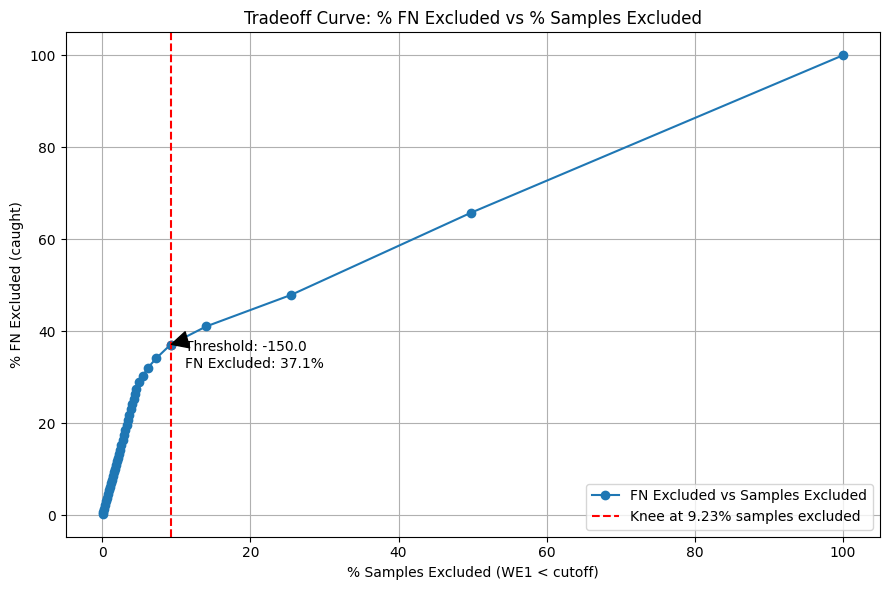

Recommended WE1 threshold cutoff: -150.0


Threshold  Count  % Valid  % Invalid   % FN  % WE3 FP  % WE5 FP  FN_total  \
0       -50   1896     93.4        6.6   11.4       0.0       0.2       217   
1       -75    913     91.7        8.3   12.3       0.0       0.0       112   
2      -100    432     90.7        9.3   10.0       0.0       0.0        43   
3      -125    182     89.6       10.4   13.7       0.0       0.0        25   
4      -150     74     79.7       20.3   25.7       0.0       0.0        19   
5      -175     42     83.3       16.7   31.0       0.0       0.0        13   
6      -200     26     73.1       26.9   42.3       0.0       0.0        11   
7      -225     20     65.0       35.0   45.0       0.0       0.0         9   
8      -250     13     46.2       53.8   69.2       0.0       0.0         9   
9      -275      7     28.6       71.4  100.0       0.0       0.0         7   

   FN_invalid  % FN_invalid  ...  % WE3_FP_invalid  WE5_FP_total  \
0          24          11.1  ...               NaN             4   
1          20          17.9  ...               NaN             0   
2          16          37.2  ...               NaN             0   
3          13          52.0  ...               NaN             0   
4           9          47.4  ...               NaN             0   
5           7          53.8  ...               NaN             0   
6           7          63.6  ...               NaN             0   
7           7          77.8  ...               NaN             0   
8           7          77.8  ...               NaN             0   
9           5          71.4  ...               NaN             0   

   WE5_FP_invalid  % WE5_FP_invalid  Threshold_num  FN_count  \
0               0               0.0          -50.0   216.144   
1               0               NaN          -75.0   112.299   
2               0               NaN         -100.0    43.200   
3               0               NaN         -125.0    24.934   
4               0               NaN         -150.0    19.018   
5               0               NaN         -175.0    13.020   
6               0               NaN         -200.0    10.998   
7               0               NaN         -225.0     9.000   
8               0               NaN         -250.0     8.996   
9               0               NaN         -275.0     7.000   

   samples_excluded  fn_excluded  % samples_excluded  % fn_excluded  
0              3771      630.609          100.000000     100.000000  
1              1875      414.465           49.721559      65.724561  
2               962      302.166           25.510475      47.916538  
3               530      258.966           14.054627      41.066017  
4               348      234.032            9.228321      37.112062  
5               274      215.014            7.265977      34.096247  
6               232      201.994            6.152214      32.031576  
7               206      190.996            5.462742      30.287547  
8               186      181.996            4.932379      28.860356  
9               173      173.000            4.587643      27.433798  

[10 rows x 22 columns]

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kneed import KneeLocator  # You'll need to install this package via pip

def analyze_we1_cutoff_tradeoff(threshold_df, threshold_col='Threshold', count_col='Count', fn_percent_col='% FN'):
    """
    Analyze tradeoff between sample exclusion and FN exclusion by WE1 threshold.
    Detect knee point to recommend cutoff.

    Parameters:
    - threshold_df: pd.DataFrame with threshold summary
    - threshold_col: column name with threshold labels
    - count_col: column with sample counts per threshold bin
    - fn_percent_col: column with % FN per threshold bin

    Returns:
    - recommended_cutoff: numeric threshold value at knee point
    - plot figure with annotated tradeoff curve
    - augmented DataFrame with cumulative stats and knee point info
    """
    df = threshold_summary_df_filtered_fluB.copy()

    # Parse numeric threshold (handle "≤ -1000" etc.)
    def parse_threshold(x):
        if isinstance(x, str):
            x = x.replace('≤', '').strip()
        try:
            return float(x)
        except:
            return np.nan

    df['Threshold_num'] = df[threshold_col].apply(parse_threshold)
    df = df.dropna(subset=['Threshold_num']).copy()

    # Sort descending (least negative -> most negative)
    df = df.sort_values('Threshold_num', ascending=False).reset_index(drop=True)

    # Ensure numeric columns
    for col in [count_col, fn_percent_col]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    total_samples = df[count_col].sum()
    total_fn = ((df[fn_percent_col] / 100) * df[count_col]).sum()

    # Calculate FN counts and cumulative sums (reversed for exclusion)
    df['FN_count'] = (df[fn_percent_col] / 100) * df[count_col]

    # Reverse cumulative sums (samples excluded and FN excluded if cutoff at each threshold)
    df['samples_excluded'] = df[count_col][::-1].cumsum()[::-1]
    df['fn_excluded'] = df['FN_count'][::-1].cumsum()[::-1]

    # Percents of totals
    df['% samples_excluded'] = 100 * df['samples_excluded'] / total_samples
    df['% fn_excluded'] = 100 * df['fn_excluded'] / total_fn

    # Detect knee/elbow point
    knee = KneeLocator(
        df['% samples_excluded'], df['% fn_excluded'],
        curve='concave', direction='increasing'
    )
    knee_point = knee.knee

    # Get threshold value at knee if found
    if knee_point is not None:
        recommended_cutoff = df.loc[(df['% samples_excluded'] - knee_point).abs().idxmin(), 'Threshold_num']
    else:
        recommended_cutoff = None

    # Plot tradeoff curve with knee point annotated
    plt.figure(figsize=(9,6))
    plt.plot(df['% samples_excluded'], df['% fn_excluded'], marker='o', label='FN Excluded vs Samples Excluded')
    if knee_point is not None:
        plt.axvline(knee_point, color='red', linestyle='--', label=f'Knee at {knee_point:.2f}% samples excluded')
        knee_y = df.loc[(df['% samples_excluded'] - knee_point).abs().idxmin(), '% fn_excluded']
        plt.scatter(knee_point, knee_y, color='red')
        plt.annotate(f"Threshold: {recommended_cutoff}\nFN Excluded: {knee_y:.1f}%",
                     xy=(knee_point, knee_y), xytext=(knee_point+2, knee_y-5),
                     arrowprops=dict(facecolor='black', shrink=0.05))
    plt.xlabel('% Samples Excluded (WE1 < cutoff)')
    plt.ylabel('% FN Excluded (caught)')
    plt.title('Tradeoff Curve: % FN Excluded vs % Samples Excluded')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return recommended_cutoff, df


recommended_cutoff, augmented_df = analyze_we1_cutoff_tradeoff(threshold_summary_df_filtered_fluB)
print(f"Recommended WE1 threshold cutoff: {recommended_cutoff}")
display(augmented_df.head(10))


Raw summary:
Total rows in df_raw: 3436
Column 'we1_step66_tailmean' present? True
Non-null values in 'we1_step66_tailmean': 3436
FN total from raw data (sum of `FN`): 570

Counts per bin (including NaN):
                  count
_tmp_bin               
-50 to 0_or_more   2214
-75 to -51          616
-100 to -76         316
-125 to -101        176
-150 to -126         72
-175 to -151         20
-200 to -176          9
-275 to -251          4
<-325                 3
-250 to -226          3
-225 to -201          3
-325 to -301          0
-300 to -276          0

Number of rows with NaN bin (not placed into any bin): 0

Total FN in raw data: 570
Total FN in binned (non-NaN) data: 570
Total rows in raw: 3436, total rows placed in bins: 3436

Binned summary (sorted least negative → most negative):
        _tmp_bin  Count   % Count       % FN  FN_count  cum_FN_count  cum_%FN_total
-50 to 0_or_more   2214 64.435390  18.654020       413           413      12.019790
      -75 to -51    616 17.92

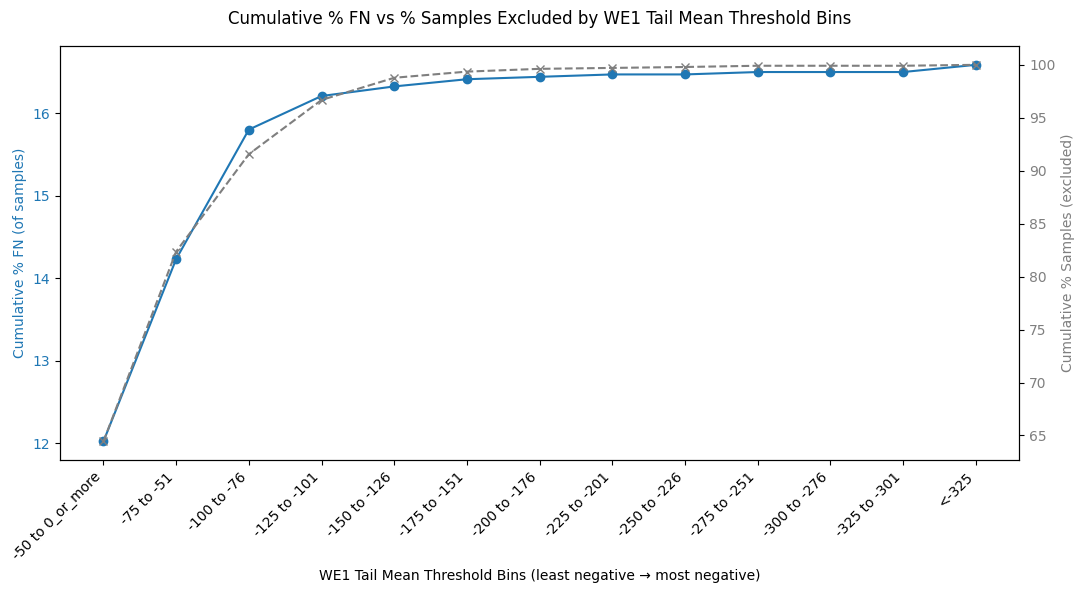


All rows were placed into bins successfully (no NaNs).


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG: use the actual raw dataframe and correct WE1 column name ---
df_raw = df_fluB_filtered.copy()   # your raw fluB dataframe
value_col = 'we1_step66_tailmean'  # correct column used elsewhere in our convo
fn_col = 'FN'                      # binary 0/1 column indicating False Negative

# --- define bin edges you used before (adjust if you want different cut points) ---
bin_edges = [-np.inf, -325, -300, -275, -250, -225, -200, -175, -150, -125, -100, -75, -50, np.inf]
# Make readable labels (we'll display the left-inclusive upper edge representation)
bin_labels = ['<-325', '-325 to -301', '-300 to -276', '-275 to -251', '-250 to -226',
              '-225 to -201', '-200 to -176', '-175 to -151', '-150 to -126', '-125 to -101',
              '-100 to -76', '-75 to -51', '-50 to 0_or_more']

# --- Quick diagnostics: existence & nulls in the WE1 column ---
print("Raw summary:")
print(f"Total rows in df_raw: {len(df_raw)}")
print(f"Column '{value_col}' present? {value_col in df_raw.columns}")
print(f"Non-null values in '{value_col}': {df_raw[value_col].notna().sum()}")
print(f"FN total from raw data (sum of `{fn_col}`): {df_raw[fn_col].sum()}\n")

# --- BINNING (defensive) ---
df_raw['_tmp_bin'] = pd.cut(df_raw[value_col], bins=bin_edges, labels=bin_labels, right=True)

# Show how many rows ended up in bins vs how many were dropped (NaN)
bin_counts_with_nan = df_raw['_tmp_bin'].value_counts(dropna=False).to_frame(name='count')
print("Counts per bin (including NaN):")
print(bin_counts_with_nan)
print("\nNumber of rows with NaN bin (not placed into any bin):", df_raw['_tmp_bin'].isna().sum())

# --- AGGREGATE BY BIN (only non-NaN bins) ---
df_summary = (
    df_raw.dropna(subset=['_tmp_bin'])
    .groupby('_tmp_bin', observed=True)
    .agg(
        Count=('FN', 'size'),
        FN_count=(fn_col, 'sum')
    )
    .reset_index()
)

# Reindex to ensure all bins present in order
df_summary = df_summary.set_index('_tmp_bin').reindex(bin_labels).reset_index()

# --- Compute percentages & cumulative ---
df_summary['% FN'] = 100.0 * df_summary['FN_count'] / df_summary['Count']
df_summary['% FN'] = df_summary['% FN'].fillna(0)  # avoid NaN when Count=0
df_summary['Count'] = df_summary['Count'].fillna(0).astype(int)
df_summary['FN_count'] = df_summary['FN_count'].fillna(0).astype(int)

# --- SORT bins from least negative to most negative ---
df_summary_sorted = df_summary.iloc[::-1].reset_index(drop=True)

# Recalculate cumulative columns in forward order
df_summary_sorted['cum_FN_count'] = df_summary_sorted['FN_count'].cumsum()
total_samples_in_bins = df_summary_sorted['Count'].sum()
df_summary_sorted['cum_%FN_total'] = 100.0 * df_summary_sorted['cum_FN_count'] / total_samples_in_bins if total_samples_in_bins else 0.0
df_summary_sorted['% Count'] = 100.0 * df_summary_sorted['Count'] / total_samples_in_bins if total_samples_in_bins else 0.0
df_summary_sorted['cum_%Samples'] = df_summary_sorted['% Count'].cumsum()

# --- Diagnostics: compare sums to raw data ---
total_fn_raw = int(df_raw[fn_col].sum())
total_fn_binned = int(df_summary['FN_count'].sum())
print(f"\nTotal FN in raw data: {total_fn_raw}")
print(f"Total FN in binned (non-NaN) data: {total_fn_binned}")
print(f"Total rows in raw: {len(df_raw)}, total rows placed in bins: {int(df_raw['_tmp_bin'].notna().sum())}")

# --- Display sorted summary table ---
display_cols = ['_tmp_bin', 'Count', '% Count', '% FN', 'FN_count', 'cum_FN_count', 'cum_%FN_total']
print("\nBinned summary (sorted least negative → most negative):")
print(df_summary_sorted[display_cols].to_string(index=False))

# --- Plot cumulative FN and samples excluded ---
fig, ax1 = plt.subplots(figsize=(11,6))

color_fn = 'tab:blue'
color_sample = 'tab:gray'

ax1.set_xlabel('WE1 Tail Mean Threshold Bins (least negative → most negative)')
ax1.set_ylabel('Cumulative % FN (of samples)', color=color_fn)
ax1.plot(df_summary_sorted['_tmp_bin'], df_summary_sorted['cum_%FN_total'], marker='o', color=color_fn, label='Cumulative % FN')
ax1.tick_params(axis='y', labelcolor=color_fn)
ax1.set_xticklabels(df_summary_sorted['_tmp_bin'], rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative % Samples (excluded)', color=color_sample)
ax2.plot(df_summary_sorted['_tmp_bin'], df_summary_sorted['cum_%Samples'], marker='x', linestyle='--', color=color_sample, label='Cumulative % Samples')
ax2.tick_params(axis='y', labelcolor=color_sample)

fig.suptitle('Cumulative % FN vs % Samples Excluded by WE1 Tail Mean Threshold Bins')
fig.tight_layout()
plt.show()

# --- Optional: print examples for any NaN bins ---
nan_mask = df_raw['_tmp_bin'].isna()
if nan_mask.any():
    print("\nExamples (first 10) of rows where bin is NaN (shows WE1 value):")
    print(df_raw.loc[nan_mask, [value_col, fn_col]].head(10).to_string(index=False))
else:
    print("\nAll rows were placed into bins successfully (no NaNs).")

# --- Clean up temporary column ---
df_raw.drop(columns=['_tmp_bin'], inplace=True)


In [89]:
print(df_fluB_filtered.shape)
print(df_fluB_filtered['FN'].value_counts())

(3436, 172)
FN
0    2866
1     570
Name: count, dtype: int64


# CoV WE1 precheck Analysis

In [90]:
df_cov.shape

(9958, 170)

In [91]:
# Standardizing 'Date Tested' format

df_cov['Date Tested'] = pd.to_datetime(df_cov['Date Tested'], format='mixed')

# Standardizing "Reader SN" strings

df_cov['Reader SN'] = df_cov['Reader SN'].astype(str)
df_cov['Reader SN'] = df_cov['Reader SN'].str.strip()
df_cov['Reader SN'] = df_cov['Reader SN'].str.replace(r'\.0$', '', regex=True)

# Keeping only 745 MUX (666 Flu+CoV PID, modified RV flow check), FABC-1.0.0, and FABC-005-13Aug25

df_cov = df_cov[df_cov['Procedure'].isin(['745 MUX', 'FABC-1.0.0', 'FABC-005-13Aug25'])]

df_cov.shape

(5335, 170)

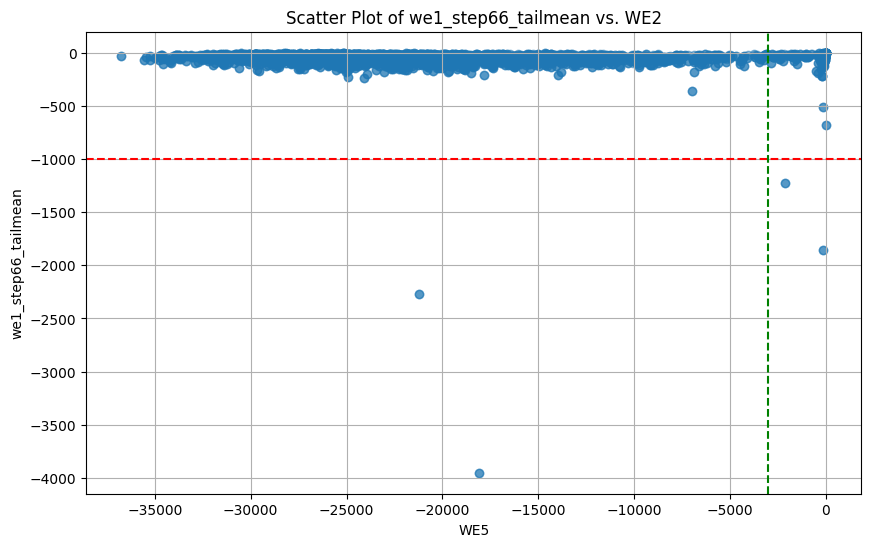

In [92]:
# Visualizing 'we1_step66_tailmean values as a function of WE5 values

plt.figure(figsize=(10, 6))
plt.scatter(df_cov['WE5'], df_cov['we1_step66_tailmean'], alpha=0.5)
plt.xlabel('WE5')
plt.ylabel('we1_step66_tailmean')
plt.title('Scatter Plot of we1_step66_tailmean vs. WE2')
# horizontal line at -1000
plt.axhline(y=-1000, color='r', linestyle='--')
# vertical line at -3000
plt.axvline(x=-3000, color='g', linestyle='--')
plt.grid(True)
plt.show()

In [93]:
# drop duplicated

df_cov_filtered = df_cov.drop_duplicates()

df_cov_filtered.shape

(3139, 170)

In [94]:
# Building df_analysis_cov forlater analysis work

# Use a clean copy of the data
df_analysis_cov = df_cov.copy()  # or df_cov_filtered, depending on the dataset

# Ensure the column exists and drop NA only for the analysis
df_analysis_cov = df_analysis_cov[df_analysis_cov['we1_step66_tailmean'].notna()]


In [95]:
# Binning the WE1 precheck data

col = "we1_step66_tailmean"
data = df_cov_filtered[col].dropna()

# Define your bins and labels
bins = [float("-inf"), -1000, -500, -300, -150, -70, 0, float("inf")]
labels = [
    "< -1000",
    "-1000 to -501",
    "-500 to -301",
    "-300 to -151",
    "-150 to -71",
    "-70 to 0",
    "> 0"
]

# Apply binning
binned = pd.cut(data, bins=bins, labels=labels, include_lowest=True)
summary = binned.value_counts().sort_index().reset_index()
summary.columns = ["bin_range", "count"]

# Add percentages
summary["percent"] = (summary["count"] / summary["count"].sum() * 100).round(2)

print(summary)


       bin_range  count  percent
0        < -1000      5     0.16
1  -1000 to -501      3     0.10
2   -500 to -301      1     0.03
3   -300 to -151     55     1.75
4    -150 to -71    642    20.45
5       -70 to 0   2433    77.51
6            > 0      0     0.00


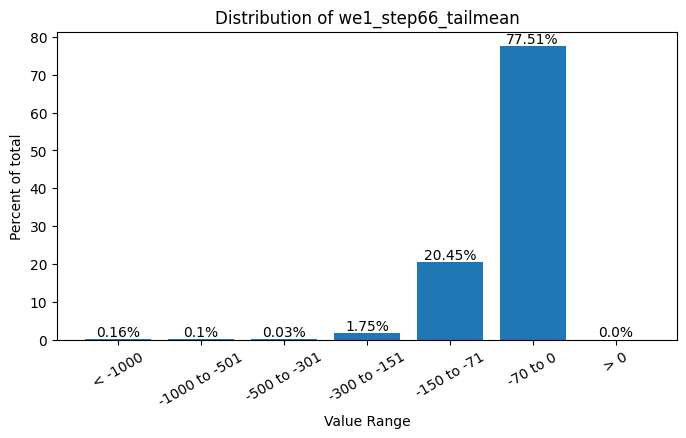

In [96]:
# Visualizing the bins

plt.figure(figsize=(8,4))
plt.bar(summary["bin_range"], summary["percent"])
plt.title(f"Distribution of {col}")
plt.xlabel("Value Range")
plt.ylabel("Percent of total")
plt.xticks(rotation=30)
# Annotating percentage above each bar
for i, v in enumerate(summary["percent"]):
    plt.text(i, v, f"{v}%", ha="center", va="bottom")
plt.show()


In [97]:
# Looking at WE1, WE2, WE3, WE4, WE5, and WE6 values of my individual bins

# Add the binned data as a new column to df_cov_filtered
df_cov_filtered['we1_bins'] = binned

# Group by the created bins and describe the WE columns
we_analysis = df_cov_filtered.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].describe()
display(we_analysis)

WE1                                                         \
                count          mean           std      min      25%      50%   
we1_bins                                                                       
< -1000           5.0 -13856.200000  11665.241069 -26737.0 -19783.0 -19783.0   
-1000 to -501     3.0   -401.000000    133.367912   -555.0   -439.5   -324.0   
-500 to -301      1.0 -20173.000000           NaN -20173.0 -20173.0 -20173.0   
-300 to -151     55.0 -12435.218182   6177.176826 -21424.0 -16680.5 -13825.0   
-150 to -71     642.0 -14642.644860   5632.281266 -32361.0 -17775.0 -14526.0   
-70 to 0       2433.0 -15922.009864   6908.200078 -33556.0 -20796.0 -16202.0   
> 0               0.0           NaN           NaN      NaN      NaN      NaN   

                                    WE2               ...      WE5          \
                   75%      max   count         mean  ...      75%     max   
we1_bins                                              ...                    
< -1000        -2549.0   -429.0     5.0  -889.000000  ...  -2151.0  -166.0   
-1000 to -501   -324.0   -324.0     3.0  -192.000000  ...    -85.0     0.0   
-500 to -301  -20173.0 -20173.0     1.0 -3273.000000  ...  -6967.0 -6967.0   
-300 to -151  -10872.0   -169.0    55.0  -112.890909  ... -17854.0  -195.0   
-150 to -71   -11470.5   -234.0   642.0  -282.137072  ... -14678.0   -66.0   
-70 to 0      -11952.0      0.0  2433.0  -208.009042  ... -15891.0     0.0   
> 0                NaN      NaN     0.0          NaN  ...      NaN     NaN   

                  WE6                                                        \
                count          mean          std      min      25%      50%   
we1_bins                                                                      
< -1000           5.0 -13160.800000  3773.664956 -15273.0 -15273.0 -15014.0   
-1000 to -501     3.0  -9414.666667  8026.900793 -14049.0 -14049.0 -14049.0   
-500 to -301      1.0 -16275.000000          NaN -16275.0 -16275.0 -16275.0   
-300 to -151     55.0 -15132.036364  3761.278649 -22335.0 -18017.0 -16288.0   
-150 to -71     642.0 -16293.744548  3675.340207 -26205.0 -18660.0 -16641.0   
-70 to 0       2433.0 -15554.863543  3637.992614 -25182.0 -17922.0 -15697.0   
> 0               0.0           NaN          NaN      NaN      NaN      NaN   

                                  
                    75%      max  
we1_bins                          
< -1000       -13737.00  -6507.0  
-1000 to -501  -7097.50   -146.0  
-500 to -301  -16275.00 -16275.0  
-300 to -151  -12764.00  -5555.0  
-150 to -71   -14193.25   -645.0  
-70 to 0      -13476.00      0.0  
> 0                 NaN      NaN  

[7 rows x 48 columns]

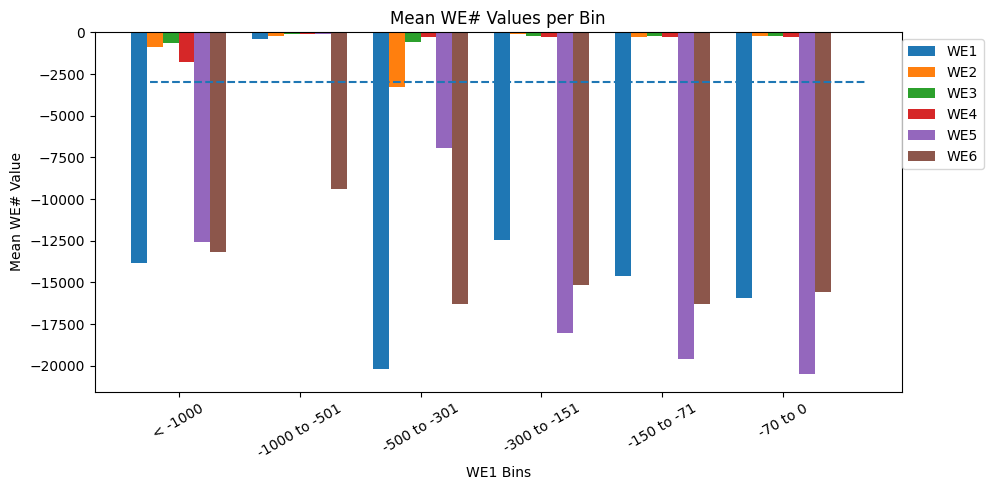

In [98]:
import matplotlib.pyplot as plt
import numpy as np

we_means = df_cov_filtered.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].mean()
we_means = we_means.reindex(labels)  # ensure correct bin order

bins = we_means.index
we_cols = we_means.columns
x = np.arange(len(bins))  # the label locations
width = 0.13  # width of each bar

plt.figure(figsize=(10,5))
for i, col in enumerate(we_cols):
    plt.bar(x + i*width, we_means[col], width=width, label=col)

plt.xticks(x + width*2.5, bins, rotation=30)
plt.ylabel("Mean WE# Value")
plt.xlabel("WE1 Bins")
plt.title("Mean WE# Values per Bin")
plt.legend(title="WE#")
plt.legend(bbox_to_anchor=(1.11, 1), loc='upper right')
plt.hlines(y=-3000, xmin=x.min(), xmax=x.max(), linestyles='dashed')
plt.tight_layout()
plt.show()


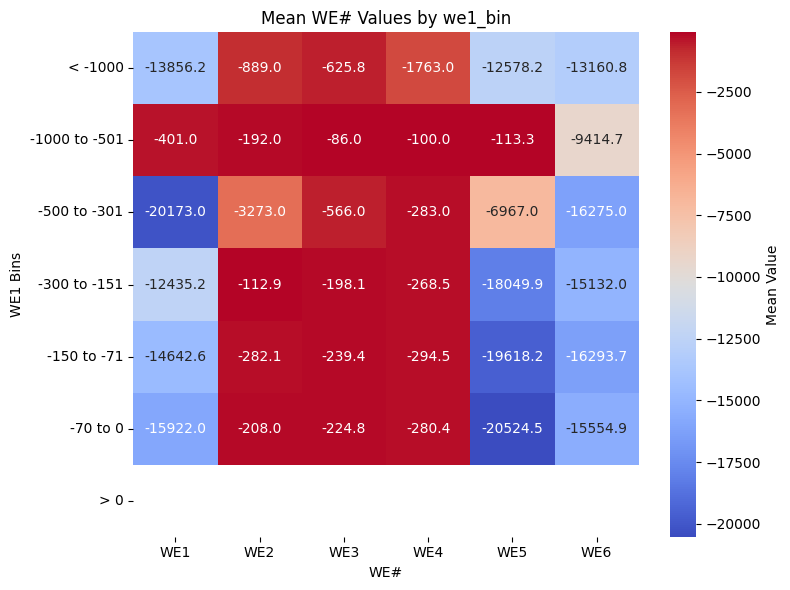

In [99]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(we_means, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Mean Value'})
plt.title("Mean WE# Values by we1_bin")
plt.ylabel("WE1 Bins")
plt.xlabel("WE#")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [100]:
import pandas as pd

# 1️⃣ Compute mean WE values per bin
we_means = df_cov_filtered.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].mean()

# Ensure bins are in the correct order
we_means = we_means.reindex(labels)

# 2️⃣ Count samples per bin
bin_counts = df_cov_filtered['we1_bins'].value_counts().reindex(labels)
bin_counts.name = "count"

# 3️⃣ Identify the control bin
control_bin = "-70 to 0"
control_values = we_means.loc[control_bin]

# 4️⃣ Compute Delta_WE# relative to control
delta_cols = {col: f"Delta_{col}" for col in we_means.columns}
delta_values = we_means - control_values
delta_values.rename(columns=delta_cols, inplace=True)

# 5️⃣ Combine counts, means, and deltas into one summary DataFrame
summary_df = pd.concat([bin_counts, we_means, delta_values], axis=1).reset_index()
summary_df.rename(columns={"we1_bins": "bin_range"}, inplace=True)

# 6️⃣ Format numeric columns to 1 decimal place
we_cols = ['WE1','WE2','WE3','WE4','WE5','WE6']
delta_cols = [f"Delta_{col}" for col in we_cols]
summary_df[we_cols + delta_cols] = summary_df[we_cols + delta_cols].round(1)

# 7️⃣ Display the table
display(summary_df)


bin_range  count      WE1     WE2    WE3     WE4      WE5      WE6  \
0        < -1000      5 -13856.2  -889.0 -625.8 -1763.0 -12578.2 -13160.8   
1  -1000 to -501      3   -401.0  -192.0  -86.0  -100.0   -113.3  -9414.7   
2   -500 to -301      1 -20173.0 -3273.0 -566.0  -283.0  -6967.0 -16275.0   
3   -300 to -151     55 -12435.2  -112.9 -198.1  -268.5 -18049.9 -15132.0   
4    -150 to -71    642 -14642.6  -282.1 -239.4  -294.5 -19618.2 -16293.7   
5       -70 to 0   2433 -15922.0  -208.0 -224.8  -280.4 -20524.5 -15554.9   
6            > 0      0      NaN     NaN    NaN     NaN      NaN      NaN   

   Delta_WE1  Delta_WE2  Delta_WE3  Delta_WE4  Delta_WE5  Delta_WE6  
0     2065.8     -681.0     -401.0    -1482.6     7946.3     2394.1  
1    15521.0       16.0      138.8      180.4    20411.2     6140.2  
2    -4251.0    -3065.0     -341.2       -2.6    13557.5     -720.1  
3     3486.8       95.1       26.7       11.9     2474.6      422.8  
4     1279.4      -74.1      -14.6      -14.0      906.3     -738.9  
5        0.0        0.0        0.0        0.0        0.0        0.0  
6        NaN        NaN        NaN        NaN        NaN        NaN

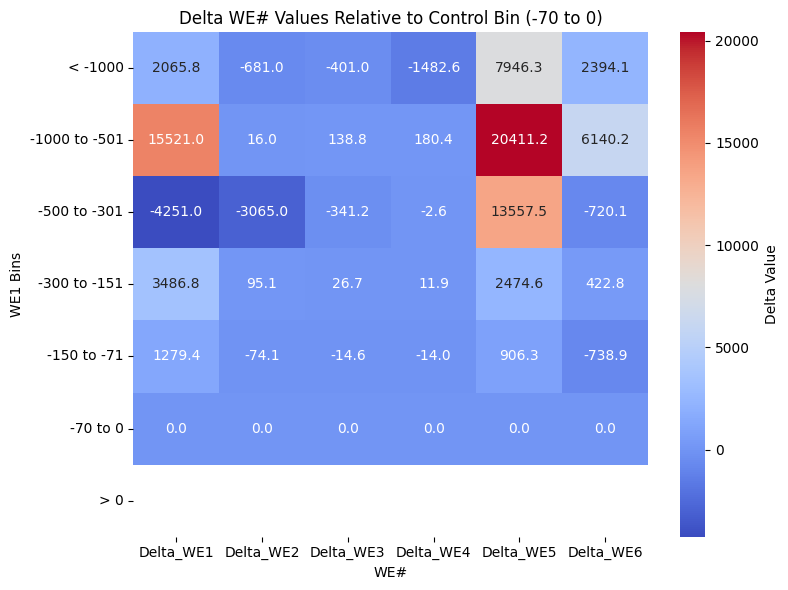

In [101]:
# Plot the Delta WE's

delta_only = summary_df.set_index('bin_range')[delta_cols]

plt.figure(figsize=(8,6))
sns.heatmap(delta_only, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Delta Value'})
plt.title("Delta WE# Values Relative to Control Bin (-70 to 0)")
plt.ylabel("WE1 Bins")
plt.xlabel("WE#")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [102]:
import pandas as pd
import numpy as np

# --- 1️⃣ Compute mean WE values per bin ---
we_means = df_cov_filtered.groupby('we1_bins')[['WE1', 'WE2', 'WE3', 'WE4', 'WE5', 'WE6']].mean()
we_means = we_means.reindex(labels)

# --- 2️⃣ Count samples per bin ---
bin_counts = df_cov_filtered['we1_bins'].value_counts().reindex(labels)
bin_counts.name = "count"

# --- 3️⃣ Identify control bin ---
control_bin = "-70 to 0"
control_values = we_means.loc[control_bin]

# --- 4️⃣ Compute ΔWE relative to control ---
delta_cols = {col: f"Delta_{col}" for col in we_means.columns}
delta_values = we_means - control_values
delta_values.rename(columns=delta_cols, inplace=True)

# --- 5️⃣ Cartridge-level status determination ---
def classify_status(row):
    """Return Valid/Invalid based on warnings/errors presence."""
    has_issue = False
    for col in ['Warnings', 'Errors']:
        if col in row and pd.notna(row[col]) and str(row[col]).strip():
            has_issue = True
            break
    return "Invalid" if has_issue else "Valid"

df_cov_filtered['status'] = df_cov_filtered.apply(classify_status, axis=1)

# --- 6️⃣ Define helper flags (FN, WE2_FP, WE3_FP) ---
# Assuming these flags are boolean or identifiable by name in columns:
for flag in ['FN', 'WE2_FP', 'WE3_FP']:
    if flag not in df_cov_filtered.columns:
        df_cov_filtered[flag] = False  # ensure column exists

# --- 7️⃣ Compute percentages per bin ---
def compute_percentages(group):
    n = len(group)
    valid = (group['status'] == 'Valid').sum()
    invalid = (group['status'] == 'Invalid').sum()
    fn = group['FN'].sum()
    we2_fp = group['WE2_FP'].sum()
    we3_fp = group['WE3_FP'].sum()
    return pd.Series({
        '% Valid': 100 * valid / n if n else np.nan,
        '% Invalid': 100 * invalid / n if n else np.nan,
        '% FN': 100 * fn / n if n else np.nan,
        '% WE2 FP': 100 * we2_fp / n if n else np.nan,
        '% WE3 FP': 100 * we3_fp / n if n else np.nan
    })

percentages = df_cov_filtered.groupby('we1_bins').apply(compute_percentages).reindex(labels)

# --- 8️⃣ Combine all results into one summary table ---
summary_df = pd.concat([bin_counts, we_means, delta_values, percentages], axis=1).reset_index()
summary_df.rename(columns={"we1_bins": "bin_range"}, inplace=True)

# --- 9️⃣ Format numeric columns to 1 decimal place ---
we_cols = ['WE1','WE2','WE3','WE4','WE5','WE6']
delta_cols = [f"Delta_{col}" for col in we_cols]
summary_df[we_cols + delta_cols] = summary_df[we_cols + delta_cols].round(1)
summary_df[['% Valid', '% Invalid', '% FN', '% WE2 FP', '% WE3 FP']] = \
    summary_df[['% Valid', '% Invalid', '% FN', '% WE2 FP', '% WE3 FP']].round(1)

# --- 🔟 Display the final summary ---
display(summary_df)


bin_range  count      WE1     WE2    WE3     WE4      WE5      WE6  \
0        < -1000      5 -13856.2  -889.0 -625.8 -1763.0 -12578.2 -13160.8   
1  -1000 to -501      3   -401.0  -192.0  -86.0  -100.0   -113.3  -9414.7   
2   -500 to -301      1 -20173.0 -3273.0 -566.0  -283.0  -6967.0 -16275.0   
3   -300 to -151     55 -12435.2  -112.9 -198.1  -268.5 -18049.9 -15132.0   
4    -150 to -71    642 -14642.6  -282.1 -239.4  -294.5 -19618.2 -16293.7   
5       -70 to 0   2433 -15922.0  -208.0 -224.8  -280.4 -20524.5 -15554.9   
6            > 0      0      NaN     NaN    NaN     NaN      NaN      NaN   

   Delta_WE1  Delta_WE2  Delta_WE3  Delta_WE4  Delta_WE5  Delta_WE6  % Valid  \
0     2065.8     -681.0     -401.0    -1482.6     7946.3     2394.1     80.0   
1    15521.0       16.0      138.8      180.4    20411.2     6140.2      0.0   
2    -4251.0    -3065.0     -341.2       -2.6    13557.5     -720.1    100.0   
3     3486.8       95.1       26.7       11.9     2474.6      422.8    100.0   
4     1279.4      -74.1      -14.6      -14.0      906.3     -738.9     95.0   
5        0.0        0.0        0.0        0.0        0.0        0.0     94.1   
6        NaN        NaN        NaN        NaN        NaN        NaN      NaN   

   % Invalid   % FN  % WE2 FP  % WE3 FP  
0       20.0   40.0       0.0       0.0  
1      100.0  100.0       0.0       0.0  
2        0.0    0.0     100.0       0.0  
3        0.0   18.2       0.0       0.0  
4        5.0    3.6       2.2       0.0  
5        5.9    8.7       1.1       0.1  
6        NaN    NaN       NaN       NaN

In [103]:
# --- 11️⃣ Deep dive: failure modes among Invalid samples ---

def compute_invalid_overlap(group):
    invalid_group = group[group['status'] == 'Invalid']
    n_invalid = len(invalid_group)
    if n_invalid == 0:
        return pd.Series({
            'Invalid_with_FN': 0,
            'Invalid_with_WE2_FP': 0,
            'Invalid_with_WE3_FP': 0,
            '% Invalid_with_FN': np.nan,
            '% Invalid_with_WE2_FP': np.nan,
            '% Invalid_with_WE3_FP': np.nan
        })
    return pd.Series({
        'Invalid_with_FN': invalid_group['FN'].sum(),
        'Invalid_with_WE2_FP': invalid_group['WE2_FP'].sum(),
        'Invalid_with_WE3_FP': invalid_group['WE3_FP'].sum(),
        '% Invalid_with_FN': 100 * invalid_group['FN'].sum() / n_invalid,
        '% Invalid_with_WE2_FP': 100 * invalid_group['WE2_FP'].sum() / n_invalid,
        '% Invalid_with_WE3_FP': 100 * invalid_group['WE3_FP'].sum() / n_invalid
    })

invalid_overlap = (
    df_cov_filtered.groupby('we1_bins')
    .apply(compute_invalid_overlap)
    .reindex(labels)
)

# --- 12️⃣ Combine with main summary ---
summary_df_detailed = pd.concat([summary_df.set_index('bin_range'), invalid_overlap], axis=1).reset_index()

# --- 13️⃣ Round numeric values ---
cols_to_round = [
    '% Invalid_with_FN', '% Invalid_with_WE2_FP', '% Invalid_with_WE3_FP'
]
summary_df_detailed[cols_to_round] = summary_df_detailed[cols_to_round].round(1)



#--------Filtering to Desired Columns
#--------Columns to keep-------------
summary_df_detailed_filtered = summary_df_detailed[['index',
 'count',
 '% Valid',
 '% Invalid',
 '% FN',
 '% WE2 FP',
 '% WE3 FP',
 'Invalid_with_FN',
 'Invalid_with_WE2_FP',
 'Invalid_with_WE3_FP',
 '% Invalid_with_FN',
 '% Invalid_with_WE2_FP',
 '% Invalid_with_WE3_FP'
]]


# --- 14️⃣ Display the enhanced table ---
display(summary_df_detailed_filtered)



index  count  % Valid  % Invalid   % FN  % WE2 FP  % WE3 FP  \
0        < -1000      5     80.0       20.0   40.0       0.0       0.0   
1  -1000 to -501      3      0.0      100.0  100.0       0.0       0.0   
2   -500 to -301      1    100.0        0.0    0.0     100.0       0.0   
3   -300 to -151     55    100.0        0.0   18.2       0.0       0.0   
4    -150 to -71    642     95.0        5.0    3.6       2.2       0.0   
5       -70 to 0   2433     94.1        5.9    8.7       1.1       0.1   
6            > 0      0      NaN        NaN    NaN       NaN       NaN   

   Invalid_with_FN  Invalid_with_WE2_FP  Invalid_with_WE3_FP  \
0              1.0                  0.0                  0.0   
1              3.0                  0.0                  0.0   
2              0.0                  0.0                  0.0   
3              0.0                  0.0                  0.0   
4              1.0                  0.0                  0.0   
5             42.0                  1.0                  0.0   
6              0.0                  0.0                  0.0   

   % Invalid_with_FN  % Invalid_with_WE2_FP  % Invalid_with_WE3_FP  
0              100.0                    0.0                    0.0  
1              100.0                    0.0                    0.0  
2                NaN                    NaN                    NaN  
3                NaN                    NaN                    NaN  
4                3.1                    0.0                    0.0  
5               29.2                    0.7                    0.0  
6                NaN                    NaN                    NaN

In [104]:
# --- Deep dive: failure flags that are Invalid ---

def compute_flag_invalid_overlap(group):
    fn_total = group['FN'].sum()
    WE2_total = group['WE2_FP'].sum()
    WE3_total = group['WE3_FP'].sum()

    fn_invalid = group.loc[group['FN'] & (group['status'] == 'Invalid')].shape[0]
    WE2_invalid = group.loc[group['WE2_FP'] & (group['status'] == 'Invalid')].shape[0]
    WE3_invalid = group.loc[group['WE3_FP'] & (group['status'] == 'Invalid')].shape[0]

    return pd.Series({
        'FN_total': fn_total,
        'FN_invalid': fn_invalid,
        '% FN_invalid': 100 * fn_invalid / fn_total if fn_total else np.nan,
        'WE2_FP_total': WE2_total,
        'WE2_FP_invalid': WE2_invalid,
        '% WE2_FP_invalid': 100 * WE2_invalid / WE2_total if WE2_total else np.nan,
        'WE3_FP_total': WE3_total,
        'WE3_FP_invalid': WE3_invalid,
        '% WE3_FP_invalid': 100 * WE3_invalid / WE3_total if WE3_total else np.nan,
    })

flag_invalid_overlap = (
    df_cov_filtered.groupby('we1_bins')
    .apply(compute_flag_invalid_overlap)
    .reindex(labels)
)

# --- Combine into your summary ---
summary_df_detailed = pd.concat([summary_df.set_index('bin_range'), flag_invalid_overlap], axis=1).reset_index()

# --- Round percentage columns ---
pct_cols = ['% FN_invalid', '% WE2_FP_invalid', '% WE3_FP_invalid']
summary_df_detailed[pct_cols] = summary_df_detailed[pct_cols].round(1)


#--------Filtering to Desired Columns
summary_df_detailed_filtered = summary_df_detailed[['index',
 'count',
 '% Valid',
 '% Invalid',
 '% FN',
 '% WE2 FP',
 '% WE3 FP',
'% FN_invalid', '% WE2_FP_invalid', '% WE3_FP_invalid'
]]

display(summary_df_detailed_filtered)


index  count  % Valid  % Invalid   % FN  % WE2 FP  % WE3 FP  \
0        < -1000      5     80.0       20.0   40.0       0.0       0.0   
1  -1000 to -501      3      0.0      100.0  100.0       0.0       0.0   
2   -500 to -301      1    100.0        0.0    0.0     100.0       0.0   
3   -300 to -151     55    100.0        0.0   18.2       0.0       0.0   
4    -150 to -71    642     95.0        5.0    3.6       2.2       0.0   
5       -70 to 0   2433     94.1        5.9    8.7       1.1       0.1   
6            > 0      0      NaN        NaN    NaN       NaN       NaN   

   % FN_invalid  % WE2_FP_invalid  % WE3_FP_invalid  
0          50.0               NaN               NaN  
1         100.0               NaN               NaN  
2           NaN               0.0               NaN  
3           0.0               NaN               NaN  
4           4.3               0.0               NaN  
5          19.8               3.8               0.0  
6           NaN               NaN               NaN

In [105]:
import pandas as pd
import numpy as np

# -------------------------------
# 1️⃣ Define continuous thresholds
# -------------------------------
thresholds = list(range(-50, -1025, -25))  # -50, -325, ..., -1000
thresholds.append(-999999)  # catch ≤ -1000
threshold_labels = [str(t) if t != -999999 else "≤ -1000" for t in thresholds]

# -------------------------------
# 2️⃣ Ensure status and FP/FN columns exist
# -------------------------------
def classify_status(row):
    """Return Valid/Invalid based on Warnings/Errors presence."""
    for col in ['Warnings', 'Errors']:
        if col in row and pd.notna(row[col]) and str(row[col]).strip():
            return "Invalid"
    return "Valid"

df_analysis_cov['status'] = df_analysis_cov.apply(classify_status, axis=1)

for flag in ['FN', 'WE2_FP', 'WE3_FP']:
    if flag not in df_analysis_cov.columns:
        df_analysis_cov[flag] = False

# -------------------------------
# 3️⃣ Loop through thresholds
# -------------------------------
results = []

for i, t in enumerate(thresholds):
    label = threshold_labels[i]

    # Subset for this threshold
    if t == -999999:
        subset = df_analysis_cov[df_analysis_cov['we1_step66_tailmean'] <= -1000]
    else:
        subset = df_analysis_cov[df_analysis_cov['we1_step66_tailmean'] <= t]

    if subset.empty:
        continue

    n = len(subset)

    # Valid / Invalid counts
    valid = (subset['status'] == 'Valid').sum()
    invalid = (subset['status'] == 'Invalid').sum()

    # FN / FP totals
    fn_total = subset['FN'].sum()
    we3_total = subset['WE2_FP'].sum()
    we5_total = subset['WE3_FP'].sum()

    # FN / FP also invalid
    fn_invalid = subset.loc[subset['FN'] & (subset['status'] == 'Invalid')].shape[0]
    we3_invalid = subset.loc[subset['WE2_FP'] & (subset['status'] == 'Invalid')].shape[0]
    we5_invalid = subset.loc[subset['WE3_FP'] & (subset['status'] == 'Invalid')].shape[0]

    # Append results
    results.append({
        'Threshold': label,
        'Count': n,
        '% Valid': 100 * valid / n,
        '% Invalid': 100 * invalid / n,
        '% FN': 100 * fn_total / n,
        '% WE2 FP': 100 * we2_total / n,
        '% WE3 FP': 100 * we3_total / n,
        'FN_total': fn_total,
        'FN_invalid': fn_invalid,
        '% FN_invalid': 100 * fn_invalid / fn_total if fn_total else np.nan,
        'WE2_FP_total': we2_total,
        'WE2_FP_invalid': we3_invalid,
        '% WE2_FP_invalid': 100 * we2_invalid / we2_total if we2_total else np.nan,
        'WE3_FP_total': we3_total,
        'WE3_FP_invalid': we3_invalid,
        '% WE3_FP_invalid': 100 * we3_invalid / we3_total if we3_total else np.nan
    })

# -------------------------------
# 4️⃣ Convert to DataFrame
# -------------------------------
threshold_summary_df = pd.DataFrame(results)

# Round percentages
pct_cols = [col for col in threshold_summary_df.columns if col.startswith('%')]
threshold_summary_df[pct_cols] = threshold_summary_df[pct_cols].round(1)

# -------------------------------
# 5️⃣ Optional: filter columns
# -------------------------------
threshold_summary_df_filtered_cov = threshold_summary_df[[
    'Threshold', 'Count', '% Valid', '% Invalid', '% FN', '% WE2 FP', '% WE3 FP',
    'FN_total', 'FN_invalid', '% FN_invalid',
    'WE2_FP_total', 'WE2_FP_invalid', '% WE2_FP_invalid',
    'WE3_FP_total', 'WE3_FP_invalid', '% WE3_FP_invalid'
]]

# -------------------------------
# 6️⃣ Display
# -------------------------------
display(threshold_summary_df_filtered_cov)


Threshold  Count  % Valid  % Invalid  % FN  % WE2 FP  % WE3 FP  FN_total  \
0        -50   1990     94.9        5.1   4.6       0.0       2.5        91   
1        -75    938     94.5        5.5   4.9       0.0       2.8        46   
2       -100    460     93.5        6.5   6.1       0.0       2.6        28   
3       -125    186     95.7        4.3  11.8       0.0       2.2        22   
4       -150     92     93.5        6.5  19.6       0.0       2.2        18   
5       -175     42     85.7       14.3  33.3       0.0       4.8        14   
6       -200     26     76.9       23.1  46.2       0.0       7.7        12   
7       -225     18     66.7       33.3  44.4       0.0      11.1         8   
8       -250     14     57.1       42.9  57.1       0.0      14.3         8   
9       -275     14     57.1       42.9  57.1       0.0      14.3         8   
10      -300     14     57.1       42.9  57.1       0.0      14.3         8   
11      -325     14     57.1       42.9  57.1       0.0      14.3         8   
12      -350     14     57.1       42.9  57.1       0.0      14.3         8   
13      -375     12     50.0       50.0  66.7       0.0       0.0         8   
14      -400     12     50.0       50.0  66.7       0.0       0.0         8   
15      -425     12     50.0       50.0  66.7       0.0       0.0         8   
16      -450     12     50.0       50.0  66.7       0.0       0.0         8   
17      -475     12     50.0       50.0  66.7       0.0       0.0         8   
18      -500     12     50.0       50.0  66.7       0.0       0.0         8   
19      -525     10     60.0       40.0  60.0       0.0       0.0         6   
20      -550     10     60.0       40.0  60.0       0.0       0.0         6   
21      -575     10     60.0       40.0  60.0       0.0       0.0         6   
22      -600     10     60.0       40.0  60.0       0.0       0.0         6   
23      -625     10     60.0       40.0  60.0       0.0       0.0         6   
24      -650     10     60.0       40.0  60.0       0.0       0.0         6   
25      -675     10     60.0       40.0  60.0       0.0       0.0         6   
26      -700      8     75.0       25.0  50.0       0.0       0.0         4   
27      -725      8     75.0       25.0  50.0       0.0       0.0         4   
28      -750      8     75.0       25.0  50.0       0.0       0.0         4   
29      -775      8     75.0       25.0  50.0       0.0       0.0         4   
30      -800      8     75.0       25.0  50.0       0.0       0.0         4   
31      -825      8     75.0       25.0  50.0       0.0       0.0         4   
32      -850      8     75.0       25.0  50.0       0.0       0.0         4   
33      -875      8     75.0       25.0  50.0       0.0       0.0         4   
34      -900      8     75.0       25.0  50.0       0.0       0.0         4   
35      -925      8     75.0       25.0  50.0       0.0       0.0         4   
36      -950      8     75.0       25.0  50.0       0.0       0.0         4   
37      -975      8     75.0       25.0  50.0       0.0       0.0         4   
38     -1000      8     75.0       25.0  50.0       0.0       0.0         4   
39   ≤ -1000      8     75.0       25.0  50.0       0.0       0.0         4   

    FN_invalid  % FN_invalid  WE2_FP_total  WE2_FP_invalid  % WE2_FP_invalid  \
0           12          13.2             0               2               NaN   
1            8          17.4             0               0               NaN   
2            8          28.6             0               0               NaN   
3            8          36.4             0               0               NaN   
4            6          33.3             0               0               NaN   
5            6          42.9             0               0               NaN   
6            6          50.0             0               0               NaN   
7            6          75.0             0               0               NaN   
8            6          75.0             0 

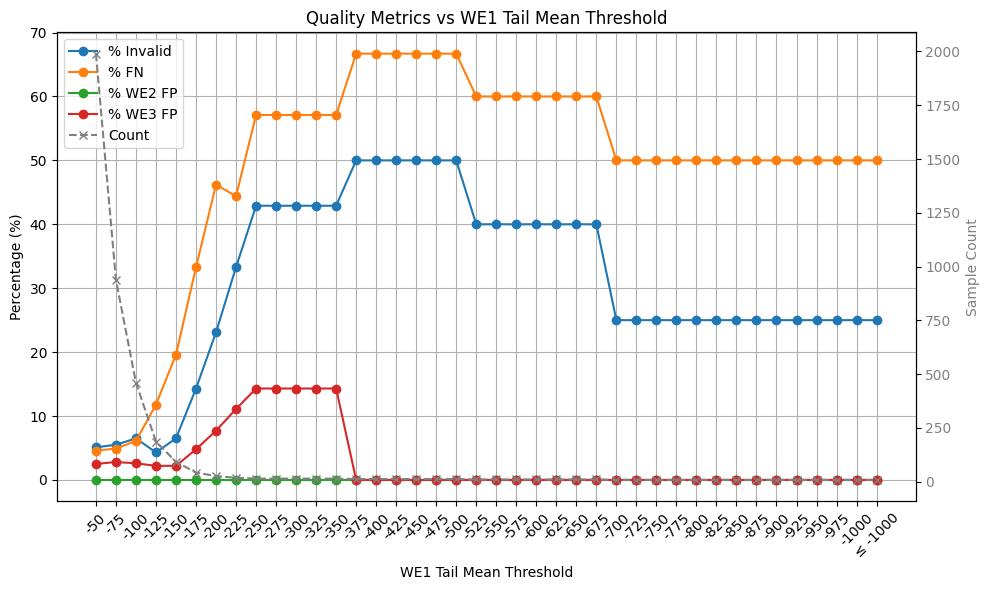

In [106]:
import matplotlib.pyplot as plt

# Create the figure and main axis
fig, ax1 = plt.subplots(figsize=(10,6))

# --- Primary y-axis: Percentages ---
ax1.plot(threshold_summary_df_filtered_cov['Threshold'], threshold_summary_df_filtered_cov['% Invalid'], marker='o', label='% Invalid')
ax1.plot(threshold_summary_df_filtered_cov['Threshold'], threshold_summary_df_filtered_cov['% FN'], marker='o', label='% FN')
ax1.plot(threshold_summary_df_filtered_cov['Threshold'], threshold_summary_df_filtered_cov['% WE2 FP'], marker='o', label='% WE2 FP')
ax1.plot(threshold_summary_df_filtered_cov['Threshold'], threshold_summary_df_filtered_cov['% WE3 FP'], marker='o', label='% WE3 FP')

ax1.set_xlabel('WE1 Tail Mean Threshold')
ax1.set_ylabel('Percentage (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(threshold_summary_df_filtered_cov['Threshold'], rotation=45)
ax1.grid(True)

# --- Secondary y-axis: Count overlay ---
ax2 = ax1.twinx()
ax2.plot(threshold_summary_df_filtered_cov['Threshold'], threshold_summary_df_filtered_cov['Count'],
         color='gray', linestyle='--', marker='x', label='Count')
ax2.set_ylabel('Sample Count', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# --- Combine legends ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Title and layout
plt.title('Quality Metrics vs WE1 Tail Mean Threshold')
plt.tight_layout()
plt.show()


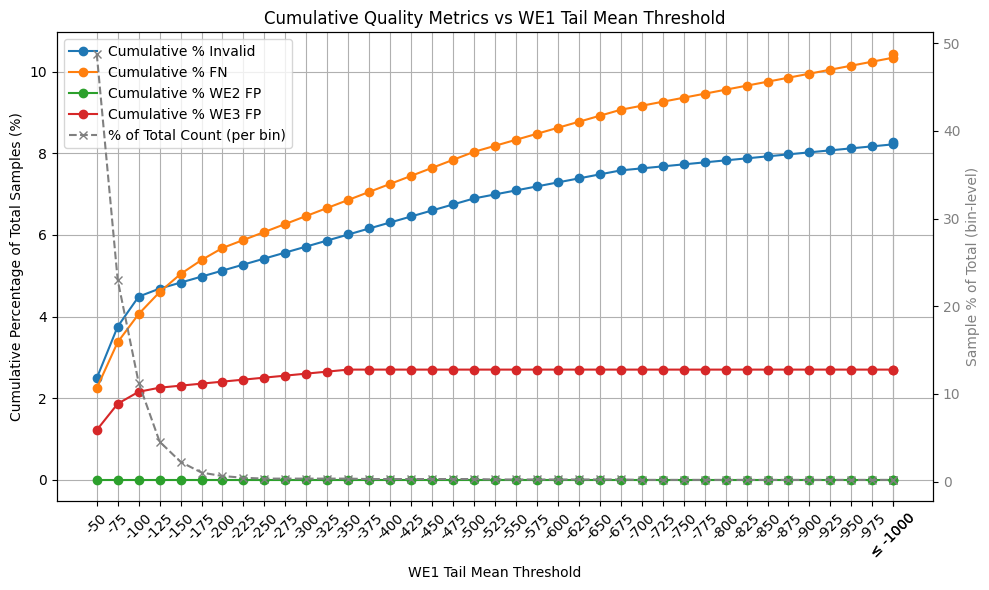

In [107]:
# Running Average plot of Invalids and failure Modes

# --- Copy original ---
df = threshold_summary_df_filtered_cov.copy()

# --- Parse numeric threshold values (handle labels like "≤ -1000") ---
def parse_threshold(x):
    if isinstance(x, str):
        x = x.replace('≤', '').strip()
    try:
        return float(x)
    except:
        return np.nan

df['Threshold_num'] = df['Threshold'].apply(parse_threshold)

# --- Sort thresholds numerically (least → most negative) ---
df = df.sort_values(by='Threshold_num', ascending=False)

# --- Convert Count to % of total ---
df['% Count'] = 100 * df['Count'] / df['Count'].sum()

# --- Compute cumulative sums ---
df['cum_Count'] = df['Count'].cumsum()
df['cum_Invalid'] = (df['% Invalid'] / 100 * df['Count']).cumsum()
df['cum_FN'] = (df['% FN'] / 100 * df['Count']).cumsum()
df['cum_WE2_FP'] = (df['% WE2 FP'] / 100 * df['Count']).cumsum()
df['cum_WE3_FP'] = (df['% WE3 FP'] / 100 * df['Count']).cumsum()

# --- Convert cumulative sums to percentages of total Count ---
total_count = df['Count'].sum()
df['cum_% Invalid'] = 100 * df['cum_Invalid'] / total_count
df['cum_% FN'] = 100 * df['cum_FN'] / total_count
df['cum_% WE2 FP'] = 100 * df['cum_WE2_FP'] / total_count
df['cum_% WE3 FP'] = 100 * df['cum_WE3_FP'] / total_count

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(10,6))

# --- Primary axis: cumulative metrics ---
ax1.plot(df['Threshold_num'], df['cum_% Invalid'], marker='o', label='Cumulative % Invalid')
ax1.plot(df['Threshold_num'], df['cum_% FN'], marker='o', label='Cumulative % FN')
ax1.plot(df['Threshold_num'], df['cum_% WE2 FP'], marker='o', label='Cumulative % WE2 FP')
ax1.plot(df['Threshold_num'], df['cum_% WE3 FP'], marker='o', label='Cumulative % WE3 FP')

ax1.set_xlabel('WE1 Tail Mean Threshold')
ax1.set_ylabel('Cumulative Percentage of Total Samples (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(df['Threshold_num'])
ax1.set_xticklabels(df['Threshold'], rotation=45)
ax1.grid(True)

# --- Reverse x-axis (least negative → most negative) ---
ax1.invert_xaxis()

# --- Secondary axis: % Count per threshold ---
ax2 = ax1.twinx()
ax2.plot(df['Threshold_num'], df['% Count'], color='gray', linestyle='--', marker='x', label='% of Total Count (per bin)')
ax2.set_ylabel('Sample % of Total (bin-level)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# --- Combine legends ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Cumulative Quality Metrics vs WE1 Tail Mean Threshold')
plt.tight_layout()
plt.show()


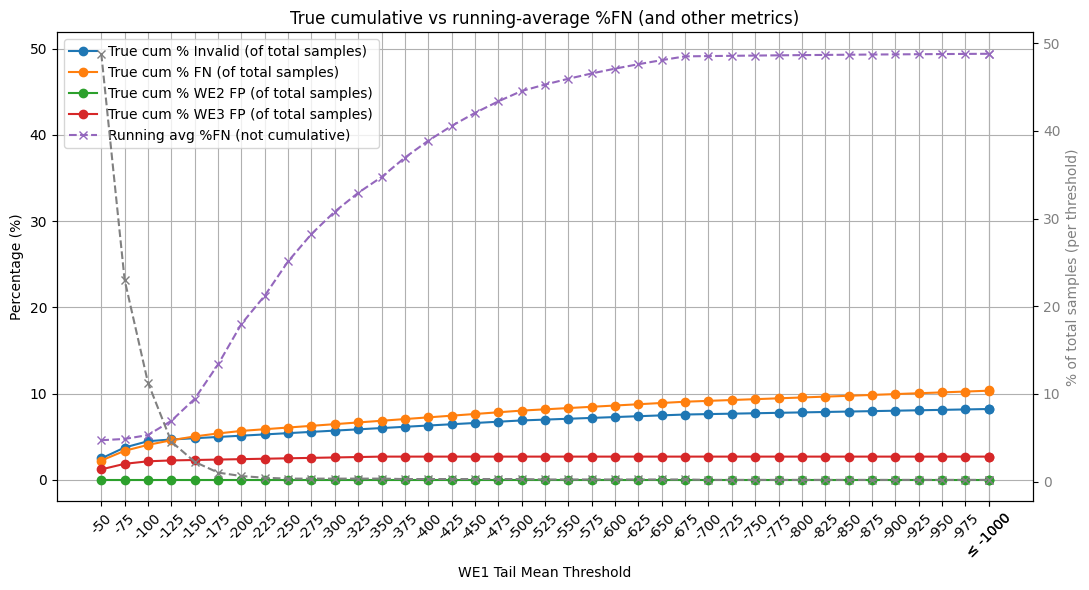

Threshold  Count   % Count  % FN  FN_count  cum_FN_count  cum_%FN_total Highlight_5pct
      -50   1990 48.822375   4.6    91.540        91.540       2.245829               
      -75    938 23.012758   4.9    45.962       137.502       3.373454               
     -100    460 11.285574   6.1    28.060       165.562       4.061874               
     -125    186  4.563297  11.8    21.948       187.510       4.600343     << 5% mark
     -150     92  2.257115  19.6    18.032       205.542       5.042738               
     -175     42  1.030422  33.3    13.986       219.528       5.385868               
     -200     26  0.637880  46.2    12.012       231.540       5.680569               
     -225     18  0.441609  44.4     7.992       239.532       5.876644               
     -250     14  0.343474  57.1     7.994       247.526       6.072767               
     -275     14  0.343474  57.1     7.994       255.520       6.268891               
     -300     14  0.343474  57.1     7.994 

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Copy source
df = threshold_summary_df_filtered_cov.copy()

# Parse numeric thresholds (handle "≤ -1000" etc.)
def parse_threshold(x):
    if isinstance(x, str):
        x = x.replace('≤', '').strip()
    try:
        return float(x)
    except:
        return np.nan

df['Threshold_num'] = df['Threshold'].apply(parse_threshold)

# --- Ensure we only use rows with valid numeric threshold ---
df = df.dropna(subset=['Threshold_num']).copy()

# Sort in the natural accumulation order: least negative -> most negative
df = df.sort_values('Threshold_num', ascending=False).reset_index(drop=True)

# Ensure numeric columns
for col in ['Count', '% FN', '% Invalid', '% WE2 FP', '% WE3 FP']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Per-bin absolute counts of events (from percent and count)
df['FN_count']     = (df['% FN'] / 100.0) * df['Count']
df['Invalid_count']= (df['% Invalid'] / 100.0) * df['Count']
df['WE2FP_count']  = (df['% WE2 FP'] / 100.0) * df['Count']
df['WE3FP_count']  = (df['% WE3 FP'] / 100.0) * df['Count']

# Running-average style (not usually desired for accumulation)
df['running_avg_%FN'] = df['% FN'].cumsum() / np.arange(1, len(df) + 1)

# True cumulative totals (absolute) and convert to percent of total samples
total_samples = df['Count'].sum() if df['Count'].sum() else 1
df['cum_FN_count'] = df['FN_count'].cumsum()
df['cum_%FN_total'] = 100.0 * df['cum_FN_count'] / total_samples

# Also cum for Invalids / FPs
df['cum_Invalid_count'] = df['Invalid_count'].cumsum()
df['cum_%Invalid_total'] = 100.0 * df['cum_Invalid_count'] / total_samples
df['cum_WE2FP_count'] = df['WE2FP_count'].cumsum()
df['cum_%WE2FP_total'] = 100.0 * df['cum_WE2FP_count'] / total_samples
df['cum_WE3FP_count'] = df['WE3FP_count'].cumsum()
df['cum_%WE3FP_total'] = 100.0 * df['cum_WE3FP_count'] / total_samples

# Diagnostic: check monotonicity (should be non-decreasing)
def is_monotonic_nondec(series):
    return (np.diff(series) >= -1e-8).all()

monotonic_fn = is_monotonic_nondec(df['cum_%FN_total'].values)
if not monotonic_fn:
    print("WARNING: cum_%FN_total is not monotonic non-decreasing. Inspect 'FN_count' and ordering.")

# Add % Total Samples column (aka % Count)
df['% Count'] = 100.0 * df['Count'] / total_samples

# Add Highlight column for rows where % Count ~ 5% (±0.5%)
tolerance = 0.5
df['Highlight_5pct'] = df['% Count'].apply(lambda x: '<< 5% mark' if abs(x - 5.0) <= tolerance else '')

# --- Plot both versions for comparison ---
fig, ax = plt.subplots(figsize=(11,6))

# True cumulative proportions (preferred)
ax.plot(df['Threshold_num'], df['cum_%Invalid_total'], marker='o', label='True cum % Invalid (of total samples)')
ax.plot(df['Threshold_num'], df['cum_%FN_total'], marker='o', label='True cum % FN (of total samples)')
ax.plot(df['Threshold_num'], df['cum_%WE2FP_total'], marker='o', label='True cum % WE2 FP (of total samples)')
ax.plot(df['Threshold_num'], df['cum_%WE3FP_total'], marker='o', label='True cum % WE3 FP (of total samples)')

# Running-average lines (for reference)
ax.plot(df['Threshold_num'], df['running_avg_%FN'], marker='x', linestyle='--', label='Running avg %FN (not cumulative)')

# X axis labels
ax.set_xticks(df['Threshold_num'])
ax.set_xticklabels(df['Threshold'], rotation=45)
ax.invert_xaxis()  # show least negative -> most negative left->right
ax.set_xlabel('WE1 Tail Mean Threshold')
ax.set_ylabel('Percentage (%)')
ax.grid(True)
ax.legend(loc='upper left')

# Right axis: percent of samples per threshold (bin-level)
ax2 = ax.twinx()
ax2.plot(df['Threshold_num'], df['% Count'], color='gray', linestyle='--', marker='x', label='% of total (per threshold)')
ax2.set_ylabel('% of total samples (per threshold)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Show plot
plt.title('True cumulative vs running-average %FN (and other metrics)')
plt.tight_layout()
plt.show()

# Optional: print a small table for debugging with new columns
display_cols = ['Threshold', 'Count', '% Count', '% FN', 'FN_count', 'cum_FN_count', 'cum_%FN_total', 'Highlight_5pct']
print(df[display_cols].head(12).to_string(index=False))


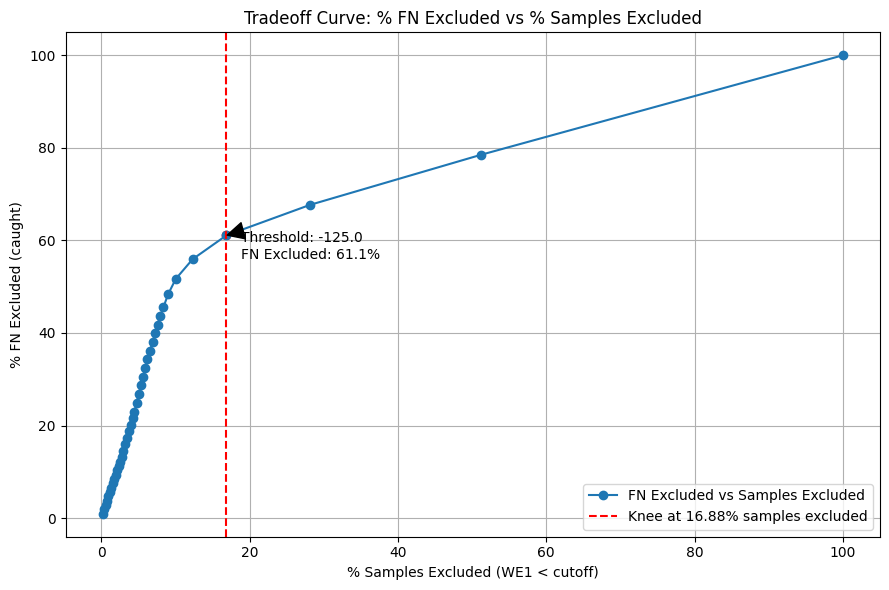

Recommended WE1 threshold cutoff: -125.0


Threshold  Count  % Valid  % Invalid  % FN  % WE2 FP  % WE3 FP  FN_total  \
0       -50   1990     94.9        5.1   4.6       0.0       2.5        91   
1       -75    938     94.5        5.5   4.9       0.0       2.8        46   
2      -100    460     93.5        6.5   6.1       0.0       2.6        28   
3      -125    186     95.7        4.3  11.8       0.0       2.2        22   
4      -150     92     93.5        6.5  19.6       0.0       2.2        18   
5      -175     42     85.7       14.3  33.3       0.0       4.8        14   
6      -200     26     76.9       23.1  46.2       0.0       7.7        12   
7      -225     18     66.7       33.3  44.4       0.0      11.1         8   
8      -250     14     57.1       42.9  57.1       0.0      14.3         8   
9      -275     14     57.1       42.9  57.1       0.0      14.3         8   

   FN_invalid  % FN_invalid  ...  % WE2_FP_invalid  WE3_FP_total  \
0          12          13.2  ...               NaN            50   
1           8          17.4  ...               NaN            26   
2           8          28.6  ...               NaN            12   
3           8          36.4  ...               NaN             4   
4           6          33.3  ...               NaN             2   
5           6          42.9  ...               NaN             2   
6           6          50.0  ...               NaN             2   
7           6          75.0  ...               NaN             2   
8           6          75.0  ...               NaN             2   
9           6          75.0  ...               NaN             2   

   WE3_FP_invalid  % WE3_FP_invalid  Threshold_num  FN_count  \
0               2               4.0          -50.0    91.540   
1               0               0.0          -75.0    45.962   
2               0               0.0         -100.0    28.060   
3               0               0.0         -125.0    21.948   
4               0               0.0         -150.0    18.032   
5               0               0.0         -175.0    13.986   
6               0               0.0         -200.0    12.012   
7               0               0.0         -225.0     7.992   
8               0               0.0         -250.0     7.994   
9               0               0.0         -275.0     7.994   

   samples_excluded  fn_excluded  % samples_excluded  % fn_excluded  
0              4076      425.526          100.000000     100.000000  
1              2086      333.986           51.177625      78.487801  
2              1148      288.024           28.164868      67.686581  
3               688      259.964           16.879293      61.092389  
4               502      238.016           12.315996      55.934537  
5               410      219.984           10.058881      51.696959  
6               368      205.998            9.028459      48.410203  
7               342      193.986            8.390579      45.587344  
8               324      185.994            7.948970      43.709198  
9               310      178.000            7.605496      41.830581  

[10 rows x 22 columns]

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kneed import KneeLocator  # You'll need to install this package via pip

def analyze_we1_cutoff_tradeoff(threshold_df, threshold_col='Threshold', count_col='Count', fn_percent_col='% FN'):
    """
    Analyze tradeoff between sample exclusion and FN exclusion by WE1 threshold.
    Detect knee point to recommend cutoff.

    Parameters:
    - threshold_df: pd.DataFrame with threshold summary
    - threshold_col: column name with threshold labels
    - count_col: column with sample counts per threshold bin
    - fn_percent_col: column with % FN per threshold bin

    Returns:
    - recommended_cutoff: numeric threshold value at knee point
    - plot figure with annotated tradeoff curve
    - augmented DataFrame with cumulative stats and knee point info
    """
    df = threshold_summary_df_filtered_cov.copy()

    # Parse numeric threshold (handle "≤ -1000" etc.)
    def parse_threshold(x):
        if isinstance(x, str):
            x = x.replace('≤', '').strip()
        try:
            return float(x)
        except:
            return np.nan

    df['Threshold_num'] = df[threshold_col].apply(parse_threshold)
    df = df.dropna(subset=['Threshold_num']).copy()

    # Sort descending (least negative -> most negative)
    df = df.sort_values('Threshold_num', ascending=False).reset_index(drop=True)

    # Ensure numeric columns
    for col in [count_col, fn_percent_col]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    total_samples = df[count_col].sum()
    total_fn = ((df[fn_percent_col] / 100) * df[count_col]).sum()

    # Calculate FN counts and cumulative sums (reversed for exclusion)
    df['FN_count'] = (df[fn_percent_col] / 100) * df[count_col]

    # Reverse cumulative sums (samples excluded and FN excluded if cutoff at each threshold)
    df['samples_excluded'] = df[count_col][::-1].cumsum()[::-1]
    df['fn_excluded'] = df['FN_count'][::-1].cumsum()[::-1]

    # Percents of totals
    df['% samples_excluded'] = 100 * df['samples_excluded'] / total_samples
    df['% fn_excluded'] = 100 * df['fn_excluded'] / total_fn

    # Detect knee/elbow point
    knee = KneeLocator(
        df['% samples_excluded'], df['% fn_excluded'],
        curve='concave', direction='increasing'
    )
    knee_point = knee.knee

    # Get threshold value at knee if found
    if knee_point is not None:
        recommended_cutoff = df.loc[(df['% samples_excluded'] - knee_point).abs().idxmin(), 'Threshold_num']
    else:
        recommended_cutoff = None

    # Plot tradeoff curve with knee point annotated
    plt.figure(figsize=(9,6))
    plt.plot(df['% samples_excluded'], df['% fn_excluded'], marker='o', label='FN Excluded vs Samples Excluded')
    if knee_point is not None:
        plt.axvline(knee_point, color='red', linestyle='--', label=f'Knee at {knee_point:.2f}% samples excluded')
        knee_y = df.loc[(df['% samples_excluded'] - knee_point).abs().idxmin(), '% fn_excluded']
        plt.scatter(knee_point, knee_y, color='red')
        plt.annotate(f"Threshold: {recommended_cutoff}\nFN Excluded: {knee_y:.1f}%",
                     xy=(knee_point, knee_y), xytext=(knee_point+2, knee_y-5),
                     arrowprops=dict(facecolor='black', shrink=0.05))
    plt.xlabel('% Samples Excluded (WE1 < cutoff)')
    plt.ylabel('% FN Excluded (caught)')
    plt.title('Tradeoff Curve: % FN Excluded vs % Samples Excluded')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return recommended_cutoff, df


recommended_cutoff, augmented_df = analyze_we1_cutoff_tradeoff(threshold_summary_df_filtered_cov)
print(f"Recommended WE1 threshold cutoff: {recommended_cutoff}")
display(augmented_df.head(10))


Raw summary:
Total rows in df_raw: 3139
Column 'we1_step66_tailmean' present? True
Non-null values in 'we1_step66_tailmean': 3139
FN total from raw data (sum of `FN`): 250

Counts per bin (including NaN):
                  count
_tmp_bin               
-50 to 0_or_more   1945
-75 to -51          592
-100 to -76         280
-125 to -101        193
-150 to -126         65
-175 to -151         34
-200 to -176         10
<-325                 9
-225 to -201          7
-250 to -226          4
-275 to -251          0
-325 to -301          0
-300 to -276          0

Number of rows with NaN bin (not placed into any bin): 0

Total FN in raw data: 250
Total FN in binned (non-NaN) data: 250
Total rows in raw: 3139, total rows placed in bins: 3139

Binned summary (sorted least negative → most negative):
        _tmp_bin  Count   % Count      % FN  FN_count  cum_FN_count  cum_%FN_total
-50 to 0_or_more   1945 61.962408  9.768638       190           190       6.052883
      -75 to -51    592 18.8595

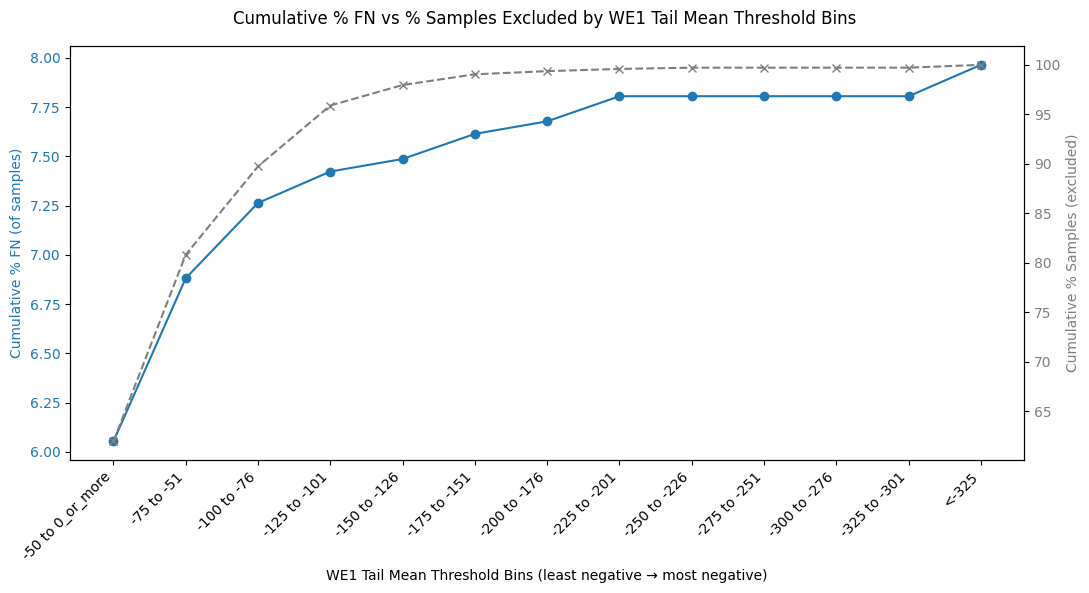


All rows were placed into bins successfully (no NaNs).


In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG: use the actual raw dataframe and correct WE1 column name ---
df_raw = df_cov_filtered.copy()   # your raw fluB dataframe
value_col = 'we1_step66_tailmean'  # correct column used elsewhere in our convo
fn_col = 'FN'                      # binary 0/1 column indicating False Negative

# --- define bin edges you used before (adjust if you want different cut points) ---
bin_edges = [-np.inf, -325, -300, -275, -250, -225, -200, -175, -150, -125, -100, -75, -50, np.inf]
# Make readable labels (we'll display the left-inclusive upper edge representation)
bin_labels = ['<-325', '-325 to -301', '-300 to -276', '-275 to -251', '-250 to -226',
              '-225 to -201', '-200 to -176', '-175 to -151', '-150 to -126', '-125 to -101',
              '-100 to -76', '-75 to -51', '-50 to 0_or_more']

# --- Quick diagnostics: existence & nulls in the WE1 column ---
print("Raw summary:")
print(f"Total rows in df_raw: {len(df_raw)}")
print(f"Column '{value_col}' present? {value_col in df_raw.columns}")
print(f"Non-null values in '{value_col}': {df_raw[value_col].notna().sum()}")
print(f"FN total from raw data (sum of `{fn_col}`): {df_raw[fn_col].sum()}\n")

# --- BINNING (defensive) ---
df_raw['_tmp_bin'] = pd.cut(df_raw[value_col], bins=bin_edges, labels=bin_labels, right=True)

# Show how many rows ended up in bins vs how many were dropped (NaN)
bin_counts_with_nan = df_raw['_tmp_bin'].value_counts(dropna=False).to_frame(name='count')
print("Counts per bin (including NaN):")
print(bin_counts_with_nan)
print("\nNumber of rows with NaN bin (not placed into any bin):", df_raw['_tmp_bin'].isna().sum())

# --- AGGREGATE BY BIN (only non-NaN bins) ---
df_summary = (
    df_raw.dropna(subset=['_tmp_bin'])
    .groupby('_tmp_bin', observed=True)
    .agg(
        Count=('FN', 'size'),
        FN_count=(fn_col, 'sum')
    )
    .reset_index()
)

# Reindex to ensure all bins present in order
df_summary = df_summary.set_index('_tmp_bin').reindex(bin_labels).reset_index()

# --- Compute percentages & cumulative ---
df_summary['% FN'] = 100.0 * df_summary['FN_count'] / df_summary['Count']
df_summary['% FN'] = df_summary['% FN'].fillna(0)  # avoid NaN when Count=0
df_summary['Count'] = df_summary['Count'].fillna(0).astype(int)
df_summary['FN_count'] = df_summary['FN_count'].fillna(0).astype(int)

# --- SORT bins from least negative to most negative ---
df_summary_sorted = df_summary.iloc[::-1].reset_index(drop=True)

# Recalculate cumulative columns in forward order
df_summary_sorted['cum_FN_count'] = df_summary_sorted['FN_count'].cumsum()
total_samples_in_bins = df_summary_sorted['Count'].sum()
df_summary_sorted['cum_%FN_total'] = 100.0 * df_summary_sorted['cum_FN_count'] / total_samples_in_bins if total_samples_in_bins else 0.0
df_summary_sorted['% Count'] = 100.0 * df_summary_sorted['Count'] / total_samples_in_bins if total_samples_in_bins else 0.0
df_summary_sorted['cum_%Samples'] = df_summary_sorted['% Count'].cumsum()

# --- Diagnostics: compare sums to raw data ---
total_fn_raw = int(df_raw[fn_col].sum())
total_fn_binned = int(df_summary['FN_count'].sum())
print(f"\nTotal FN in raw data: {total_fn_raw}")
print(f"Total FN in binned (non-NaN) data: {total_fn_binned}")
print(f"Total rows in raw: {len(df_raw)}, total rows placed in bins: {int(df_raw['_tmp_bin'].notna().sum())}")

# --- Display sorted summary table ---
display_cols = ['_tmp_bin', 'Count', '% Count', '% FN', 'FN_count', 'cum_FN_count', 'cum_%FN_total']
print("\nBinned summary (sorted least negative → most negative):")
print(df_summary_sorted[display_cols].to_string(index=False))

# --- Plot cumulative FN and samples excluded ---
fig, ax1 = plt.subplots(figsize=(11,6))

color_fn = 'tab:blue'
color_sample = 'tab:gray'

ax1.set_xlabel('WE1 Tail Mean Threshold Bins (least negative → most negative)')
ax1.set_ylabel('Cumulative % FN (of samples)', color=color_fn)
ax1.plot(df_summary_sorted['_tmp_bin'], df_summary_sorted['cum_%FN_total'], marker='o', color=color_fn, label='Cumulative % FN')
ax1.tick_params(axis='y', labelcolor=color_fn)
ax1.set_xticklabels(df_summary_sorted['_tmp_bin'], rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative % Samples (excluded)', color=color_sample)
ax2.plot(df_summary_sorted['_tmp_bin'], df_summary_sorted['cum_%Samples'], marker='x', linestyle='--', color=color_sample, label='Cumulative % Samples')
ax2.tick_params(axis='y', labelcolor=color_sample)

fig.suptitle('Cumulative % FN vs % Samples Excluded by WE1 Tail Mean Threshold Bins')
fig.tight_layout()
plt.show()

# --- Optional: print examples for any NaN bins ---
nan_mask = df_raw['_tmp_bin'].isna()
if nan_mask.any():
    print("\nExamples (first 10) of rows where bin is NaN (shows WE1 value):")
    print(df_raw.loc[nan_mask, [value_col, fn_col]].head(10).to_string(index=False))
else:
    print("\nAll rows were placed into bins successfully (no NaNs).")

# --- Clean up temporary column ---
df_raw.drop(columns=['_tmp_bin'], inplace=True)


In [111]:
print(df_cov_filtered.shape)
print(df_cov_filtered['FN'].value_counts())

(3139, 172)
FN
0    2889
1     250
Name: count, dtype: int64


In [112]:
# Extracting cartridges from -70 to 0 bin in df_cov where FN = 1

cartridges_with_fn = df_cov[(df_cov['we1_step66_tailmean'] > -70) & (df_cov['FN'] ==1)]
cartridges_with_fn.head()

Study Label                           Pellet                Variable A  \
66    FABC-0350  FABC-Tetra-20251003-MT-HF-T6K-A             Control RV202   
149   FABC-0350  FABC-Tetra-20251003-MT-HF-T6K-A  RV202 + 0.5% Triton X100   
153   FABC-0350  FABC-Tetra-20251003-MT-HF-T6K-A  RV202 + 0.5% Triton X100   
154   FABC-0350  FABC-Tetra-20251003-MT-HF-T6K-A  RV202 + 0.5% Triton X100   
155   FABC-0350  FABC-Tetra-20251003-MT-HF-T6K-A  RV202 + 0.5% Triton X100   

    Variable B Variable C Variable D   Procedure Test Sample RP Type  \
66         NaN        NaN        NaN  FABC-1.0.0         CoV     SCM   
149        NaN        NaN        NaN  FABC-1.0.0         CoV     SCM   
153        NaN        NaN        NaN  FABC-1.0.0         CoV     SCM   
154        NaN        NaN        NaN  FABC-1.0.0         CoV     SCM   
155        NaN        NaN        NaN  FABC-1.0.0         CoV     SCM   

    RP Cell Count  ... we6_step93_max we1_step66_tailmean  \
66            NaN  ...            0.0          -31.714828   
149           NaN  ...            0.0          -15.382642   
153           NaN  ...            0.0          -24.504611   
154           NaN  ...            0.0          -16.569574   
155           NaN  ...            0.0          -16.332187   

     we2_step66_tailmean we3_step66_tailmean we4_step66_tailmean  \
66                   0.0                 0.0                 0.0   
149                  0.0                 0.0                 0.0   
153                  0.0                 0.0                 0.0   
154                  0.0                 0.0                 0.0   
155                  0.0                 0.0                 0.0   

    we5_step66_tailmean we6_step66_tailmean FN WE3_FP  WE2_FP  
66                  0.0                 0.0  1      0       0  
149                 0.0                 0.0  1      0       0  
153                 0.0                 0.0  1      0       0  
154                 0.0                 0.0  1      0       0  
155                 0.0                 0.0  1      0       0  

[5 rows x 170 columns]

In [113]:
# Count of Cov Cartridges with FN's

cartridges_with_fn['cartridgeSerialNumber'].nunique()

175

In [114]:
# Count of Cov Cartridges with FN's that are also invalid

# Check for non-null and non-empty string values in 'Warnings'
warnings_present = cartridges_with_fn['Warnings'].notna() & (cartridges_with_fn['Warnings'].astype(str).str.strip().astype(bool))

# Count unique cartridges where warnings are present
count_with_warnings = cartridges_with_fn[warnings_present]['cartridgeSerialNumber'].nunique()

print(f'Count of unique cartridges with FN that also have warnings: {count_with_warnings}')

Count of unique cartridges with FN that also have warnings: 34


# NTC Analysis


In [115]:
# Building df_analysis_ntc forlater analysis_ntc work

# Use a clean copy of the data
df_analysis_ntc = df_ntc.copy()  # or df_cov_filtered, depending on the dataset

# Ensure the column exists and drop NA only for the analysis_ntc
df_analysis_ntc = df_analysis_ntc[df_analysis_ntc['we1_step66_tailmean'].notna()]




In [116]:
import pandas as pd
import numpy as np

# -------------------------------
# 1️⃣ Define continuous thresholds
# -------------------------------
thresholds = list(range(-50, -1025, -25))  # -50, -325, ..., -1000
thresholds.append(-999999)  # catch ≤ -1000
threshold_labels = [str(t) if t != -999999 else "≤ -1000" for t in thresholds]

# -------------------------------
# 2️⃣ Ensure status and FP/FN columns exist
# -------------------------------
def classify_status(row):
    """Return Valid/Invalid based on Warnings/Errors presence."""
    for col in ['Warnings', 'Errors']:
        if col in row and pd.notna(row[col]) and str(row[col]).strip():
            return "Invalid"
    return "Valid"

df_analysis_ntc['status'] = df_analysis_ntc.apply(classify_status, axis=1)

for flag in ['WE2_FP', 'WE3_FP', 'WE5_FP']:
    if flag not in df_analysis_ntc.columns:
        df_analysis_ntc[flag] = False

# -------------------------------
# 3️⃣ Loop through thresholds
# -------------------------------
results = []

for i, t in enumerate(thresholds):
    label = threshold_labels[i]

    # Subset for this threshold
    if t == -999999:
        subset = df_analysis_ntc[df_analysis_ntc['we1_step66_tailmean'] <= -1000]
    else:
        subset = df_analysis_ntc[df_analysis_ntc['we1_step66_tailmean'] <= t]

    if subset.empty:
        continue

    n = len(subset)

    # Valid / Invalid counts
    valid = (subset['status'] == 'Valid').sum()
    invalid = (subset['status'] == 'Invalid').sum()

    # FN / FP totals
    we2_total = subset['WE2_FP'].sum()
    we3_total = subset['WE3_FP'].sum()
    we5_total = subset['WE5_FP'].sum()

    # FN / FP also invalid
    we2_invalid = subset.loc[subset['WE2_FP'] & (subset['status'] == 'Invalid')].shape[0]
    we3_invalid = subset.loc[subset['WE3_FP'] & (subset['status'] == 'Invalid')].shape[0]
    we5_invalid = subset.loc[subset['WE5_FP'] & (subset['status'] == 'Invalid')].shape[0]

    # Append results
    results.append({
        'Threshold': label,
        'Count': n,
        '% Valid': 100 * valid / n,
        '% Invalid': 100 * invalid / n,
        '% WE2 FP': 100 * we2_total / n,
        '% WE3 FP': 100 * we3_total / n,
        '% WE5 FP': 100 * we5_total / n,
        'WE2_FP_total': we2_total,
        'WE2_FP_invalid': we2_invalid,
        '% WE2_FP_invalid': 100 * we2_invalid / we2_total if we2_total else np.nan,
        'WE3_FP_total': we3_total,
        'WE3_FP_invalid': we3_invalid,
        '% WE3_FP_invalid': 100 * we3_invalid / we3_total if we3_total else np.nan,
        'WE5_FP_total': we5_total,
        'WE5_FP_invalid': we5_invalid,
        '% WE5_FP_invalid': 100 * we5_invalid / we5_total if we5_total else np.nan
    })

# -------------------------------
# 4️⃣ Convert to DataFrame
# -------------------------------
threshold_summary_df = pd.DataFrame(results)

# Round percentages
pct_cols = [col for col in threshold_summary_df.columns if col.startswith('%')]
threshold_summary_df[pct_cols] = threshold_summary_df[pct_cols].round(1)

# -------------------------------
# 5️⃣ Optional: filter columns
# -------------------------------
threshold_summary_df_filtered_ntc = threshold_summary_df[[
    'Threshold', 'Count', '% Valid', '% Invalid','% WE2 FP','% WE3 FP', '% WE5 FP',
    'WE2_FP_total', 'WE2_FP_invalid', '% WE2_FP_invalid',
    'WE3_FP_total', 'WE3_FP_invalid', '% WE3_FP_invalid',
    'WE5_FP_total', 'WE5_FP_invalid', '% WE5_FP_invalid'
]]

# -------------------------------
# 6️⃣ Display
# -------------------------------
display(threshold_summary_df_filtered_ntc)


Threshold  Count  % Valid  % Invalid  % WE2 FP  % WE3 FP  % WE5 FP  \
0        -50   4012     92.6        7.4       1.3       0.5       0.4   
1        -75   2032     91.4        8.6       1.5       0.5       0.6   
2       -100   1113     87.6       12.4       1.8       0.9       1.0   
3       -125    647     83.6       16.4       2.3       1.4       1.4   
4       -150    428     77.6       22.4       3.3       1.9       1.4   
5       -175    357     75.4       24.6       3.6       2.0       1.7   
6       -200    300     71.0       29.0       3.7       2.3       2.0   
7       -225    280     70.4       29.6       3.9       2.5       2.1   
8       -250    255     68.6       31.4       4.3       2.7       2.4   
9       -275    218     66.5       33.5       4.1       3.2       2.8   
10      -300    208     66.8       33.2       4.3       3.4       2.9   
11      -325    200     67.0       33.0       4.5       3.5       3.0   
12      -350    190     66.8       33.2       4.2       3.7       3.2   
13      -375    183     67.8       32.2       4.4       3.8       3.3   
14      -400    175     68.0       32.0       4.6       4.0       3.4   
15      -425    170     68.2       31.8       4.7       4.1       3.5   
16      -450    166     68.1       31.9       4.8       4.2       3.6   
17      -475    158     69.0       31.0       5.1       4.4       3.8   
18      -500    154     69.5       30.5       5.2       4.5       3.9   
19      -525    145     71.7       28.3       5.5       4.8       3.4   
20      -550    140     71.4       28.6       5.7       5.0       3.6   
21      -575    136     71.3       28.7       5.9       5.1       3.7   
22      -600    132     71.2       28.8       6.1       5.3       3.8   
23      -625    130     71.5       28.5       6.2       5.4       3.8   
24      -650    129     71.3       28.7       6.2       5.4       3.9   
25      -675    126     71.4       28.6       6.3       5.6       3.2   
26      -700    123     71.5       28.5       6.5       5.7       3.3   
27      -725    121     71.9       28.1       6.6       5.8       3.3   
28      -750    119     73.1       26.9       6.7       5.9       3.4   
29      -775    116     72.4       27.6       6.9       6.0       3.4   
30      -800    115     72.2       27.8       7.0       6.1       3.5   
31      -825    110     73.6       26.4       7.3       6.4       3.6   
32      -850    106     74.5       25.5       7.5       6.6       3.8   
33      -875    100     74.0       26.0       8.0       7.0       4.0   
34      -900     99     73.7       26.3       8.1       7.1       4.0   
35      -925     98     74.5       25.5       8.2       7.1       4.1   
36      -950     93     73.1       26.9       8.6       7.5       4.3   
37      -975     93     73.1       26.9       8.6       7.5       4.3   
38     -1000     92     72.8       27.2       8.7       7.6       4.3   
39   ≤ -1000     92     72.8       27.2       8.7       7.6       4.3   

    WE2_FP_total  WE2_FP_invalid  % WE2_FP_invalid  WE3_FP_total  \
0             51              16              31.4            19   
1             30              11              36.7            11   
2             20              10              50.0            10   
3             15               9              60.0             9   
4             14               8              57.1             8   
5             13               7              53.8             7   
6             11               7              63.6             7   
7             11               7              63.6             7   
8             11               7              63.6             7   
9              9               7              77.8             7   
10             9               7              77.8             7   
11             9               7              77.8             7   
12             8               6              75.0             7   
13             8               6              75.0       

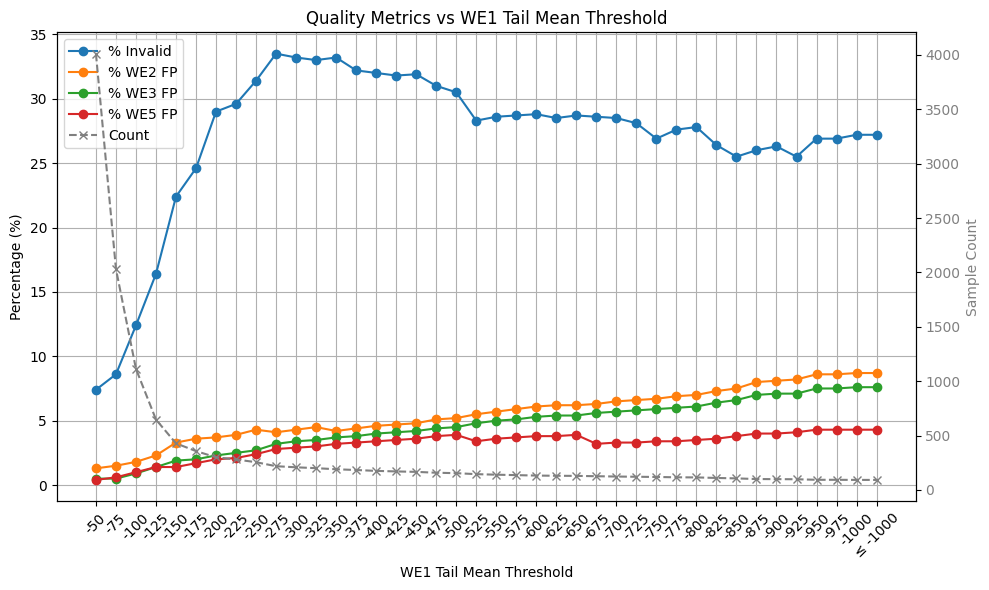

In [117]:
import matplotlib.pyplot as plt

# Create the figure and main axis
fig, ax1 = plt.subplots(figsize=(10,6))

# --- Primary y-axis: Percentages ---
ax1.plot(threshold_summary_df_filtered_ntc['Threshold'], threshold_summary_df_filtered_ntc['% Invalid'], marker='o', label='% Invalid')
ax1.plot(threshold_summary_df_filtered_ntc['Threshold'], threshold_summary_df_filtered_ntc['% WE2 FP'], marker='o', label='% WE2 FP')
ax1.plot(threshold_summary_df_filtered_ntc['Threshold'], threshold_summary_df_filtered_ntc['% WE3 FP'], marker='o', label='% WE3 FP')
ax1.plot(threshold_summary_df_filtered_ntc['Threshold'], threshold_summary_df_filtered_ntc['% WE5 FP'], marker='o', label='% WE5 FP')

ax1.set_xlabel('WE1 Tail Mean Threshold')
ax1.set_ylabel('Percentage (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(threshold_summary_df_filtered_ntc['Threshold'], rotation=45)
ax1.grid(True)

# --- Secondary y-axis: Count overlay ---
ax2 = ax1.twinx()
ax2.plot(threshold_summary_df_filtered_ntc['Threshold'], threshold_summary_df_filtered_ntc['Count'],
         color='gray', linestyle='--', marker='x', label='Count')
ax2.set_ylabel('Sample Count', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# --- Combine legends ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Title and layout
plt.title('Quality Metrics vs WE1 Tail Mean Threshold')
plt.tight_layout()
plt.show()


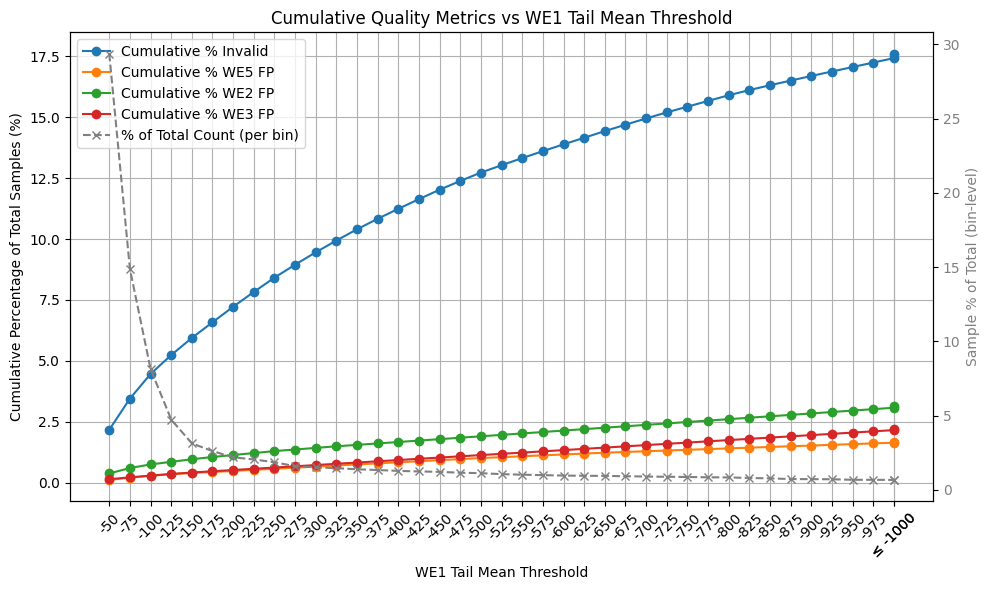

In [118]:
# Running Average plot of Invalids and failure Modes

# --- Copy original ---
df = threshold_summary_df_filtered_ntc.copy()

# --- Parse numeric threshold values (handle labels like "≤ -1000") ---
def parse_threshold(x):
    if isinstance(x, str):
        x = x.replace('≤', '').strip()
    try:
        return float(x)
    except:
        return np.nan

df['Threshold_num'] = df['Threshold'].apply(parse_threshold)

# --- Sort thresholds numerically (least → most negative) ---
df = df.sort_values(by='Threshold_num', ascending=False)

# --- Convert Count to % of total ---
df['% Count'] = 100 * df['Count'] / df['Count'].sum()

# --- Compute cumulative sums ---
df['cum_Count'] = df['Count'].cumsum()
df['cum_Invalid'] = (df['% Invalid'] / 100 * df['Count']).cumsum()
df['cum_WE5_FP'] = (df['% WE5 FP'] / 100 * df['Count']).cumsum()
df['cum_WE2_FP'] = (df['% WE2 FP'] / 100 * df['Count']).cumsum()
df['cum_WE3_FP'] = (df['% WE3 FP'] / 100 * df['Count']).cumsum()

# --- Convert cumulative sums to percentages of total Count ---
total_count = df['Count'].sum()
df['cum_% Invalid'] = 100 * df['cum_Invalid'] / total_count
df['cum_% WE5 FP'] = 100 * df['cum_WE5_FP'] / total_count
df['cum_% WE2 FP'] = 100 * df['cum_WE2_FP'] / total_count
df['cum_% WE3 FP'] = 100 * df['cum_WE3_FP'] / total_count

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(10,6))

# --- Primary axis: cumulative metrics ---
ax1.plot(df['Threshold_num'], df['cum_% Invalid'], marker='o', label='Cumulative % Invalid')
ax1.plot(df['Threshold_num'], df['cum_% WE5 FP'], marker='o', label='Cumulative % WE5 FP')
ax1.plot(df['Threshold_num'], df['cum_% WE2 FP'], marker='o', label='Cumulative % WE2 FP')
ax1.plot(df['Threshold_num'], df['cum_% WE3 FP'], marker='o', label='Cumulative % WE3 FP')

ax1.set_xlabel('WE1 Tail Mean Threshold')
ax1.set_ylabel('Cumulative Percentage of Total Samples (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(df['Threshold_num'])
ax1.set_xticklabels(df['Threshold'], rotation=45)
ax1.grid(True)

# --- Reverse x-axis (least negative → most negative) ---
ax1.invert_xaxis()

# --- Secondary axis: % Count per threshold ---
ax2 = ax1.twinx()
ax2.plot(df['Threshold_num'], df['% Count'], color='gray', linestyle='--', marker='x', label='% of Total Count (per bin)')
ax2.set_ylabel('Sample % of Total (bin-level)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# --- Combine legends ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Cumulative Quality Metrics vs WE1 Tail Mean Threshold')
plt.tight_layout()
plt.show()


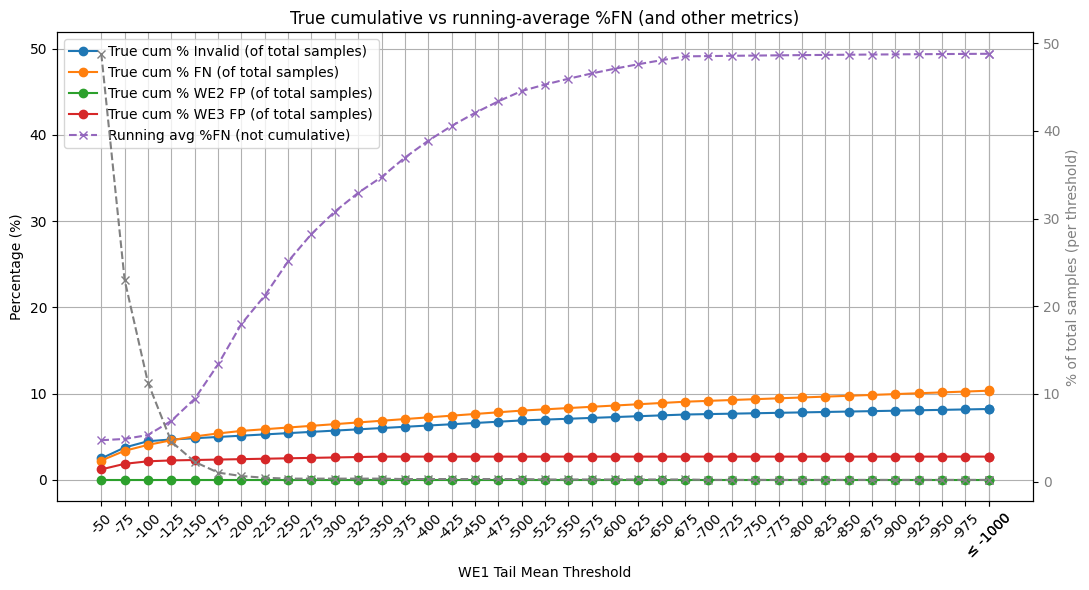

Threshold  Count  % FN  FN_count  cum_FN_count  cum_%FN_total
      -50   1990   4.6    91.540        91.540       2.245829
      -75    938   4.9    45.962       137.502       3.373454
     -100    460   6.1    28.060       165.562       4.061874
     -125    186  11.8    21.948       187.510       4.600343
     -150     92  19.6    18.032       205.542       5.042738
     -175     42  33.3    13.986       219.528       5.385868
     -200     26  46.2    12.012       231.540       5.680569
     -225     18  44.4     7.992       239.532       5.876644
     -250     14  57.1     7.994       247.526       6.072767
     -275     14  57.1     7.994       255.520       6.268891
     -300     14  57.1     7.994       263.514       6.465015
     -325     14  57.1     7.994       271.508       6.661138


In [119]:
# Cumulative Plot of Invalids and Failure Modes

# copy source
df = threshold_summary_df_filtered_cov.copy()

# parse numeric thresholds (handle "≤ -1000" etc.)
def parse_threshold(x):
    if isinstance(x, str):
        x = x.replace('≤', '').strip()
    try:
        return float(x)
    except:
        return np.nan

df['Threshold_num'] = df['Threshold'].apply(parse_threshold)

# --- Ensure we only use rows with valid numeric threshold ---
df = df.dropna(subset=['Threshold_num']).copy()

# Sort in the natural accumulation order: least negative -> most negative
df = df.sort_values('Threshold_num', ascending=False).reset_index(drop=True)

# Ensure numeric columns
for col in ['Count', '% FN', '% Invalid', '% WE2 FP', '% WE3 FP']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Per-bin absolute counts of events (from percent and count)
df['FN_count']     = (df['% FN'] / 100.0) * df['Count']
df['Invalid_count']= (df['% Invalid'] / 100.0) * df['Count']
df['WE2FP_count']  = (df['% WE2 FP'] / 100.0) * df['Count']
df['WE3FP_count']  = (df['% WE3 FP'] / 100.0) * df['Count']

# --- Running-average style (not usually desired for accumulation) ---
df['running_avg_%FN'] = df['% FN'].cumsum() / np.arange(1, len(df) + 1)

# --- True cumulative totals (absolute) and convert to percent of total samples ---
total_samples = df['Count'].sum() if df['Count'].sum() else 1
df['cum_FN_count'] = df['FN_count'].cumsum()
df['cum_%FN_total'] = 100.0 * df['cum_FN_count'] / total_samples

# Also cum for Invalids / FPs
df['cum_Invalid_count'] = df['Invalid_count'].cumsum()
df['cum_%Invalid_total'] = 100.0 * df['cum_Invalid_count'] / total_samples
df['cum_WE2FP_count'] = df['WE2FP_count'].cumsum()
df['cum_%WE2FP_total'] = 100.0 * df['cum_WE2FP_count'] / total_samples
df['cum_WE3FP_count'] = df['WE3FP_count'].cumsum()
df['cum_%WE3FP_total'] = 100.0 * df['cum_WE3FP_count'] / total_samples

# Diagnostic: check monotonicity (should be non-decreasing)
def is_monotonic_nondec(series):
    return (np.diff(series) >= -1e-8).all()

monotonic_fn = is_monotonic_nondec(df['cum_%FN_total'].values)
if not monotonic_fn:
    print("WARNING: cum_%FN_total is not monotonic non-decreasing. Inspect 'FN_count' and ordering.")

# --- Plot both versions for comparison ---
fig, ax = plt.subplots(figsize=(11,6))

# True cumulative proportions (preferred)
ax.plot(df['Threshold_num'], df['cum_%Invalid_total'], marker='o', label='True cum % Invalid (of total samples)')
ax.plot(df['Threshold_num'], df['cum_%FN_total'], marker='o', label='True cum % FN (of total samples)')
ax.plot(df['Threshold_num'], df['cum_%WE2FP_total'], marker='o', label='True cum % WE2 FP (of total samples)')
ax.plot(df['Threshold_num'], df['cum_%WE3FP_total'], marker='o', label='True cum % WE3 FP (of total samples)')

# Running-average lines (for reference)
ax.plot(df['Threshold_num'], df['running_avg_%FN'], marker='x', linestyle='--', label='Running avg %FN (not cumulative)')

# X axis labels
ax.set_xticks(df['Threshold_num'])
ax.set_xticklabels(df['Threshold'], rotation=45)
ax.invert_xaxis()  # show least negative -> most negative left->right
ax.set_xlabel('WE1 Tail Mean Threshold')
ax.set_ylabel('Percentage (%)')
ax.grid(True)
ax.legend(loc='upper left')

# Right axis: percent of samples per threshold (bin-level)
ax2 = ax.twinx()
df['% Count'] = 100.0 * df['Count'] / total_samples
ax2.plot(df['Threshold_num'], df['% Count'], color='gray', linestyle='--', marker='x', label='% of total (per threshold)')
ax2.set_ylabel('% of total samples (per threshold)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# show
plt.title('True cumulative vs running-average %FN (and other metrics)')
plt.tight_layout()
plt.show()

# Optional: print a small table for debugging
display_cols = ['Threshold','Count','% FN','FN_count','cum_FN_count','cum_%FN_total']
print(df[display_cols].head(12).to_string(index=False))


In [120]:
# Preparing a Merged Summary of all Threshold-Based results

def prepare_summary(df, prefix):
    """
    Prepare a threshold summary DataFrame by:
      - Ensuring 'Threshold' is included
      - Prefixing all other columns
    """
    if 'Threshold' not in df.columns:
        raise ValueError(f"'Threshold' column not found in {prefix} dataframe.")

    # Copy and rename
    df = df.copy()
    rename_map = {col: f"{prefix}_{col}" for col in df.columns if col != 'Threshold'}
    df = df.rename(columns=rename_map)
    return df

# Prepare each dataset dynamically (works even if columns differ)
ntc_df  = prepare_summary(threshold_summary_df_filtered_ntc, "NTC")
fluA_df = prepare_summary(threshold_summary_df_filtered_fluA, "FluA")
fluB_df = prepare_summary(threshold_summary_df_filtered_fluB, "FluB")
cov_df  = prepare_summary(threshold_summary_df_filtered_cov, "CoV")

# Merge all summaries on Threshold (outer join so all thresholds are retained)
merged_summary = ntc_df.merge(fluA_df, on="Threshold", how="outer")
merged_summary = merged_summary.merge(fluB_df, on="Threshold", how="outer")
merged_summary = merged_summary.merge(cov_df, on="Threshold", how="outer")

# Sort Threshold numerically (handles text like '≤ -1000')
def threshold_sort_value(x):
    try:
        return float(x)
    except:
        return -999999  # For strings like '≤ -1000'

merged_summary = merged_summary.sort_values(
    by="Threshold",
    key=lambda col: col.map(threshold_sort_value)
).reset_index(drop=True)

# Clean up column order: Threshold first
cols = ['Threshold'] + [c for c in merged_summary.columns if c != 'Threshold']
merged_summary = merged_summary[cols]

# Display final merged table
display(merged_summary)


Threshold  NTC_Count  NTC_% Valid  NTC_% Invalid  NTC_% WE2 FP  \
0    ≤ -1000         92         72.8           27.2           8.7   
1      -1000         92         72.8           27.2           8.7   
2       -975         93         73.1           26.9           8.6   
3       -950         93         73.1           26.9           8.6   
4       -925         98         74.5           25.5           8.2   
5       -900         99         73.7           26.3           8.1   
6       -875        100         74.0           26.0           8.0   
7       -850        106         74.5           25.5           7.5   
8       -825        110         73.6           26.4           7.3   
9       -800        115         72.2           27.8           7.0   
10      -775        116         72.4           27.6           6.9   
11      -750        119         73.1           26.9           6.7   
12      -725        121         71.9           28.1           6.6   
13      -700        123         71.5           28.5           6.5   
14      -675        126         71.4           28.6           6.3   
15      -650        129         71.3           28.7           6.2   
16      -625        130         71.5           28.5           6.2   
17      -600        132         71.2           28.8           6.1   
18      -575        136         71.3           28.7           5.9   
19      -550        140         71.4           28.6           5.7   
20      -525        145         71.7           28.3           5.5   
21      -500        154         69.5           30.5           5.2   
22      -475        158         69.0           31.0           5.1   
23      -450        166         68.1           31.9           4.8   
24      -425        170         68.2           31.8           4.7   
25      -400        175         68.0           32.0           4.6   
26      -375        183         67.8           32.2           4.4   
27      -350        190         66.8           33.2           4.2   
28      -325        200         67.0           33.0           4.5   
29      -300        208         66.8           33.2           4.3   
30      -275        218         66.5           33.5           4.1   
31      -250        255         68.6           31.4           4.3   
32      -225        280         70.4           29.6           3.9   
33      -200        300         71.0           29.0           3.7   
34      -175        357         75.4           24.6           3.6   
35      -150        428         77.6           22.4           3.3   
36      -125        647         83.6           16.4           2.3   
37      -100       1113         87.6           12.4           1.8   
38       -75       2032         91.4            8.6           1.5   
39       -50       4012         92.6            7.4           1.3   

    NTC_% WE3 FP  NTC_% WE5 FP  NTC_WE2_FP_total  NTC_WE2_FP_invalid  \
0            7.6           4.3                 8                   6   
1            7.6           4.3                 8                   6   
2            7.5           4.3                 8                   6   
3            7.5           4.3                 8                   6   
4            7.1           4.1                 8                   6   
5            7.1           4.0                 8                   6   
6            7.0           4.0                 8                   6   
7            6.6           3.8                 8                   6   
8            6.4           3.6                 8                   6   
9            6.1           3.5                 8                   6   
10           6.0           3.4                 8                   6   
11           5.9           3.4                 8                   6   
12           5.8           3.3                 8                   6   
13           5.7           3.3                 8                   6   
14           5.6           3.2                 8                   6   
15           5.4     

In [121]:
merged_summary.to_csv('merged_summary.csv', index=False)